
# Artifact Evaluation

> #### Optimizing Deep Learning Inference via Global Analysis and Tensor Expressions

Optimizing deep neural network (DNN) execution is impor- tant but becomes increasingly difficult as DNN complexity grows. Existing DNN compilers cannot effectively exploit op- timization opportunities across operator boundaries, leaving room for improvement. To address this challenge, we present Souffle, an open-source compiler that optimizes DNN in- ference across operator boundaries. Souffle creates a global tensor dependency graph using tensor expressions, traces data flow and tensor information, and partitions the compu- tation graph into subprograms based on dataflow analysis and resource constraints. Within a subprogram, Souffle per- forms local optimization via semantic-preserving transfor- mations, finds an optimized program schedule, and improves instruction-level parallelism and data reuse. We evaluated Souffle using six representative DNN models on an NVIDIA A100 GPU. Experimental results show that Souffle consis- tently outperforms six state-of-the-art DNN optimizers by 
delivering a geometric mean speedup of up to $3.7\times$ over TensorRT and $7.8\times$ over Tensorflow XLA.

## Preliminaries
This repository showcases the performance evaluation and comparison between `Souffle`(Our work) and the existing state-of-the-art compilers/frameworks(including `XLA`, `TensorRT`, `Rammer`, `Apollo` and `IREE`).

- **XLA(Tensorflow v2.10)**: The TensorFlow XLA compiler
can fuse DNN operators like point-wise and reduction op-
erators and performs optimizations on the fused operator.
Unlike Souffle that performs analysis and optimizations on
TEs, XLA performs analysis on its high-level operators(HLO)

- **TensorRT(v8.2)**:This GPU-vendor-specific framework optimizes the inference of DNNs on NVIDIA GPUs

- **Rammer(v0.4)**:This DNN compiler is also known as NNFu-
sion. It generates a spatial-temporal schedule at compile
time to minimize scheduling overhead and exploit hardware
parallelism through inter- and intra-operator co-scheduling

- **Apollo**:This represents the state-of-the-art fusion framework for inference optimization. Apollo considers both
memory- and compute-bound tensor operators for kernel
fusions and uses hand-crafted rules to exploit parallelism
between independent tensor operators

- **IREE**:The intermediate resentation execution environment (IREE) builds upon the
LLVM MLIR project. IREE is designed to lower DNN
models to MLIR dialects to optimize model inference. IREE
utilizes the linalg dialect to perform the operator fusion,
which supports loop affine fusion optimization and global
analysis.

The metric assesed in this notebook mainly include end-to-end latency, global memory access and number of kernels.

## Important Notes
**A few bash scripts take more than half an hour to complete; Please wait for the results before executing the next one.**
**I will also provide a online jupyter notebook if you are inconvenient or having troubles  to build the environment. The jupyter notebook is run on our server and you can directly access the notebook and run the experiments from the internet**
### Links to The Paper

**For each step, we highlight that the current evaluation is corresponding to which Section or Figure in the submitted paper.**
The main restuls presented in this repository correspond to the submitted paper's Table 3, 4, 5 and Figure 6.


## 1. Experimental Environments Setup

We have setup the experiment environments on our machine.
For more info about how to setup on you local machine, please refer to `README.md`

### Check the status of docker containers

In [84]:
!docker ps

CONTAINER ID   IMAGE                                      COMMAND                  CREATED        STATUS        PORTS                                                         NAMES
4ef43744f1c6   nvcr.io/nvidia/pytorch:21.10-py3           "/opt/nvidia/nvidia_…"   22 hours ago   Up 22 hours   6006/tcp, 8888/tcp, 0.0.0.0:10086->22/tcp, :::10086->22/tcp   amazing_elbakyan
71c749bdcc48   souffle-iree:latest                        "/opt/nvidia/nvidia_…"   11 days ago    Up 11 days    6006/tcp, 8888/tcp                                            crazy_payne
d7bb5016ebae   souffle-tensorrt8.4.1-ubuntu18.04:latest   "/opt/nvidia/nvidia_…"   11 days ago    Up 11 days                                                                  zen_ardinghelli
80eb556e7070   souffle-tvm-0.8:latest                     "/opt/nvidia/nvidia_…"   2 weeks ago    Up 2 weeks                                                                  objective_tesla
5a6833d4ccc7   488c0e69d5bc                               "/opt

You should see containers with the following image names:
* souffle-tvm-0.8:latest
* souffle-iree:latest
* souffle-tensorrt8.4.1-ubuntu18.04:latest

### Check the hardware of the server (nvidia A100 GPU)

In [106]:
!nvidia-smi

Mon Oct 30 02:16:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:D8:00.0 Off |                    0 |
| N/A   31C    P0    42W / 300W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2. Evaluation
Next, we use four cases to test the end-to-end performance for the baseline compilers and our work.
Each case matches a table or figure in the submitted paper.

we recommend you to run these cases one by one, which reduces the total execution time at most **two hours**.
We also provided a fast mode which re-use the existing profiling data 
to directly print the outputs.

- 2.1 CASE - End-to-end model runtime (Table 3 in Section 8) - around 30 minutes.
- 2.2 CASE - Execution time with Souffle individual optimization (Table 4 in Section 8) - around 30 minutes.
- 2.3 CASE - The number of GPU kernel calls and global memory
data transfer size of the resulting code (Table 5 in Section 8) - around 50 minutes.
- 2.4 CASE - EfficientNet sub-module latency breakdown (Figure 6 in Section 8) - around 10 minutes.

**Log files**

PS: some cases would consume over a half-hour because we have to execute all baselines. Please have a coffee and wait for the output before the subsequent execution.

### 2.1 CASE - End-to-end model runtime (Table 3)
In this case, we compare souffle with five representative state-of-the-art baselines to exploit the end-to-end latency.
We omit Ansor in this case.

| Model       | XLA  | TRT   | Rammer | Apollo | IREE  | Ours |
| ----        | ---- | ----  | ----   | ----   | ----  | ---- |
| BERT        | 2.55 | 1.30  | 2.19   | 3.29   | 2.22  | 1.22 |
| ResNeXt     | 8.91 | 24.82 | 11.69  | 22.80  | 314.8 | 4.43 |
| LSTM        | 10.57| 6.30  | 1.72   | Failed | 16.0  | 0.80 |
| EfficientNet| 2.96 | 1.21  | Falied | 2.3    | 12.33 | 0.66 |
| SwinTrans.  | 6.43 | 1.74  | Falied | 10.78  | 18.1  | 1.55 |
| MMoE        | 0.29 | 0.07  | Falied | 0.049  | 0.088 | 0.014|

**The following commonds reproduce the results of Table 3 in the submiited paper. Please refer to Section8(Page 10) for more details**

Run the experiments:
Note, The args `TRUE` means that we run the workloads rather than read the cached profiling results.

In [99]:
!bash scripts/run_table3.sh TRUE

+++ dirname scripts/run_table3.sh
++ cd scripts
++ pwd
+ script_directory=/home/xiachunwei/Projects/souffle-ae/scripts
+ SOUFFLE_RUN=TRUE
+ '[' -e /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv ']'
+ rm -f /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv
+ touch /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 80eb556e7070 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=80eb556e7070
+ echo 80eb556e7070
80eb556e7070
+ docker exec -it -e SOUFFLE_RUN=TRUE 80eb556e7070 /bin/bash -c /workspace/baseline/xla/run_xla.sh
++ cd /workspace/baseline/xla/xla_models
++ export TF_DUMP_GRAPH_PREFIX=/tmp/tf_dump_graph/
++ TF_DUMP_GRAPH_PREFIX=/tmp/tf_dump_graph/
++ export 'TF_XLA_FLAGS=--tf_xla_enable_xla_devices --tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'
++ TF_XLA_FLAGS='--tf_xla_enable_xla_devices --tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'
++ select_latenc

2023-10-29 03:12:02.737692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2023-10-29 03:12:04.003184: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
NoneType: None
NoneType: None
NoneType: None
SKIPPED: /workspace/baseline/xla/xla_models/Swin-Transformer-Tensorflow/swin-trans-nsys.sqlite does not contain NV Tools Extension (NVTX) data.
++ sqlite3 --csv swin-trans-nsys.sqlite 'SELECT names.value AS name, end - start FROM CUPTI_ACTIVITY_KIND_KERNEL AS k JOIN StringIds AS names ON k.demangledName = names.id;'
++ python3 ../extract_nsys_cuda_kernel_latency.py swin-trans-nsys.xla.csv
9.902186
+++ python3 ../../../extract_ncu_cuda_kernel_latency.py swin-trans-ncu-raw.xla.csv
++ XLA_SWIN_TRANS_LATENCY=7.8960322265625
++ cd ..
++ '[' -n TRUE ']'
++ '[' TRUE = TRUE ']'
++ nsys profile --stats=true -o tf_mmoe-nsys -f true python3 tf_mmoe.py
++ sqlite3 --csv tf_mmoe-nsys.

Iteration time 2.041856 ms
Iteration time 2.039808 ms
Iteration time 2.041856 ms
Iteration time 2.040832 ms
Iteration time 2.043904 ms
Iteration time 2.037760 ms
Iteration time 2.041856 ms
Iteration time 2.039808 ms
Iteration time 2.040832 ms
Iteration time 2.044928 ms
Iteration time 2.044928 ms
Iteration time 2.041856 ms
Iteration time 2.042880 ms
Iteration time 2.039808 ms
Iteration time 2.042880 ms
Iteration time 2.041856 ms
Iteration time 2.038784 ms
Iteration time 2.043904 ms
Iteration time 2.041856 ms
Summary: [min, max, mean] = [2.032640, 2.063360, 2.083734] ms
Result_4538_0: 
-5.814197e+00 2.095543e+01 7.772099e+00 -4.431520e+00 5.586838e+00 -8.111473e+00 -7.602885e-01 -2.187579e+01 -1.287763e+01 -2.509347e+00  .. (size = 10, ends with -2.509347e+00);
Result_4538_0: 
-5.814197e+00 2.095543e+01 7.772099e+00 -4.431520e+00 5.586838e+00 -8.111473e+00 -7.602885e-01 -2.187579e+01 -1.287763e+01 -2.509347e+00  .. (size = 10, ends with -2.509347e+00);
Result_4538_0: 
-5.814197e+00 2.095

Iteration time 11.481312 ms
Iteration time 11.464993 ms
Iteration time 11.463648 ms
Iteration time 11.471232 ms
Iteration time 11.468928 ms
Iteration time 11.477088 ms
Iteration time 11.481984 ms
Iteration time 11.462880 ms
Iteration time 11.466623 ms
Iteration time 11.488320 ms
Iteration time 11.460672 ms
Iteration time 11.460095 ms
Iteration time 11.467104 ms
Iteration time 11.470464 ms
Iteration time 11.487743 ms
Iteration time 11.452225 ms
Iteration time 11.475840 ms
Iteration time 11.472192 ms
Iteration time 11.469696 ms
Iteration time 11.469791 ms
Iteration time 11.449823 ms
Iteration time 11.461440 ms
Iteration time 11.464224 ms
Iteration time 11.458752 ms
Iteration time 11.464895 ms
Iteration time 11.482559 ms
Iteration time 11.456448 ms
Iteration time 11.475168 ms
Iteration time 11.464031 ms
Iteration time 11.475456 ms
Iteration time 11.474112 ms
Iteration time 11.464320 ms
Iteration time 11.483423 ms
Iteration time 11.481504 ms
Iteration time 11.462112 ms
Iteration time 11.46

Iteration time 11.486784 ms
Iteration time 11.457025 ms
Iteration time 11.471807 ms
Iteration time 11.471232 ms
Iteration time 11.480351 ms
Iteration time 11.449536 ms
Iteration time 11.480832 ms
Iteration time 11.471040 ms
Iteration time 11.485825 ms
Iteration time 11.492352 ms
Iteration time 11.492160 ms
Iteration time 11.461632 ms
Iteration time 11.487072 ms
Iteration time 11.479872 ms
Iteration time 11.482848 ms
Iteration time 11.443295 ms
Iteration time 11.484097 ms
Iteration time 11.459712 ms
Iteration time 11.486689 ms
Iteration time 11.470655 ms
Iteration time 11.465569 ms
Iteration time 11.475936 ms
Iteration time 11.470464 ms
Iteration time 11.467968 ms
Iteration time 11.462016 ms
Iteration time 11.511648 ms
Iteration time 11.471232 ms
Iteration time 11.439744 ms
Iteration time 11.455488 ms
Iteration time 11.479776 ms
Iteration time 11.470655 ms
Iteration time 11.472000 ms
Iteration time 11.470079 ms
Iteration time 11.475936 ms
Iteration time 11.455488 ms
Iteration time 11.49

[WARNING] ME(14619:140211578776704,MainProcess):2023-10-29-03:17:51.524.562 [mindspore/run_check/_check_version.py:139] MindSpore version 1.3.0 and nvcc(cuda bin) version 11.7 does not match, please refer to the installation guide for version matching information: https://www.mindspore.cn/install
SKIPPED: /workspace/baseline/mindspore/apollo-swin-transformer-nsys.sqlite does not contain NV Tools Extension (NVTX) data.
+ sqlite3 --csv apollo-swin-transformer-nsys.sqlite 'SELECT names.value AS name, end - start FROM CUPTI_ACTIVITY_KIND_KERNEL AS k JOIN StringIds AS names ON k.demangledName = names.id;'
++ python3 /workspace/baseline/mindspore/extract_nsys_cuda_kernel_latency.py apollo-swin-transformer-nsys.csv
+ APOLLO_SWIN_TRANS_LATENCY=11.373723
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ nsys profile --stats=true -o apollo-tf_MMoE_1_100_16_8_2-nsys -f true python3 /workspace/mindspore/model_zoo/official/nlp/bert/src/mindspore_mmoe.py
[WARNING] ME(19735:140037016767616,MainProcess):2023-


CUDA API Statistics:

 Time (%)  Total Time (ns)  Num Calls   Avg (ns)    Med (ns)   Min (ns)  Max (ns)   StdDev (ns)              Name            
 --------  ---------------  ---------  ----------  ----------  --------  ---------  -----------  ----------------------------
     78.5       1948297142         41  47519442.5  33967841.0  26102190  163169888   32444724.7  cuModuleLoadDataEx          
      7.4        184703449       6572     28104.6      4171.0      2948     290428      55251.6  cuLaunchKernel              
      3.9         95752742          2  47876371.0  47876371.0  27505877   68246865   28808228.9  cuStreamSynchronize         
      2.7         66057070          1  66057070.0  66057070.0  66057070   66057070          0.0  cuDevicePrimaryCtxRelease_v2
      2.3         57127926       2080     27465.3      4643.0      3815     279564      53855.1  cuMemcpyAsync               
      2.0         49285964       2113     23325.1      9683.0      3260     295079      45655.7


CUDA Memory Operation Statistics (by time):

 Time (%)  Total Time (ns)  Count   Avg (ns)    Med (ns)   Min (ns)  Max (ns)  StdDev (ns)              Operation            
 --------  ---------------  -----  ----------  ----------  --------  --------  -----------  ---------------------------------
     65.8         27504625      1  27504625.0  27504625.0  27504625  27504625          0.0  [CUDA memcpy HtoD]               
     17.0          7096927   2114      3357.1      3360.0      2912      4544        142.6  [CUDA memset]                    
     16.8          7018628   2079      3376.0      3360.0      3167      4128        110.3  [CUDA memcpy DtoD]               
      0.3           135152     20      6757.6      2959.0      2527     38816       8564.3  [CUDA Unified Memory memcpy HtoD]
      0.2            74873     13      5759.5      2591.0      1919     21824       5653.1  [CUDA Unified Memory memcpy DtoH]

[8/8] Executing 'gpumemsizesum' stats report

CUDA Memory Operation Sta


CUDA Kernel Statistics:

 Time (%)  Total Time (ns)  Instances  Avg (ns)  Med (ns)  Min (ns)  Max (ns)  StdDev (ns)                    Name                   
 --------  ---------------  ---------  --------  --------  --------  --------  -----------  -----------------------------------------
     83.4          6707418        416   16123.6   15808.0     15647     18528        642.5  forward_dispatch_7_matmul_1x256x256_f32  
     11.4           916268         47   19495.1   19168.0     19072     21632        779.4  forward_dispatch_18_matmul_1x256x256_f32 
      1.9           155648          8   19456.0   19424.0     19296     19680        124.5  forward_dispatch_66_matmul_1x256x256_f32 
      1.6           127329          6   21221.5   21232.0     20992     21440        207.6  forward_dispatch_130_matmul_1x256x256_f32
      1.1            91389          7   13055.6    3232.0      3199     72000      25992.1  forward_dispatch_0                       
      0.2            15297          

Generating '/tmp/nsys-report-05f2.qdstrm'
[1/8] [========================100%] iree-efficientnet-b0-nsys.nsys-rep
[2/8] [========================100%] iree-efficientnet-b0-nsys.sqlite
[3/8] Executing 'nvtxsum' stats report
SKIPPED: /workspace/iree_models/iree-efficientnet-b0-nsys.sqlite does not contain NV Tools Extension (NVTX) data.
[4/8] Executing 'osrtsum' stats report

Operating System Runtime API Statistics:

 Time (%)  Total Time (ns)  Num Calls   Avg (ns)    Med (ns)    Min (ns)  Max (ns)   StdDev (ns)       Name     
 --------  ---------------  ---------  ----------  -----------  --------  ---------  -----------  --------------
     95.1       5134996734         83  61867430.5  100108189.0      3168  100141111   45196630.3  poll          
      3.6        193411821        774    249886.1      15423.5      1025   21126971     907234.3  ioctl         
      0.9         48547904         31   1566061.4      18771.0      8423   20504666    4007030.3  sem_timedwait 
      0.2       


CUDA Memory Operation Statistics (by size):

 Total (MB)  Count  Avg (MB)  Med (MB)  Min (MB)  Max (MB)  StdDev (MB)              Operation            
 ----------  -----  --------  --------  --------  --------  -----------  ---------------------------------
     21.032      1    21.032    21.032    21.032    21.032        0.000  [CUDA memcpy HtoD]               
     19.077     17     1.122     0.777     0.373     4.903        1.096  [CUDA memset]                    
      1.049     22     0.048     0.010     0.004     0.442        0.098  [CUDA Unified Memory memcpy HtoD]
      0.668     13     0.051     0.012     0.004     0.258        0.073  [CUDA Unified Memory memcpy DtoH]

Generated:
    /workspace/iree_models/iree-efficientnet-b0-nsys.nsys-rep
    /workspace/iree_models/iree-efficientnet-b0-nsys.sqlite
+ sqlite3 --csv iree-efficientnet-b0-nsys.sqlite 'SELECT names.value AS name, end - start FROM CUPTI_ACTIVITY_KIND_KERNEL AS k JOIN StringIds AS names ON k.demangledName = names.

Generating '/tmp/nsys-report-4eb2.qdstrm'
[1/8] [========================100%] iree-swin-transformer-nsys.nsys-rep
[2/8] [========================100%] iree-swin-transformer-nsys.sqlite
[3/8] Executing 'nvtxsum' stats report
SKIPPED: /workspace/iree_models/iree-swin-transformer-nsys.sqlite does not contain NV Tools Extension (NVTX) data.
[4/8] Executing 'osrtsum' stats report

Operating System Runtime API Statistics:

 Time (%)  Total Time (ns)  Num Calls   Avg (ns)     Med (ns)    Min (ns)   Max (ns)   StdDev (ns)       Name     
 --------  ---------------  ---------  -----------  -----------  ---------  ---------  -----------  --------------
     91.8       5694434851         91   62576207.2  100105585.0       3261  100114174   45223915.6  poll          
      4.0        245045043        769     318654.2      16043.0       1006   36620356    1682099.0  ioctl         
      3.2        200499349          1  200499349.0  200499349.0  200499349  200499349          0.0  fread         
   

[7/8] Executing 'gpumemtimesum' stats report

CUDA Memory Operation Statistics (by time):

 Time (%)  Total Time (ns)  Count   Avg (ns)    Med (ns)   Min (ns)  Max (ns)  StdDev (ns)              Operation            
 --------  ---------------  -----  ----------  ----------  --------  --------  -----------  ---------------------------------
     97.8         29635680      1  29635680.0  29635680.0  29635680  29635680          0.0  [CUDA memcpy HtoD]               
      1.5           463527    112      4138.6      3712.0      3328     10080       1524.2  [CUDA memcpy DtoD]               
      0.4           112587     24      4691.1      4175.5      2463     10271       2400.0  [CUDA Unified Memory memcpy HtoD]
      0.3            79386     13      6106.6      5504.0      1919     21408       5521.0  [CUDA Unified Memory memcpy DtoH]
      0.0             9184      6      1530.7      1536.0      1472      1600         55.1  [CUDA memset]                    

[8/8] Executing 'gpumemsiz


CUDA Kernel Statistics:

 Time (%)  Total Time (ns)  Instances  Avg (ns)  Med (ns)  Min (ns)  Max (ns)  StdDev (ns)                      Name                    
 --------  ---------------  ---------  --------  --------  --------  --------  -----------  --------------------------------------------
     28.5             8192          1    8192.0    8192.0      8192      8192          0.0  forward_dispatch_0_vecmat_128x100_f32       
     18.7             5376          1    5376.0    5376.0      5376      5376          0.0  forward_dispatch_1_vecmat_8x100_f32         
     11.3             3232          1    3232.0    3232.0      3232      3232          0.0  forward_dispatch_3_generic_8_f32            
     10.6             3040          1    3040.0    3040.0      3040      3040          0.0  forward_dispatch_2_generic_8_f32xi32xf32xi32
     10.4             2975          1    2975.0    2975.0      2975      2975          0.0  forward_dispatch_6_generic_16x8_f32         
     10.3      

==PROF== Profiling "vectorized_elementwise_kernel" - 48: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 49: 0%....50%....100% - 1 pass
==PROF== Profiling "DeviceReduceSingleTileKernel" - 50: 0%....50%....100% - 1 pass
==PROF== Profiling "DeviceCompactInitKernel" - 51: 0%....50%....100% - 1 pass
==PROF== Profiling "DeviceSelectSweepKernel" - 52: 0%....50%....100% - 1 pass
[tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       dtype=torch.float16), tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan,

==PROF== Profiling "resnext_imagenet_50_fused_con..." - 10: 0%....50%....100% - 1 pass
2023-10-29 03:20:56,122 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv3x3_1_56_56_4_4_3.log, 98376.89399999999
==PROF== Target process 20196 terminated before first instrumented API call.
==PROF== Target process 20195 terminated before first instrumented API call.
==PROF== Target process 20198 terminated before first instrumented API call.
==PROF== Target process 20197 terminated before first instrumented API call.
==PROF== Target process 20199 terminated before first instrumented API call.
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 11: 0%....50%....100% - 1 pass
2023-10-29 03:20:56,313 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_56_56_256_256.log, 97827.315
2023-10-29 03:20:56,313 souffle_resnext.py:99 conv2 finish!
==PROF== Target process 20201 terminated before first instrumented API call.
==PROF== Target process 20200 terminated before first inst

==PROF== Target process 20263 terminated before first instrumented API call.
==PROF== Target process 20262 terminated before first instrumented API call.
==PROF== Target process 20264 terminated before first instrumented API call.
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 25: 0%....50%....100% - 1 pass
2023-10-29 03:20:58,923 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_28_28_512_512.log, 98076.545
==PROF== Target process 20266 terminated before first instrumented API call.
==PROF== Target process 20265 terminated before first instrumented API call.
==PROF== Target process 20268 terminated before first instrumented API call.
==PROF== Target process 20267 terminated before first instrumented API call.
==PROF== Target process 20269 terminated before first instrumented API call.
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 26: 0%....50%....100% - 1 pass
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 27: 0%....50%....100% - 1 pass
2023-1

==PROF== Profiling "resnext_imagenet_50_fused_con..." - 53: 0%....50%....100% - 1 pass
2023-10-29 03:21:04,156 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_16_16_3.log, 98174.462
==PROF== Target process 20401 terminated before first instrumented API call.
==PROF== Target process 20400 terminated before first instrumented API call.
==PROF== Target process 20403 terminated before first instrumented API call.
==PROF== Target process 20402 terminated before first instrumented API call.
==PROF== Target process 20404 terminated before first instrumented API call.
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 54: 0%....50%....100% - 1 pass
2023-10-29 03:21:04,346 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log, 98504.99600000001
==PROF== Target process 20405 terminated before first instrumented API call.
==PROF== Target process 20406 terminated before first instrumented API call.
==PROF== Target process 20408 termina

==PROF== Profiling "resnext_imagenet_50_fused_con..." - 67: 0%....50%....100% - 1 pass
2023-10-29 03:21:06,813 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv1x1_bn_relu_1_14_14_1024_16_64.log, 101257.08899999999
==PROF== Target process 20471 terminated before first instrumented API call.
==PROF== Target process 20470 terminated before first instrumented API call.
==PROF== Target process 20473 terminated before first instrumented API call.
==PROF== Target process 20472 terminated before first instrumented API call.
==PROF== Target process 20474 terminated before first instrumented API call.
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 68: 0%....50%....100% - 1 pass
2023-10-29 03:21:06,996 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_16_16_3.log, 98318.14300000001
==PROF== Target process 20476 terminated before first instrumented API call.
==PROF== Target process 20475 terminated before first instrumented API call.
==PROF== Targ

==PROF== Target process 20538 terminated before first instrumented API call.
==PROF== Target process 20537 terminated before first instrumented API call.
==PROF== Target process 20539 terminated before first instrumented API call.
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 81: 0%....50%....100% - 1 pass
2023-10-29 03:21:09,451 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log, 98092.435
==PROF== Target process 20541 terminated before first instrumented API call.
==PROF== Target process 20540 terminated before first instrumented API call.
==PROF== Target process 20543 terminated before first instrumented API call.
==PROF== Target process 20542 terminated before first instrumented API call.
==PROF== Target process 20544 terminated before first instrumented API call.
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 82: 0%....50%....100% - 1 pass
2023-10-29 03:21:09,645 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv1x1

==PROF== Target process 20606 terminated before first instrumented API call.
==PROF== Target process 20605 terminated before first instrumented API call.
==PROF== Target process 20608 terminated before first instrumented API call.
==PROF== Target process 20607 terminated before first instrumented API call.
==PROF== Target process 20609 terminated before first instrumented API call.
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 95: 0%....50%....100% - 1 pass
2023-10-29 03:21:12,101 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_16_16_3.log, 97799.578
==PROF== Target process 20611 terminated before first instrumented API call.
==PROF== Target process 20610 terminated before first instrumented API call.
==PROF== Target process 20613 terminated before first instrumented API call.
==PROF== Target process 20612 terminated before first instrumented API call.
==PROF== Target process 20614 terminated before first instrumented API call.
==PROF== Profiling "

+ ncu -i ./ncu-souffle_resnext_O4.ncu-rep --csv --page raw
+ grep -v 'at::native*'
++ python3 ../../extract_ncu_cuda_kernel_latency.py ncu-souffle_resnext_O4.csv
+ SOUFFLE_RESNEXT_LATENCY=4.88630419921875
+ cd /workspace/souffle-models/python/models/lstm
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none --target-processes all -o ncu-souffle_lstm_O4 -f python3 souffle_lstm.py O3 1 1
==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 20731 (/workspace/anaconda3/bin/python3.9)
==PROF== Profiling "vectorized_elementwise_kernel" - 0: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 1: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 2: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 3: 0%....50%....100% - 1 pass
==PROF== Profiling "vecto

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 20836 (/workspace/anaconda3/bin/python3.9)
==PROF== Target process 20880 terminated before first instrumented API call.
==PROF== Target process 20879 terminated before first instrumented API call.
==PROF== Target process 20882 terminated before first instrumented API call.
==PROF== Target process 20881 terminated before first instrumented API call.
==PROF== Target process 20883 terminated before first instrumented API call.
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 0: 0%....50%....100% - 1 pass
2023-10-29 03:21:26,094 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_224_224_32_3_3_2_1.log, 688223.346
==PROF== Target process 20886 terminated before first instrumented API call.
==PROF== Target process 20885 terminated before first instrumented API call.
==PROF== Target process 20888 terminated before fir

==PROF== Profiling "vectorized_elementwise_kernel" - 85: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 86: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 87: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 88: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 89: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 90: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 91: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 92: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 93: 0%....50%....100% - 1 pass
sigmoid fuse
==PROF== Profiling "efficientnet_se_module_v2_sig..." - 94: 0%....50%....100% - 1 pass
==PROF== Target process 20966 terminated before first instrumented API call.
==PROF== Target process 20965 terminated before first instrumented 

==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 129: 0%....50%....100% - 1 pass
2023-10-29 03:21:43,572 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_14_14_480_5_5_1_1.log, 98618.934
==PROF== Target process 21009 terminated before first instrumented API call.
==PROF== Profiling "vectorized_elementwise_kernel" - 130: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 131: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 132: 0%....50%....100% - 1 pass
opt_level 1
[1 480 14 14], [20, 480]
==PROF== Profiling "vectorized_elementwise_kernel" - 133: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 134: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 135: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 136: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 137: 0%....50%....100% 

==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 176: 0%....50%....100% - 1 pass
2023-10-29 03:21:49,699 ansor_module.py:46 kernel_configs/efficient_head_conv1x1_bn_swish_1_14_14_112_672_1_1_1.log, 98816.3
==PROF== Target process 21049 terminated before first instrumented API call.
==PROF== Target process 21051 terminated before first instrumented API call.
==PROF== Target process 21050 terminated before first instrumented API call.
==PROF== Target process 21053 terminated before first instrumented API call.
==PROF== Target process 21052 terminated before first instrumented API call.
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 177: 0%....50%....100% - 1 pass
2023-10-29 03:21:49,998 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_14_14_672_5_5_2_1.log, 99351.915
==PROF== Target process 21054 terminated before first instrumented API call.
==PROF== Profiling "vectorized_elementwise_kernel" - 178: 0%....50%....100% - 1 pass
==PROF== Profiling "vecto

==PROF== Profiling "efficient_pointwise_conv2d_bn..." - 223: 0%....50%....100% - 1 pass
2023-10-29 03:21:55,816 ansor_module.py:46 kernel_configs/efficient_pointwise_conv2d_bn_short_cut_add_7_7_1152_192_1.log, 102127.902
==PROF== Target process 21091 terminated before first instrumented API call.
==PROF== Target process 21090 terminated before first instrumented API call.
==PROF== Target process 21093 terminated before first instrumented API call.
==PROF== Target process 21092 terminated before first instrumented API call.
==PROF== Target process 21094 terminated before first instrumented API call.
==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 224: 0%....50%....100% - 1 pass
2023-10-29 03:21:56,116 ansor_module.py:46 kernel_configs/efficient_head_conv1x1_bn_swish_1_7_7_192_1152_1_1_1.log, 100143.08699999998
==PROF== Target process 21096 terminated before first instrumented API call.
==PROF== Target process 21095 terminated before first instrumented API call.
==PROF== Target p

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 21191 (/workspace/anaconda3/bin/python3.9)
2023-10-29 03:22:03,371 ansor_utils.py:60 1696455418.8059032, 1696379585.8803368, False
==PROF== Target process 21235 terminated before first instrumented API call.
==PROF== Target process 21234 terminated before first instrumented API call.
==PROF== Target process 21237 terminated before first instrumented API call.
2023-10-29 03:22:03,442 ansor_utils.py:88 load built module kernel_configs/swin_transformer_patch_embed_conv2d_1_224_3_128_4_4_float16.log.tar
==PROF== Target process 21236 terminated before first instrumented API call.
==PROF== Target process 21238 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_patch_embed_..." - 0: 0%....50%....100% - 1 pass
2023-10-29 03:22:06,537 ansor_utils.py:96 kernel_configs/swin_transformer_patch_embed_conv2d_1_224_3_12

==PROF== Target process 21314 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 13: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [64, 64, 64, 4, 128, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (4096, 32, 4), weight_shape:(128, 128) 
inline Tensor(shape=[4096, 128], op.name=reshape_permute)
==PROF== Target process 21324 terminated before first instrumented API call.
==PROF== Target process 21323 terminated before first instrumented API call.
==PROF== Target process 21322 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 14: 0%....50%....100% - 1 pass
2023-10-29 03:22:20,508 ansor_utils.py:60 1696458612.6520305, 1696379585.8763363, False
==PROF== Target process 21331 terminated before first instrumented API call.
==PROF== Target process 21330 terminated before first instrumented API call.
==PROF== Target process 21333 terminated before 

==PROF== Target process 21396 terminated before first instrumented API call.
==PROF== Target process 21395 terminated before first instrumented API call.
==PROF== Target process 21398 terminated before first instrumented API call.
2023-10-29 03:22:28,599 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_28_28_256_float16.log.tar
==PROF== Target process 21397 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_layer_normal..." - 28: 0%....50%....100% - 1 pass
2023-10-29 03:22:28,703 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_28_28_256_float16.log mean_time 99089.576 us
==PROF== Target process 21399 terminated before first instrumented API call.
==PROF== Profiling "Kernel" - 29: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 30: 0%....50%....100% - 1 pass
height: 28, width: 28, channel: 256
inline Tensor(shape=[1024, 256], op.name=x_roll_permute_matmul)
==PROF=

==PROF== Target process 21469 terminated before first instrumented API call.
==PROF== Target process 21468 terminated before first instrumented API call.
==PROF== Target process 21471 terminated before first instrumented API call.
2023-10-29 03:22:37,847 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16.tar
==PROF== Target process 21470 terminated before first instrumented API call.
==PROF== Target process 21472 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_reshap..." - 44: 0%....50%....100% - 1 pass
2023-10-29 03:22:37,958 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16 mean_time 98281.721 us

Best config:
[('block_row_warps', 1), ('warp_row_tiles', 2), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,43888
==PROF== Target process 21475 terminated before first instrumented API call.
==PROF== T

==PROF== Target process 21556 terminated before first instrumented API call.
==PROF== Target process 21555 terminated before first instrumented API call.
==PROF== Target process 21558 terminated before first instrumented API call.
2023-10-29 03:22:50,103 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Target process 21557 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_layer_normal..." - 58: 0%....50%....100% - 1 pass
2023-10-29 03:22:50,206 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 98596.378 us
==PROF== Target process 21559 terminated before first instrumented API call.
==PROF== Profiling "Kernel" - 59: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 60: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF==

==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 73: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [4, 16, 16, 16, 512, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (256, 32, 16), weight_shape:(512, 512) 
inline Tensor(shape=[256, 512], op.name=reshape_permute)
==PROF== Target process 21644 terminated before first instrumented API call.
==PROF== Target process 21643 terminated before first instrumented API call.
==PROF== Target process 21642 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 74: 0%....50%....100% - 1 pass
2023-10-29 03:23:03,508 ansor_utils.py:60 1696458645.0551488, 1696379585.8763363, False
==PROF== Target process 21651 terminated before first instrumented API call.
==PROF== Target process 21650 terminated before first instrumented API call.
==PROF== Target process 21653 terminated before first instrumented API call.
2023-10-29 03:23:03,688 ansor_utils.py:88 load bu

==PROF== Profiling "swin_transformer_fused_reshap..." - 89: 0%....50%....100% - 1 pass
2023-10-29 03:23:12,678 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16 mean_time 98503.021 us

Best config:
[('block_row_warps', 1), ('warp_row_tiles', 2), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,43888
==PROF== Target process 21725 terminated before first instrumented API call.
==PROF== Target process 21724 terminated before first instrumented API call.
==PROF== Target process 21723 terminated before first instrumented API call.
==PROF== Target process 21732 terminated before first instrumented API call.
==PROF== Target process 21731 terminated before first instrumented API call.
==PROF== Target process 21733 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 90: 0%....50%....100% - 1 pass
TFLOPS: 1.543956584390961e-07
inline Tensor(shape=[64, 64,

==PROF== Profiling "swin_transformer_layer_normal..." - 103: 0%....50%....100% - 1 pass
2023-10-29 03:23:24,966 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 101862.220 us
==PROF== Target process 21809 terminated before first instrumented API call.
==PROF== Profiling "Kernel" - 104: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 105: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF== Target process 21812 terminated before first instrumented API call.
==PROF== Target process 21811 terminated before first instrumented API call.
==PROF== Target process 21810 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 106: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 96687.951
2023-10-29 03:23:26,278 ansor_utils.py:60 169645

==PROF== Target process 21892 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 119: 0%....50%....100% - 1 pass
2023-10-29 03:23:38,314 ansor_utils.py:60 1696458645.0551488, 1696379585.8763363, False
==PROF== Target process 21901 terminated before first instrumented API call.
==PROF== Target process 21900 terminated before first instrumented API call.
==PROF== Target process 21903 terminated before first instrumented API call.
2023-10-29 03:23:38,494 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log.tar
==PROF== Target process 21902 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_window..." - 120: 0%....50%....100% - 1 pass
==PROF== Target process 21904 terminated before first instrumented API call.
2023-10-29 03:23:38,599 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_


Best config:
[('block_row_warps', 1), ('warp_row_tiles', 2), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,43888
==PROF== Target process 21975 terminated before first instrumented API call.
==PROF== Target process 21974 terminated before first instrumented API call.
==PROF== Target process 21973 terminated before first instrumented API call.
==PROF== Target process 21982 terminated before first instrumented API call.
==PROF== Target process 21981 terminated before first instrumented API call.
==PROF== Target process 21983 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 135: 0%....50%....100% - 1 pass
TFLOPS: 1.5453467988856618e-07
inline Tensor(shape=[64, 64, 64], op.name=compute)
inline Tensor(shape=[64, 32, 64], op.name=compute)
==PROF== Target process 21986 terminated before first instrumented API call.
==PROF== Target process 21985 terminated before first instrumented API

==PROF== Profiling "Kernel" - 149: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 150: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF== Target process 22062 terminated before first instrumented API call.
==PROF== Target process 22061 terminated before first instrumented API call.
==PROF== Target process 22060 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 151: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 98186.40499999998
2023-10-29 03:24:01,000 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
==PROF== Target process 22069 terminated before first instrumented API call.
==PROF== Target process 22068 terminated before first instrumented API call.
==PROF== Target process 22071 terminated before first instrumented API call.
2023-10-29 03:24:01,180 ansor_utils.p

==PROF== Target process 22151 terminated before first instrumented API call.
==PROF== Target process 22150 terminated before first instrumented API call.
==PROF== Target process 22153 terminated before first instrumented API call.
2023-10-29 03:24:13,194 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log.tar
==PROF== Target process 22152 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_window..." - 165: 0%....50%....100% - 1 pass
==PROF== Target process 22154 terminated before first instrumented API call.
2023-10-29 03:24:13,300 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log mean_time 99946.950 us
2023-10-29 03:24:13,303 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
==PROF== Target process 22156 terminated before first instrumented API call.
==PROF== Target process 22155 terminated before first

==PROF== Target process 22225 terminated before first instrumented API call.
==PROF== Target process 22224 terminated before first instrumented API call.
==PROF== Target process 22223 terminated before first instrumented API call.
==PROF== Target process 22232 terminated before first instrumented API call.
==PROF== Target process 22231 terminated before first instrumented API call.
==PROF== Target process 22233 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 180: 0%....50%....100% - 1 pass
TFLOPS: 1.5375898827121834e-07
inline Tensor(shape=[64, 64, 64], op.name=compute)
inline Tensor(shape=[64, 32, 64], op.name=compute)
==PROF== Target process 22236 terminated before first instrumented API call.
==PROF== Target process 22235 terminated before first instrumented API call.
==PROF== Target process 22234 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 181: 0%....50%....100% - 1 pas

==PROF== Profiling "Kernel" - 194: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 195: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF== Target process 22312 terminated before first instrumented API call.
==PROF== Target process 22311 terminated before first instrumented API call.
==PROF== Target process 22310 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 196: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 97624.726
2023-10-29 03:24:35,803 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
==PROF== Target process 22319 terminated before first instrumented API call.
==PROF== Target process 22318 terminated before first instrumented API call.
==PROF== Target process 22321 terminated before first instrumented API call.
2023-10-29 03:24:35,984 ansor_utils.py:88 loa

==PROF== Target process 22385 terminated before first instrumented API call.
==PROF== Target process 22384 terminated before first instrumented API call.
==PROF== Target process 22383 terminated before first instrumented API call.
==PROF== Target process 22392 terminated before first instrumented API call.
==PROF== Target process 22391 terminated before first instrumented API call.
==PROF== Target process 22393 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 210: 0%....50%....100% - 1 pass
TFLOPS: 7.597581557871801e-08
inline Tensor(shape=[32, 64, 64], op.name=compute)
inline Tensor(shape=[32, 32, 64], op.name=compute)
==PROF== Target process 22396 terminated before first instrumented API call.
==PROF== Target process 22395 terminated before first instrumented API call.
==PROF== Target process 22394 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 211: 0%....50%....100% - 1 pass

Check for the results:

In [107]:
!cat results/table3.csv

XLA:, 1.753, 132.974, 20.404, 24.775, 7.896, 0.025

TensorRT:, 2.142, 24.312, 8.065, 1.168, 2.245, 0.084

Rammer:, 2.084, 11.566, 1.803, failed, failed, failed
Apollo:, 4.879, 13.981, failed, 1.786, 11.374, 0.046

IREE:, 13.441, 337.036, 8.043, 4.504, 22.049, 0.029

Souffle:, 1.347, 4.886, 0.886, 0.801, 1.944, 0.023



Note that the results in `table3.csv` is a transposed matrix of table 3 in the submmited paper.
### 2.2 CASE - Execution time with Souffle individual optimization (Table 4)
In this case, we present an ablation study by enable the individual optimization one-by-one
to demonstrate the effectiveness of each optmization techniques.
It takes about one hour to reproduce the results.

Run the experiments:

In [108]:
!bash scripts/run_table4.sh TRUE

+++ dirname scripts/run_table4.sh
++ cd scripts
++ pwd
+ script_directory=/home/xiachunwei/Projects/souffle-ae/scripts
+ SOUFFLE_RUN=TRUE
+ '[' -e /home/xiachunwei/Projects/souffle-ae/scripts/../results/table4.csv ']'
+ rm -f /home/xiachunwei/Projects/souffle-ae/scripts/../results/table4.csv
+ touch /home/xiachunwei/Projects/souffle-ae/scripts/../results/table4.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 80eb556e7070 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=80eb556e7070
+ echo 80eb556e7070
80eb556e7070
+ souffle_model_path=/workspace/souffle-models/python/models/
+ docker exec -it -e SOUFFLE_RUN=TRUE 80eb556e7070 /bin/bash -c 'cd /workspace/souffle-models/python/models//bert && ./run_ncu_bert.sh'
+ bert_layers=12
+ NCU_ARGS='--metrics dram__bytes_read,gpu__time_duration --clock-control none'
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none -o ncu-souffle_bert_O0 -f pyth

==PROF== Profiling "reshape_384768_1238464" - 103: 0%....50%....100% - 1 pass
==PROF== Profiling "reshape_384768_1238464" - 104: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm_k2" - 105: 0%....50%....100% - 1 pass
==PROF== Profiling "softmax" - 106: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm_three_stage" - 107: 0%....50%....100% - 1 pass
==PROF== Profiling "transpose" - 108: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm_three_stage" - 109: 0%....50%....100% - 1 pass
==PROF== Profiling "add_input" - 110: 0%....50%....100% - 1 pass
==PROF== Profiling "add_bias" - 111: 0%....50%....100% - 1 pass
==PROF== Profiling "layernorm" - 112: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm_three_stage" - 113: 0%....50%....100% - 1 pass
==PROF== Profiling "add_bias_large" - 114: 0%....50%....100% - 1 pass
==PROF== Profiling "activate(bert::BertInput *)" - 115: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm_k6" - 116: 0%....50%....100% - 1 pass
==PROF== Profiling "add_inp

==PROF== Profiling "reshape_384768_1238464" - 222: 0%....50%....100% - 1 pass
==PROF== Profiling "reshape_384768_1238464" - 223: 0%....50%....100% - 1 pass
==PROF== Profiling "reshape_384768_1238464" - 224: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm_k2" - 225: 0%....50%....100% - 1 pass
==PROF== Profiling "softmax" - 226: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm_three_stage" - 227: 0%....50%....100% - 1 pass
==PROF== Profiling "transpose" - 228: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm_three_stage" - 229: 0%....50%....100% - 1 pass
==PROF== Profiling "add_input" - 230: 0%....50%....100% - 1 pass
==PROF== Profiling "add_bias" - 231: 0%....50%....100% - 1 pass
==PROF== Profiling "layernorm" - 232: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm_three_stage" - 233: 0%....50%....100% - 1 pass
==PROF== Profiling "add_bias_large" - 234: 0%....50%....100% - 1 pass
==PROF== Profiling "activate(bert::BertInput *)" - 235: 0%....50%....100% - 1 pass
==PROF== Pro

==PROF== Profiling "vectorized_elementwise_kernel" - 36: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 37: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 38: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 39: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 40: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 41: 0%....50%....100% - 1 pass
==PROF== Profiling "DeviceReduceSingleTileKernel" - 42: 0%....50%....100% - 1 pass
==PROF== Profiling "DeviceCompactInitKernel" - 43: 0%....50%....100% - 1 pass
==PROF== Profiling "DeviceSelectSweepKernel" - 44: 0%....50%....100% - 1 pass
==PROF== Profiling "unrolled_elementwise_kernel" - 45: 0%....50%....100% - 1 pass
==PROF== Profiling "CatArrayBatchedCopy" - 46: 0%....50%....100% - 1 pass
==PROF== Profiling "CatArrayBatchedCopy" - 47: 0%....50%....100% - 1 pass
==PROF== Profiling "CatArra

==PROF== Profiling "DeviceReduceSingleTileKernel" - 57: 0%....50%....100% - 1 pass
==PROF== Profiling "DeviceCompactInitKernel" - 58: 0%....50%....100% - 1 pass
==PROF== Profiling "DeviceSelectSweepKernel" - 59: 0%....50%....100% - 1 pass
[tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       dtype=torch.float16), tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       dtype=torch.float16)]
==PROF== Disconnected from process 6831
==PROF== Report: /workspace/souffle-models/pytho

==PROF== Profiling "vectorized_elementwise_kernel" - 9: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 10: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 11: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 12: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 13: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 14: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 15: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 16: 0%....50%....100% - 1 pass
==PROF== Profiling "fused_sqq_bert_attn" - 17: 0%....50%....100% - 1 pass
fused_attn
==PROF== Profiling "fused_sqq_feedforward_pipelin..." - 18: 0%....50%....100% - 1 pass
fused_feedforward
==PROF== Profiling "unrolled_elementwise_kernel" - 19: 0%....50%....100% - 1 pass
==PROF== Profiling "CatArrayBatchedCopy" - 20: 0%....50%.

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 12: 0%....50%....100% - 1 pass
2023-10-29 18:17:55,823 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_64_4_1.log, 18041.067
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 13: 0%....50%....100% - 1 pass
2023-10-29 18:17:55,884 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_64_4_1.log, 18304.603
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 14: 0%....50%....100% - 1 pass
2023-10-29 18:17:55,946 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_64_4_1.log, 18213.1
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 15: 0%....50%....100% - 1 pass
2023-10-29 18:17:56,008 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_64_4_1.log, 18414.329999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 16: 0%....50%....100% - 1 pass
2023-10-29 18:17:56,068 ansor_module.py:46 kernel_configs/resn

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 51: 0%....50%....100% - 1 pass
2023-10-29 18:17:58,215 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_64_4_1.log, 18333.666999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 52: 0%....50%....100% - 1 pass
2023-10-29 18:17:58,276 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_64_4_1.log, 18124.039
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 53: 0%....50%....100% - 1 pass
2023-10-29 18:17:58,338 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_64_4_1.log, 18163.787
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 54: 0%....50%....100% - 1 pass
2023-10-29 18:17:58,399 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_64_4_1.log, 18140.886
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 55: 0%....50%....100% - 1 pass
2023-10-29 18:17:58,460 ansor_module.py:46 kernel_configs/re

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 91: 0%....50%....100% - 1 pass
2023-10-29 18:18:00,542 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18311.333000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 92: 0%....50%....100% - 1 pass
2023-10-29 18:18:00,599 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18658.255
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 93: 0%....50%....100% - 1 pass
2023-10-29 18:18:00,656 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18289.64
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 94: 0%....50%....100% - 1 pass
2023-10-29 18:18:00,712 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18165.133
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 95: 0%....50%....100% - 1 pass
2023-10-29 18:18:00,768 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_5

==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 131: 0%....50%....100% - 1 pass
2023-10-29 18:18:02,829 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_56_56_64_256.log, 18495.900999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 132: 0%....50%....100% - 1 pass
2023-10-29 18:18:02,898 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_4_1.log, 18414.695
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 133: 0%....50%....100% - 1 pass
2023-10-29 18:18:02,968 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_4_1.log, 18408.759000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 134: 0%....50%....100% - 1 pass
2023-10-29 18:18:03,037 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_4_1.log, 18272.178
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 135: 0%....50%....100% - 1 pass
2023-10-29 18:18:03,106 ansor_module.py:46 kernel_c

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 169: 0%....50%....100% - 1 pass
2023-10-29 18:18:05,463 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_4_1.log, 18497.677
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 170: 0%....50%....100% - 1 pass
2023-10-29 18:18:05,532 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_4_1.log, 18261.444999999996
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 171: 0%....50%....100% - 1 pass
2023-10-29 18:18:05,601 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_4_1.log, 18220.860999999997
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 172: 0%....50%....100% - 1 pass
2023-10-29 18:18:05,670 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_4_1.log, 18326.109
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 173: 0%....50%....100% - 1 pass
2023-10-29 18:18:05,739 ansor_module.py:46

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 208: 0%....50%....100% - 1 pass
2023-10-29 18:18:08,001 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18204.258
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 209: 0%....50%....100% - 1 pass
2023-10-29 18:18:08,057 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18259.568
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 210: 0%....50%....100% - 1 pass
2023-10-29 18:18:08,114 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18280.672
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 211: 0%....50%....100% - 1 pass
2023-10-29 18:18:08,171 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18357.374
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 212: 0%....50%....100% - 1 pass
2023-10-29 18:18:08,227 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_5

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 248: 0%....50%....100% - 1 pass
2023-10-29 18:18:10,266 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18265.861999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 249: 0%....50%....100% - 1 pass
2023-10-29 18:18:10,322 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18245.018
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 250: 0%....50%....100% - 1 pass
2023-10-29 18:18:10,381 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18479.784
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 251: 0%....50%....100% - 1 pass
2023-10-29 18:18:10,438 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18349.124
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 252: 0%....50%....100% - 1 pass
2023-10-29 18:18:10,494 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 287: 0%....50%....100% - 1 pass
2023-10-29 18:18:12,837 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_4_1.log, 18582.042999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 288: 0%....50%....100% - 1 pass
2023-10-29 18:18:12,906 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_4_1.log, 18749.191
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 289: 0%....50%....100% - 1 pass
2023-10-29 18:18:12,975 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_4_1.log, 18689.309
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 290: 0%....50%....100% - 1 pass
2023-10-29 18:18:13,044 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_4_1.log, 18360.289
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 291: 0%....50%....100% - 1 pass
2023-10-29 18:18:13,113 ansor_module.py:46 kernel_c

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 325: 0%....50%....100% - 1 pass
2023-10-29 18:18:15,450 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18363.091
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 326: 0%....50%....100% - 1 pass
2023-10-29 18:18:15,507 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18298.948
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 327: 0%....50%....100% - 1 pass
2023-10-29 18:18:15,563 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18207.511
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 328: 0%....50%....100% - 1 pass
2023-10-29 18:18:15,620 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_4_4_3_3.log, 18241.256
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 329: 0%....50%....100% - 1 pass
2023-10-29 18:18:15,676 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_56_5

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 403: 0%....50%....100% - 1 pass
2023-10-29 18:18:20,073 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_8_2.log, 18542.044
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 404: 0%....50%....100% - 1 pass
2023-10-29 18:18:20,142 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_8_2.log, 18641.426
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 405: 0%....50%....100% - 1 pass
2023-10-29 18:18:20,211 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_8_2.log, 18582.384000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 406: 0%....50%....100% - 1 pass
2023-10-29 18:18:20,280 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_8_2.log, 18685.953999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 407: 0%....50%....100% - 1 pass
2023-10-29 18:18:20,351 ansor_module.py:46

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 441: 0%....50%....100% - 1 pass
2023-10-29 18:18:22,732 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_8_2.log, 18563.868000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 442: 0%....50%....100% - 1 pass
2023-10-29 18:18:22,801 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_8_2.log, 18711.509000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 443: 0%....50%....100% - 1 pass
2023-10-29 18:18:22,872 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_8_2.log, 20167.835
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 444: 0%....50%....100% - 1 pass
2023-10-29 18:18:22,941 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_56_56_256_8_2.log, 18783.659
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 445: 0%....50%....100% - 1 pass
2023-10-29 18:18:23,010 ansor_module.py:46

2023-10-29 18:18:23,708 ansor_module.py:22 log_file kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_8_8_3_3.log not exist
2023-10-29 18:18:23,710 ansor_module.py:22 log_file kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_8_8_3_3.log not exist
2023-10-29 18:18:23,711 ansor_module.py:22 log_file kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_8_8_3_3.log not exist
2023-10-29 18:18:23,713 ansor_module.py:22 log_file kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_8_8_3_3.log not exist
2023-10-29 18:18:23,715 ansor_module.py:22 log_file kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_8_8_3_3.log not exist
2023-10-29 18:18:23,717 ansor_module.py:22 log_file kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_8_8_3_3.log not exist
2023-10-29 18:18:23,719 ansor_module.py:22 log_file kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_8_8_3_3.log not exist
2023-10-29 18:18:23,721 ansor_module.py:22 log_file kernel_configs/resnext_imagenet_50_conv3x3_1_56_56_8_8_3_3.log not exist


==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 486: 0%....50%....100% - 1 pass
2023-10-29 18:18:25,974 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18742.635000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 487: 0%....50%....100% - 1 pass
2023-10-29 18:18:26,039 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18799.465
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 488: 0%....50%....100% - 1 pass
2023-10-29 18:18:26,105 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18894.477
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 489: 0%....50%....100% - 1 pass
2023-10-29 18:18:26,171 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18684.434999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 490: 0%....50%....100% - 1 pass
2023-10-29 18:18:26,236 ansor_module.py:46

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 525: 0%....50%....100% - 1 pass
2023-10-29 18:18:28,488 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18517.763
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 526: 0%....50%....100% - 1 pass
2023-10-29 18:18:28,545 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18422.709000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 527: 0%....50%....100% - 1 pass
2023-10-29 18:18:28,601 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18461.246
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 528: 0%....50%....100% - 1 pass
2023-10-29 18:18:28,658 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18413.350000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 529: 0%....50%....100% - 1 pass
2023-10-29 18:18:28,714 ansor_module.py:46 kernel_configs/resnext_imagenet

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 565: 0%....50%....100% - 1 pass
2023-10-29 18:18:30,777 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18361.904
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 566: 0%....50%....100% - 1 pass
2023-10-29 18:18:30,834 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18381.95
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 567: 0%....50%....100% - 1 pass
2023-10-29 18:18:30,891 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18704.222
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 568: 0%....50%....100% - 1 pass
2023-10-29 18:18:30,948 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18474.395999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 569: 0%....50%....100% - 1 pass
2023-10-29 18:18:31,005 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 604: 0%....50%....100% - 1 pass
2023-10-29 18:18:33,191 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18769.579
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 605: 0%....50%....100% - 1 pass
2023-10-29 18:18:33,256 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18944.559999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 606: 0%....50%....100% - 1 pass
2023-10-29 18:18:33,322 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18856.875999999997
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 607: 0%....50%....100% - 1 pass
2023-10-29 18:18:33,389 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18848.323
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 608: 0%....50%....100% - 1 pass
2023-10-29 18:18:33,454 ansor_module.py:46

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 643: 0%....50%....100% - 1 pass
2023-10-29 18:18:35,764 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18760.406
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 644: 0%....50%....100% - 1 pass
2023-10-29 18:18:35,830 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18847.566
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 645: 0%....50%....100% - 1 pass
2023-10-29 18:18:35,896 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 19016.717
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 646: 0%....50%....100% - 1 pass
2023-10-29 18:18:35,962 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18858.570000000003
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 647: 0%....50%....100% - 1 pass
2023-10-29 18:18:36,028 ansor_module.py:46 kernel_c

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 721: 0%....50%....100% - 1 pass
2023-10-29 18:18:40,370 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18945.972999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 722: 0%....50%....100% - 1 pass
2023-10-29 18:18:40,436 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 19013.656
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 723: 0%....50%....100% - 1 pass
2023-10-29 18:18:40,501 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18886.562
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 724: 0%....50%....100% - 1 pass
2023-10-29 18:18:40,567 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 19143.287
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 725: 0%....50%....100% - 1 pass
2023-10-29 18:18:40,634 ansor_module.py:46 kernel_c

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 760: 0%....50%....100% - 1 pass
2023-10-29 18:18:42,939 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 19180.965
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 761: 0%....50%....100% - 1 pass
2023-10-29 18:18:43,005 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 19215.435999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 762: 0%....50%....100% - 1 pass
2023-10-29 18:18:43,070 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 18953.284
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 763: 0%....50%....100% - 1 pass
2023-10-29 18:18:43,136 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_8_1.log, 19010.815
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 764: 0%....50%....100% - 1 pass
2023-10-29 18:18:43,203 ansor_module.py:46 kernel_c

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 799: 0%....50%....100% - 1 pass
2023-10-29 18:18:45,328 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18709.596
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 800: 0%....50%....100% - 1 pass
2023-10-29 18:18:45,386 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18568.979
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 801: 0%....50%....100% - 1 pass
2023-10-29 18:18:45,443 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18448.219
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 802: 0%....50%....100% - 1 pass
2023-10-29 18:18:45,500 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18619.896
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 803: 0%....50%....100% - 1 pass
2023-10-29 18:18:45,558 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_2

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 839: 0%....50%....100% - 1 pass
2023-10-29 18:18:47,629 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18868.276
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 840: 0%....50%....100% - 1 pass
2023-10-29 18:18:47,687 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18875.970999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 841: 0%....50%....100% - 1 pass
2023-10-29 18:18:47,744 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_8_8_3_3.log, 18669.782000000003
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 842: 0%....50%....100% - 1 pass
2023-10-29 18:18:47,812 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_28_28_512_512.log, 19206.745
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 843: 0%....50%....100% - 1 pass
2023-10-29 18:18:47,879 ansor_module.py:46 kernel_configs/resnext_imagenet

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 877: 0%....50%....100% - 1 pass
2023-10-29 18:18:50,125 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_16_2.log, 19591.988
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 878: 0%....50%....100% - 1 pass
2023-10-29 18:18:50,192 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_16_2.log, 19075.845999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 879: 0%....50%....100% - 1 pass
2023-10-29 18:18:50,259 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_16_2.log, 19116.385
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 880: 0%....50%....100% - 1 pass
2023-10-29 18:18:50,325 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_28_28_512_16_2.log, 19392.517999999996
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 881: 0%....50%....100% - 1 pass
2023-10-29 18:18:50,391 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 915: 0%....50%....100% - 1 pass
2023-10-29 18:18:52,563 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_16_16_3_3.log, 18756.130999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 916: 0%....50%....100% - 1 pass
2023-10-29 18:18:52,621 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_16_16_3_3.log, 18789.572
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 917: 0%....50%....100% - 1 pass
2023-10-29 18:18:52,678 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_16_16_3_3.log, 18727.003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 918: 0%....50%....100% - 1 pass
2023-10-29 18:18:52,736 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_16_16_3_3.log, 19083.377
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 919: 0%....50%....100% - 1 pass
2023-10-29 18:18:52,794 ansor_module.py:46 kernel_configs/resnext_imagenet_

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 955: 0%....50%....100% - 1 pass
2023-10-29 18:18:54,881 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_16_16_3_3.log, 20085.724
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 956: 0%....50%....100% - 1 pass
2023-10-29 18:18:54,938 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_16_16_3_3.log, 18747.336
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 957: 0%....50%....100% - 1 pass
2023-10-29 18:18:54,996 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_16_16_3_3.log, 18851.888
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 958: 0%....50%....100% - 1 pass
2023-10-29 18:18:55,054 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_28_28_16_16_3_3.log, 18831.256
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 959: 0%....50%....100% - 1 pass
2023-10-29 18:18:55,111 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 994: 0%....50%....100% - 1 pass
2023-10-29 18:18:57,298 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19156.478000000003
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 995: 0%....50%....100% - 1 pass
2023-10-29 18:18:57,362 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19177.487
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 996: 0%....50%....100% - 1 pass
2023-10-29 18:18:57,425 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19137.281000000003
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 997: 0%....50%....100% - 1 pass
2023-10-29 18:18:57,488 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19067.497
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 998: 0%....50%....100% - 1 pass
2023-10-29 18:18:57,551 ansor_modu

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1032: 0%....50%....100% - 1 pass
2023-10-29 18:18:59,701 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19102.213
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1033: 0%....50%....100% - 1 pass
2023-10-29 18:18:59,765 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19097.454999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1034: 0%....50%....100% - 1 pass
2023-10-29 18:18:59,827 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19028.396
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1035: 0%....50%....100% - 1 pass
2023-10-29 18:18:59,891 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19254.835000000003
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1036: 0%....50%....100% - 1 pass
2023-10-29 18:18:59,954 ansor

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1071: 0%....50%....100% - 1 pass
2023-10-29 18:19:01,972 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 18863.378
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1072: 0%....50%....100% - 1 pass
2023-10-29 18:19:02,030 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19002.804999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1073: 0%....50%....100% - 1 pass
2023-10-29 18:19:02,087 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 18785.651
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1074: 0%....50%....100% - 1 pass
2023-10-29 18:19:02,145 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 18948.951999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1075: 0%....50%....100% - 1 pass
2023-10-29 18:19:02,203 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1110: 0%....50%....100% - 1 pass
2023-10-29 18:19:04,302 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19488.062
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1111: 0%....50%....100% - 1 pass
2023-10-29 18:19:04,366 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19413.577
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1112: 0%....50%....100% - 1 pass
2023-10-29 18:19:04,430 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19258.335
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1113: 0%....50%....100% - 1 pass
2023-10-29 18:19:04,493 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19284.737999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1114: 0%....50%....100% - 1 pass
2023-10-29 18:19:04,557 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1148: 0%....50%....100% - 1 pass
2023-10-29 18:19:06,720 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19488.434999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1149: 0%....50%....100% - 1 pass
2023-10-29 18:19:06,783 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19115.854
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1150: 0%....50%....100% - 1 pass
2023-10-29 18:19:06,847 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19186.568
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1151: 0%....50%....100% - 1 pass
2023-10-29 18:19:06,910 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19512.825
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1152: 0%....50%....100% - 1 pass
2023-10-29 18:19:06,974 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1187: 0%....50%....100% - 1 pass
2023-10-29 18:19:09,088 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19045.314000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1188: 0%....50%....100% - 1 pass
2023-10-29 18:19:09,146 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19219.107000000004
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1189: 0%....50%....100% - 1 pass
2023-10-29 18:19:09,205 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19048.869
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1190: 0%....50%....100% - 1 pass
2023-10-29 18:19:09,262 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 18877.396
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1191: 0%....50%....100% - 1 pass
2023-10-29 18:19:09,320 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1226: 0%....50%....100% - 1 pass
2023-10-29 18:19:11,349 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19274.082000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1227: 0%....50%....100% - 1 pass
2023-10-29 18:19:11,407 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19002.725000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1228: 0%....50%....100% - 1 pass
2023-10-29 18:19:11,465 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19060.002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1229: 0%....50%....100% - 1 pass
2023-10-29 18:19:11,523 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19013.245000000003
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 1230: 0%....50%....100% - 1 pass
2023-10-29 18:19:11,594 ansor_module.py:46 kernel_co

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1264: 0%....50%....100% - 1 pass
2023-10-29 18:19:13,773 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19332.471
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1265: 0%....50%....100% - 1 pass
2023-10-29 18:19:13,836 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19255.203999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1266: 0%....50%....100% - 1 pass
2023-10-29 18:19:13,899 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19417.157
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1267: 0%....50%....100% - 1 pass
2023-10-29 18:19:13,963 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19577.591
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1268: 0%....50%....100% - 1 pass
2023-10-29 18:19:14,026 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1302: 0%....50%....100% - 1 pass
2023-10-29 18:19:16,152 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19485.65
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1303: 0%....50%....100% - 1 pass
2023-10-29 18:19:16,210 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19273.359
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1304: 0%....50%....100% - 1 pass
2023-10-29 18:19:16,268 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19270.976000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1305: 0%....50%....100% - 1 pass
2023-10-29 18:19:16,326 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19016.827999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1306: 0%....50%....100% - 1 pass
2023-10-29 18:19:16,385 ansor_module.py:46 kernel_configs/resn

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1341: 0%....50%....100% - 1 pass
2023-10-29 18:19:18,421 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19168.056
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1342: 0%....50%....100% - 1 pass
2023-10-29 18:19:18,480 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19192.067
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1343: 0%....50%....100% - 1 pass
2023-10-29 18:19:18,538 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19281.21
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1344: 0%....50%....100% - 1 pass
2023-10-29 18:19:18,597 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19255.782
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1345: 0%....50%....100% - 1 pass
2023-10-29 18:19:18,656 ansor_module.py:46 kernel_configs/resnext_imagenet_50_co

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1417: 0%....50%....100% - 1 pass
2023-10-29 18:19:23,211 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19437.015
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1418: 0%....50%....100% - 1 pass
2023-10-29 18:19:23,274 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19346.699999999997
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1419: 0%....50%....100% - 1 pass
2023-10-29 18:19:23,338 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19838.735
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1420: 0%....50%....100% - 1 pass
2023-10-29 18:19:23,402 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19494.998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1421: 0%....50%....100% - 1 pass
2023-10-29 18:19:23,466 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1456: 0%....50%....100% - 1 pass
2023-10-29 18:19:25,519 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19397.505999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1457: 0%....50%....100% - 1 pass
2023-10-29 18:19:25,578 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19439.900999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1458: 0%....50%....100% - 1 pass
2023-10-29 18:19:25,637 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19380.590000000004
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1459: 0%....50%....100% - 1 pass
2023-10-29 18:19:25,695 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19356.125
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1460: 0%....50%....100% - 1 pass
2023-10-29 18:19:25,753 ansor_module.py:46 kernel_co

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1495: 0%....50%....100% - 1 pass
2023-10-29 18:19:27,854 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19710.265
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1496: 0%....50%....100% - 1 pass
2023-10-29 18:19:27,918 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19833.935
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1497: 0%....50%....100% - 1 pass
2023-10-29 18:19:27,982 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19753.511
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1498: 0%....50%....100% - 1 pass
2023-10-29 18:19:28,046 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19687.805999999997
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1499: 0%....50%....100% - 1 pass
2023-10-29 18:19:28,110 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1533: 0%....50%....100% - 1 pass
2023-10-29 18:19:30,289 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19870.68
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1534: 0%....50%....100% - 1 pass
2023-10-29 18:19:30,354 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19848.142
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1535: 0%....50%....100% - 1 pass
2023-10-29 18:19:30,418 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19606.508
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1536: 0%....50%....100% - 1 pass
2023-10-29 18:19:30,482 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19532.261
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1537: 0%....50%....100% - 1 pass
2023-10-29 18:19:30,546 ansor_module.py:46 kerne

2023-10-29 18:19:32,617 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19339.791
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1572: 0%....50%....100% - 1 pass
2023-10-29 18:19:32,675 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19437.778000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1573: 0%....50%....100% - 1 pass
2023-10-29 18:19:32,734 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19351.839
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1574: 0%....50%....100% - 1 pass
2023-10-29 18:19:32,792 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19588.577999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1575: 0%....50%....100% - 1 pass
2023-10-29 18:19:32,850 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19293.581000000002
==PROF== Profiling "re

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1611: 0%....50%....100% - 1 pass
2023-10-29 18:19:34,949 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19376.332000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1612: 0%....50%....100% - 1 pass
2023-10-29 18:19:35,007 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19284.314
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1613: 0%....50%....100% - 1 pass
2023-10-29 18:19:35,065 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19509.982999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1614: 0%....50%....100% - 1 pass
2023-10-29 18:19:35,124 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19557.628
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1615: 0%....50%....100% - 1 pass
2023-10-29 18:19:35,184 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1649: 0%....50%....100% - 1 pass
2023-10-29 18:19:37,365 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19828.976000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1650: 0%....50%....100% - 1 pass
2023-10-29 18:19:37,429 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19742.412
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1651: 0%....50%....100% - 1 pass
2023-10-29 18:19:37,493 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19887.626999999997
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1652: 0%....50%....100% - 1 pass
2023-10-29 18:19:37,557 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19902.559
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1653: 0%....50%....100% - 1 pass
2023-10-29 18:19:37,622 ansor

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1687: 0%....50%....100% - 1 pass
2023-10-29 18:19:39,769 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19626.696
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1688: 0%....50%....100% - 1 pass
2023-10-29 18:19:39,828 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19627.563
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1689: 0%....50%....100% - 1 pass
2023-10-29 18:19:39,888 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21158.076999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1690: 0%....50%....100% - 1 pass
2023-10-29 18:19:39,946 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19513.48
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1691: 0%....50%....100% - 1 pass
2023-10-29 18:19:40,006 ansor_module.py:46 kernel_configs/resnext_image

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1726: 0%....50%....100% - 1 pass
2023-10-29 18:19:42,067 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20780.808
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1727: 0%....50%....100% - 1 pass
2023-10-29 18:19:42,126 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19479.901
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1728: 0%....50%....100% - 1 pass
2023-10-29 18:19:42,185 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19504.412
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1729: 0%....50%....100% - 1 pass
2023-10-29 18:19:42,244 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19416.4
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1730: 0%....50%....100% - 1 pass
2023-10-29 18:19:42,302 ansor_module.py:46 kernel_configs/resnext_imagenet_50_con

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1802: 0%....50%....100% - 1 pass
2023-10-29 18:19:46,873 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19661.245000000003
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1803: 0%....50%....100% - 1 pass
2023-10-29 18:19:46,936 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19848.424
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1804: 0%....50%....100% - 1 pass
2023-10-29 18:19:47,000 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19919.427
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1805: 0%....50%....100% - 1 pass
2023-10-29 18:19:47,064 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20057.738
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1806: 0%....50%....100% - 1 pass
2023-10-29 18:19:47,129 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1841: 0%....50%....100% - 1 pass
2023-10-29 18:19:49,218 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19804.182
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1842: 0%....50%....100% - 1 pass
2023-10-29 18:19:49,276 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19648.571
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1843: 0%....50%....100% - 1 pass
2023-10-29 18:19:49,334 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19467.346999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1844: 0%....50%....100% - 1 pass
2023-10-29 18:19:49,393 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19607.389000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1845: 0%....50%....100% - 1 pass
2023-10-29 18:19:49,451 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1880: 0%....50%....100% - 1 pass
2023-10-29 18:19:51,565 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19948.12
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1881: 0%....50%....100% - 1 pass
2023-10-29 18:19:51,630 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20027.943
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1882: 0%....50%....100% - 1 pass
2023-10-29 18:19:51,694 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19974.2
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1883: 0%....50%....100% - 1 pass
2023-10-29 18:19:51,758 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19913.267000000003
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1884: 0%....50%....100% - 1 pass
2023-10-29 18:19:51,823 ansor_module.py:4

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1918: 0%....50%....100% - 1 pass
2023-10-29 18:19:54,021 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19960.390000000003
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1919: 0%....50%....100% - 1 pass
2023-10-29 18:19:54,086 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20223.987
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1920: 0%....50%....100% - 1 pass
2023-10-29 18:19:54,151 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 19913.619
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1921: 0%....50%....100% - 1 pass
2023-10-29 18:19:54,216 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20207.665
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 1922: 0%....50%....100% - 1 pass
2023-10-29 18:19:54,280 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1956: 0%....50%....100% - 1 pass
2023-10-29 18:19:56,386 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19909.358999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1957: 0%....50%....100% - 1 pass
2023-10-29 18:19:56,445 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19729.558
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1958: 0%....50%....100% - 1 pass
2023-10-29 18:19:56,504 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19934.321
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1959: 0%....50%....100% - 1 pass
2023-10-29 18:19:56,564 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19832.742000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1960: 0%....50%....100% - 1 pass
2023-10-29 18:19:56,623 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1995: 0%....50%....100% - 1 pass
2023-10-29 18:19:58,698 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19560.088
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1996: 0%....50%....100% - 1 pass
2023-10-29 18:19:58,757 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19753.847
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1997: 0%....50%....100% - 1 pass
2023-10-29 18:19:58,816 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19744.605
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1998: 0%....50%....100% - 1 pass
2023-10-29 18:19:58,875 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19696.35
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 1999: 0%....50%....100% - 1 pass
2023-10-29 18:19:58,934 ansor_module.py:46 kernel_configs/resnext_imagenet_50_co

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2033: 0%....50%....100% - 1 pass
2023-10-29 18:20:01,127 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20263.098
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2034: 0%....50%....100% - 1 pass
2023-10-29 18:20:01,192 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20323.613
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2035: 0%....50%....100% - 1 pass
2023-10-29 18:20:01,257 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20120.921
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2036: 0%....50%....100% - 1 pass
2023-10-29 18:20:01,322 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20152.77
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2037: 0%....50%....100% - 1 pass
2023-10-29 18:20:01,386 ansor_module.py:46 kerne

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2071: 0%....50%....100% - 1 pass
2023-10-29 18:20:03,573 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20003.146999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2072: 0%....50%....100% - 1 pass
2023-10-29 18:20:03,633 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19930.836
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2073: 0%....50%....100% - 1 pass
2023-10-29 18:20:03,691 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19721.393
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2074: 0%....50%....100% - 1 pass
2023-10-29 18:20:03,749 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19848.205
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2075: 0%....50%....100% - 1 pass
2023-10-29 18:20:03,808 ansor_module.py:46 kernel_configs/resnext_imag

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2110: 0%....50%....100% - 1 pass
2023-10-29 18:20:05,868 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19866.226000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2111: 0%....50%....100% - 1 pass
2023-10-29 18:20:05,927 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19828.049
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2112: 0%....50%....100% - 1 pass
2023-10-29 18:20:05,985 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19621.521000000004
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2113: 0%....50%....100% - 1 pass
2023-10-29 18:20:06,043 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19531.394
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2114: 0%....50%....100% - 1 pass
2023-10-29 18:20:06,102 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2149: 0%....50%....100% - 1 pass
2023-10-29 18:20:08,282 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20200.557
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2150: 0%....50%....100% - 1 pass
2023-10-29 18:20:08,347 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20298.089999999997
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2151: 0%....50%....100% - 1 pass
2023-10-29 18:20:08,412 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20339.231000000003
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2152: 0%....50%....100% - 1 pass
2023-10-29 18:20:08,477 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20227.862999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2153: 0%....50%....100% - 1 pass
2023-10-29 18:20:08,

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2187: 0%....50%....100% - 1 pass
2023-10-29 18:20:10,742 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20445.761
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2188: 0%....50%....100% - 1 pass
2023-10-29 18:20:10,807 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20284.898999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2189: 0%....50%....100% - 1 pass
2023-10-29 18:20:10,871 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20128.286
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2190: 0%....50%....100% - 1 pass
2023-10-29 18:20:10,936 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20371.114999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2191: 0%....50%....100% - 1 pass
2023-10-29 18:20:11,001 ansor

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2226: 0%....50%....100% - 1 pass
2023-10-29 18:20:13,109 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20048.007999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2227: 0%....50%....100% - 1 pass
2023-10-29 18:20:13,168 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19879.418
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2228: 0%....50%....100% - 1 pass
2023-10-29 18:20:13,228 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 19973.613
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2229: 0%....50%....100% - 1 pass
2023-10-29 18:20:13,287 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20050.342
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2230: 0%....50%....100% - 1 pass
2023-10-29 18:20:13,346 ansor_module.py:46 kernel_configs/resnext_imag

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2265: 0%....50%....100% - 1 pass
2023-10-29 18:20:15,458 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20259.786
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2266: 0%....50%....100% - 1 pass
2023-10-29 18:20:15,523 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20302.095
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2267: 0%....50%....100% - 1 pass
2023-10-29 18:20:15,588 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20366.801
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2268: 0%....50%....100% - 1 pass
2023-10-29 18:20:15,653 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20402.421000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2269: 0%....50%....100% - 1 pass
2023-10-29 18:20:15,718 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2303: 0%....50%....100% - 1 pass
2023-10-29 18:20:17,931 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20487.056
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2304: 0%....50%....100% - 1 pass
2023-10-29 18:20:17,996 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20297.436999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2305: 0%....50%....100% - 1 pass
2023-10-29 18:20:18,062 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20638.421000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2306: 0%....50%....100% - 1 pass
2023-10-29 18:20:18,128 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20516.993000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2307: 0%....50%....100% - 1 pass
2023-10-29 18:20:18,

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2341: 0%....50%....100% - 1 pass
2023-10-29 18:20:20,360 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20181.587
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2342: 0%....50%....100% - 1 pass
2023-10-29 18:20:20,420 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20276.665999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2343: 0%....50%....100% - 1 pass
2023-10-29 18:20:20,479 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20123.337
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2344: 0%....50%....100% - 1 pass
2023-10-29 18:20:20,539 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20325.685
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2345: 0%....50%....100% - 1 pass
2023-10-29 18:20:20,600 ansor_module.py:46 kernel_configs/resnext_imag

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2380: 0%....50%....100% - 1 pass
2023-10-29 18:20:22,689 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20182.697
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2381: 0%....50%....100% - 1 pass
2023-10-29 18:20:22,748 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20251.138000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2382: 0%....50%....100% - 1 pass
2023-10-29 18:20:22,808 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20159.338000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2383: 0%....50%....100% - 1 pass
2023-10-29 18:20:22,868 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20187.175
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2384: 0%....50%....100% - 1 pass
2023-10-29 18:20:22,927 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2418: 0%....50%....100% - 1 pass
2023-10-29 18:20:25,118 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20574.387000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2419: 0%....50%....100% - 1 pass
2023-10-29 18:20:25,183 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20403.173
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2420: 0%....50%....100% - 1 pass
2023-10-29 18:20:25,249 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20454.811
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2421: 0%....50%....100% - 1 pass
2023-10-29 18:20:25,314 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20442.471
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2422: 0%....50%....100% - 1 pass
2023-10-29 18:20:25,379 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2456: 0%....50%....100% - 1 pass
2023-10-29 18:20:27,595 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20297.071
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2457: 0%....50%....100% - 1 pass
2023-10-29 18:20:27,655 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20046.727
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2458: 0%....50%....100% - 1 pass
2023-10-29 18:20:27,714 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20151.301
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2459: 0%....50%....100% - 1 pass
2023-10-29 18:20:27,775 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20358.285
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2460: 0%....50%....100% - 1 pass
2023-10-29 18:20:27,834 ansor_module.py:46 kernel_configs/resnext_imagenet_50_c

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2495: 0%....50%....100% - 1 pass
2023-10-29 18:20:29,923 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20232.828
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2496: 0%....50%....100% - 1 pass
2023-10-29 18:20:29,982 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20160.984
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2497: 0%....50%....100% - 1 pass
2023-10-29 18:20:30,042 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20035.768999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2498: 0%....50%....100% - 1 pass
2023-10-29 18:20:30,101 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20242.481000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2499: 0%....50%....100% - 1 pass
2023-10-29 18:20:30,161 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2534: 0%....50%....100% - 1 pass
2023-10-29 18:20:32,338 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20469.386
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2535: 0%....50%....100% - 1 pass
2023-10-29 18:20:32,404 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20693.787
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2536: 0%....50%....100% - 1 pass
2023-10-29 18:20:32,469 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20339.109
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2537: 0%....50%....100% - 1 pass
2023-10-29 18:20:32,533 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20597.939
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2538: 0%....50%....100% - 1 pass
2023-10-29 18:20:32,598 ansor_module.py:46 kern

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2572: 0%....50%....100% - 1 pass
2023-10-29 18:20:34,819 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20513.099
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2573: 0%....50%....100% - 1 pass
2023-10-29 18:20:34,884 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20455.172000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2574: 0%....50%....100% - 1 pass
2023-10-29 18:20:34,950 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21117.142999999996
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2575: 0%....50%....100% - 1 pass
2023-10-29 18:20:35,016 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20723.350000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2576: 0%....50%....100% - 1 pass
2023-10-29 18:20:35,

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2611: 0%....50%....100% - 1 pass
2023-10-29 18:20:37,217 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20316.194
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2612: 0%....50%....100% - 1 pass
2023-10-29 18:20:37,277 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20215.082
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2613: 0%....50%....100% - 1 pass
2023-10-29 18:20:37,337 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20507.188
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2614: 0%....50%....100% - 1 pass
2023-10-29 18:20:37,397 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20398.178000000004
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2615: 0%....50%....100% - 1 pass
2023-10-29 18:20:37,457 ansor_module.py:46 kernel_configs/resnext_imag

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2650: 0%....50%....100% - 1 pass
2023-10-29 18:20:39,569 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20852.116
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2651: 0%....50%....100% - 1 pass
2023-10-29 18:20:39,634 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20858.656
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2652: 0%....50%....100% - 1 pass
2023-10-29 18:20:39,700 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20570.904
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2653: 0%....50%....100% - 1 pass
2023-10-29 18:20:39,765 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20742.242000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2654: 0%....50%....100% - 1 pass
2023-10-29 18:20:39,830 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2688: 0%....50%....100% - 1 pass
2023-10-29 18:20:42,056 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20635.99
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2689: 0%....50%....100% - 1 pass
2023-10-29 18:20:42,122 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20918.415
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2690: 0%....50%....100% - 1 pass
2023-10-29 18:20:42,187 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20963.105
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2691: 0%....50%....100% - 1 pass
2023-10-29 18:20:42,253 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20806.871999999996
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2692: 0%....50%....100% - 1 pass
2023-10-29 18:20:42,319 ansor_module.py

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2726: 0%....50%....100% - 1 pass
2023-10-29 18:20:44,478 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20544.691
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2727: 0%....50%....100% - 1 pass
2023-10-29 18:20:44,540 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21752.061999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2728: 0%....50%....100% - 1 pass
2023-10-29 18:20:44,600 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20499.946
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2729: 0%....50%....100% - 1 pass
2023-10-29 18:20:44,660 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20495.940999999995
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2730: 0%....50%....100% - 1 pass
2023-10-29 18:20:44,720 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2765: 0%....50%....100% - 1 pass
2023-10-29 18:20:46,824 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20332.655
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2766: 0%....50%....100% - 1 pass
2023-10-29 18:20:46,884 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20431.389
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2767: 0%....50%....100% - 1 pass
2023-10-29 18:20:46,944 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20338.859
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2768: 0%....50%....100% - 1 pass
2023-10-29 18:20:47,003 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20375.236999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2769: 0%....50%....100% - 1 pass
2023-10-29 18:20:47,063 ansor_module.py:46 kernel_configs/resnext_imag

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2803: 0%....50%....100% - 1 pass
2023-10-29 18:20:49,272 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20827.627
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2804: 0%....50%....100% - 1 pass
2023-10-29 18:20:49,338 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20789.869
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2805: 0%....50%....100% - 1 pass
2023-10-29 18:20:49,404 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21146.698
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2806: 0%....50%....100% - 1 pass
2023-10-29 18:20:49,471 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20957.305999999997
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2807: 0%....50%....100% - 1 pass
2023-10-29 18:20:49,536 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2841: 0%....50%....100% - 1 pass
2023-10-29 18:20:51,775 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20668.149
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2842: 0%....50%....100% - 1 pass
2023-10-29 18:20:51,840 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20872.651
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2843: 0%....50%....100% - 1 pass
2023-10-29 18:20:51,903 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 22397.737
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2844: 0%....50%....100% - 1 pass
2023-10-29 18:20:51,964 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20474.972999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2845: 0%....50%....100% - 1 pass
2023-10-29 18:20:52,024 ansor_module.py:46 kernel_conf

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2880: 0%....50%....100% - 1 pass
2023-10-29 18:20:54,124 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20721.127
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2881: 0%....50%....100% - 1 pass
2023-10-29 18:20:54,184 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20653.244000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2882: 0%....50%....100% - 1 pass
2023-10-29 18:20:54,245 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20692.395000000004
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2883: 0%....50%....100% - 1 pass
2023-10-29 18:20:54,304 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20662.21
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2884: 0%....50%....100% - 1 pass
2023-10-29 18:20:54,364 ansor_module.py:46 kernel_configs/resn

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2919: 0%....50%....100% - 1 pass
2023-10-29 18:20:56,558 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20997.542
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2920: 0%....50%....100% - 1 pass
2023-10-29 18:20:56,624 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20745.126
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2921: 0%....50%....100% - 1 pass
2023-10-29 18:20:56,690 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21075.007
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2922: 0%....50%....100% - 1 pass
2023-10-29 18:20:56,755 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21214.56
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2923: 0%....50%....100% - 1 pass
2023-10-29 18:20:56,821 ansor_module.py:46 kerne

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2957: 0%....50%....100% - 1 pass
2023-10-29 18:20:59,058 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21046.289000000004
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2958: 0%....50%....100% - 1 pass
2023-10-29 18:20:59,124 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 20981.966
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2959: 0%....50%....100% - 1 pass
2023-10-29 18:20:59,190 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21082.115999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2960: 0%....50%....100% - 1 pass
2023-10-29 18:20:59,256 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21163.436
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 2961: 0%....50%....100% - 1 pass
2023-10-29 18:20:59,322 ansor

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2996: 0%....50%....100% - 1 pass
2023-10-29 18:21:01,487 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20591.211000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2997: 0%....50%....100% - 1 pass
2023-10-29 18:21:01,547 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20670.647
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2998: 0%....50%....100% - 1 pass
2023-10-29 18:21:01,607 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20698.791
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 2999: 0%....50%....100% - 1 pass
2023-10-29 18:21:01,667 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20626.066000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3000: 0%....50%....100% - 1 pass
2023-10-29 18:21:01,727 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3035: 0%....50%....100% - 1 pass
2023-10-29 18:21:03,837 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20711.574
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 3036: 0%....50%....100% - 1 pass
2023-10-29 18:21:03,913 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log, 21595.861
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3037: 0%....50%....100% - 1 pass
2023-10-29 18:21:03,981 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21335.695000000003
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3038: 0%....50%....100% - 1 pass
2023-10-29 18:21:04,047 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21012.865
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3039: 0%....50%....100% - 1 pass
2023-10-29 18:21:04,113 ansor_module.py:46 kernel_conf

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3073: 0%....50%....100% - 1 pass
2023-10-29 18:21:06,366 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21222.141
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3074: 0%....50%....100% - 1 pass
2023-10-29 18:21:06,433 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21237.853999999996
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3075: 0%....50%....100% - 1 pass
2023-10-29 18:21:06,499 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21206.761000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3076: 0%....50%....100% - 1 pass
2023-10-29 18:21:06,565 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21168.726
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3077: 0%....50%....100% - 1 pass
2023-10-29 18:21:06,631 ansor

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3111: 0%....50%....100% - 1 pass
2023-10-29 18:21:08,824 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20821.447
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3112: 0%....50%....100% - 1 pass
2023-10-29 18:21:08,884 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20801.901
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3113: 0%....50%....100% - 1 pass
2023-10-29 18:21:08,944 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20776.841
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3114: 0%....50%....100% - 1 pass
2023-10-29 18:21:09,005 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20944.551000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3115: 0%....50%....100% - 1 pass
2023-10-29 18:21:09,065 ansor_module.py:46 kernel_configs/resnext_imag

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3150: 0%....50%....100% - 1 pass
2023-10-29 18:21:11,184 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20854.697999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3151: 0%....50%....100% - 1 pass
2023-10-29 18:21:11,244 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20894.112
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3152: 0%....50%....100% - 1 pass
2023-10-29 18:21:11,304 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20633.173
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3153: 0%....50%....100% - 1 pass
2023-10-29 18:21:11,364 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20995.929
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3154: 0%....50%....100% - 1 pass
2023-10-29 18:21:11,425 ansor_module.py:46 kernel_configs/resnext_imag

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3226: 0%....50%....100% - 1 pass
2023-10-29 18:21:16,138 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21051.189000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3227: 0%....50%....100% - 1 pass
2023-10-29 18:21:16,205 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21429.641
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3228: 0%....50%....100% - 1 pass
2023-10-29 18:21:16,272 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21602.814
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3229: 0%....50%....100% - 1 pass
2023-10-29 18:21:16,338 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21182.097
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3230: 0%....50%....100% - 1 pass
2023-10-29 18:21:16,400 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3265: 0%....50%....100% - 1 pass
2023-10-29 18:21:18,513 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20771.435
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3266: 0%....50%....100% - 1 pass
2023-10-29 18:21:18,574 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20845.673000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3267: 0%....50%....100% - 1 pass
2023-10-29 18:21:18,634 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20753.256
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3268: 0%....50%....100% - 1 pass
2023-10-29 18:21:18,695 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20827.081000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3269: 0%....50%....100% - 1 pass
2023-10-29 18:21:18,755 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3304: 0%....50%....100% - 1 pass
2023-10-29 18:21:20,947 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21486.337
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3305: 0%....50%....100% - 1 pass
2023-10-29 18:21:21,014 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21321.753999999997
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3306: 0%....50%....100% - 1 pass
2023-10-29 18:21:21,080 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21453.613
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3307: 0%....50%....100% - 1 pass
2023-10-29 18:21:21,147 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21422.199999999997
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3308: 0%....50%....100% - 1 pass
2023-10-29 18:21:21,213 ansor

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3379: 0%....50%....100% - 1 pass
2023-10-29 18:21:25,839 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21150.462000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3380: 0%....50%....100% - 1 pass
2023-10-29 18:21:25,901 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 22624.970999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3381: 0%....50%....100% - 1 pass
2023-10-29 18:21:25,963 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21021.188
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3382: 0%....50%....100% - 1 pass
2023-10-29 18:21:26,023 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21059.197999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3383: 0%....50%....100% - 1 pass
2023-10-29 18:21:26,083 ansor_module.py:46 kernel_co

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3418: 0%....50%....100% - 1 pass
2023-10-29 18:21:28,209 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21323.508
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3419: 0%....50%....100% - 1 pass
2023-10-29 18:21:28,270 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21313.862
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3420: 0%....50%....100% - 1 pass
2023-10-29 18:21:28,331 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21176.693
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3421: 0%....50%....100% - 1 pass
2023-10-29 18:21:28,392 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 20991.879999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3422: 0%....50%....100% - 1 pass
2023-10-29 18:21:28,452 ansor_module.py:46 kernel_configs/resnext_imag

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3456: 0%....50%....100% - 1 pass
2023-10-29 18:21:30,719 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21594.495
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3457: 0%....50%....100% - 1 pass
2023-10-29 18:21:30,785 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21480.933
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3458: 0%....50%....100% - 1 pass
2023-10-29 18:21:30,851 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21542.427
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3459: 0%....50%....100% - 1 pass
2023-10-29 18:21:30,918 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21609.030000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3460: 0%....50%....100% - 1 pass
2023-10-29 18:21:30,984 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3494: 0%....50%....100% - 1 pass
2023-10-29 18:21:33,212 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21146.227
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3495: 0%....50%....100% - 1 pass
2023-10-29 18:21:33,273 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21455.986
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3496: 0%....50%....100% - 1 pass
2023-10-29 18:21:33,334 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21173.622000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3497: 0%....50%....100% - 1 pass
2023-10-29 18:21:33,395 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21285.67
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3498: 0%....50%....100% - 1 pass
2023-10-29 18:21:33,457 ansor_module.py:46 kernel_configs/resnext_image

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3533: 0%....50%....100% - 1 pass
2023-10-29 18:21:35,582 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21094.874
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3534: 0%....50%....100% - 1 pass
2023-10-29 18:21:35,643 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21141.966
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3535: 0%....50%....100% - 1 pass
2023-10-29 18:21:35,703 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21143.325999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3536: 0%....50%....100% - 1 pass
2023-10-29 18:21:35,764 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21287.352
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3537: 0%....50%....100% - 1 pass
2023-10-29 18:21:35,825 ansor_module.py:46 kernel_configs/resnext_imag

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3572: 0%....50%....100% - 1 pass
2023-10-29 18:21:38,094 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21675.090999999997
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3573: 0%....50%....100% - 1 pass
2023-10-29 18:21:38,161 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21564.149
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3574: 0%....50%....100% - 1 pass
2023-10-29 18:21:38,227 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21852.392999999996
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3575: 0%....50%....100% - 1 pass
2023-10-29 18:21:38,294 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21587.005000000005
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3576: 0%....50%....100% - 1 pass
2023-10-29 18:21:38,

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3610: 0%....50%....100% - 1 pass
2023-10-29 18:21:40,623 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21499.094
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3611: 0%....50%....100% - 1 pass
2023-10-29 18:21:40,690 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21600.461
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3612: 0%....50%....100% - 1 pass
2023-10-29 18:21:40,757 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21493.702
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3613: 0%....50%....100% - 1 pass
2023-10-29 18:21:40,823 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21425.123
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3614: 0%....50%....100% - 1 pass
2023-10-29 18:21:40,889 ansor_module.py:46 kern

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3649: 0%....50%....100% - 1 pass
2023-10-29 18:21:43,033 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21406.343
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3650: 0%....50%....100% - 1 pass
2023-10-29 18:21:43,095 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21359.745
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3651: 0%....50%....100% - 1 pass
2023-10-29 18:21:43,156 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21329.360999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3652: 0%....50%....100% - 1 pass
2023-10-29 18:21:43,217 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21342.846999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3653: 0%....50%....100% - 1 pass
2023-10-29 18:21:43,278 ansor_module.py:46 kernel_configs/res

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3688: 0%....50%....100% - 1 pass
2023-10-29 18:21:45,471 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21717.755
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3689: 0%....50%....100% - 1 pass
2023-10-29 18:21:45,538 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21639.426
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3690: 0%....50%....100% - 1 pass
2023-10-29 18:21:45,605 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21661.257999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3691: 0%....50%....100% - 1 pass
2023-10-29 18:21:45,672 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_16_1.log, 21666.964
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3692: 0%....50%....100% - 1 pass
2023-10-29 18:21:45,738 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3763: 0%....50%....100% - 1 pass
2023-10-29 18:21:50,406 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21690.127
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3764: 0%....50%....100% - 1 pass
2023-10-29 18:21:50,467 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21563.803
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3765: 0%....50%....100% - 1 pass
2023-10-29 18:21:50,529 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21296.99
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3766: 0%....50%....100% - 1 pass
2023-10-29 18:21:50,590 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21325.114999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3767: 0%....50%....100% - 1 pass
2023-10-29 18:21:50,652 ansor_module.py:46 kernel_configs/resnext_image

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3803: 0%....50%....100% - 1 pass
2023-10-29 18:21:52,879 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21726.798
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3804: 0%....50%....100% - 1 pass
2023-10-29 18:21:52,941 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 22110.908
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3805: 0%....50%....100% - 1 pass
2023-10-29 18:21:53,004 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 22002.518999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3806: 0%....50%....100% - 1 pass
2023-10-29 18:21:53,068 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_16_16_3_3.log, 21874.733
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3807: 0%....50%....100% - 1 pass
2023-10-29 18:21:53,130 ansor_module.py:46 kernel_configs/resnext_imag

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3841: 0%....50%....100% - 1 pass
2023-10-29 18:21:55,452 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_32_2.log, 21860.747
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3842: 0%....50%....100% - 1 pass
2023-10-29 18:21:55,519 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_32_2.log, 21793.493000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3843: 0%....50%....100% - 1 pass
2023-10-29 18:21:55,587 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_32_2.log, 21976.661
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3844: 0%....50%....100% - 1 pass
2023-10-29 18:21:55,654 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_14_14_1024_32_2.log, 21823.005
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3845: 0%....50%....100% - 1 pass
2023-10-29 18:21:55,722 ansor_module.p

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3879: 0%....50%....100% - 1 pass
2023-10-29 18:21:58,007 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_32_32_3_3.log, 21757.347
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3880: 0%....50%....100% - 1 pass
2023-10-29 18:21:58,069 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_32_32_3_3.log, 21719.18
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3881: 0%....50%....100% - 1 pass
2023-10-29 18:21:58,132 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_32_32_3_3.log, 21927.907
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3882: 0%....50%....100% - 1 pass
2023-10-29 18:21:58,195 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_32_32_3_3.log, 22220.066
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3883: 0%....50%....100% - 1 pass
2023-10-29 18:21:58,261 ansor_module.py:46 kernel_configs/resnext_imagenet_50_co

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3918: 0%....50%....100% - 1 pass
2023-10-29 18:22:00,466 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_32_32_3_3.log, 22413.863999999998
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3919: 0%....50%....100% - 1 pass
2023-10-29 18:22:00,531 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_32_32_3_3.log, 21740.743
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3920: 0%....50%....100% - 1 pass
2023-10-29 18:22:00,593 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_32_32_3_3.log, 21736.564
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3921: 0%....50%....100% - 1 pass
2023-10-29 18:22:00,657 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_14_14_32_32_3_3.log, 21970.789
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 3922: 0%....50%....100% - 1 pass
2023-10-29 18:22:00,720 ansor_module.py:46 kernel_configs/resnext_imag

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3957: 0%....50%....100% - 1 pass
2023-10-29 18:22:03,127 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 21789.304999999997
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3958: 0%....50%....100% - 1 pass
2023-10-29 18:22:03,193 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 21771.015
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3959: 0%....50%....100% - 1 pass
2023-10-29 18:22:03,259 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 21938.829
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3960: 0%....50%....100% - 1 pass
2023-10-29 18:22:03,326 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 21875.277000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3961: 0%....50%....100% - 1 pass
2023-10-29 18:22:03,392 ansor_module.

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3995: 0%....50%....100% - 1 pass
2023-10-29 18:22:05,653 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 21886.344
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3996: 0%....50%....100% - 1 pass
2023-10-29 18:22:05,719 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 22028.485
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3997: 0%....50%....100% - 1 pass
2023-10-29 18:22:05,786 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 21936.222999999998
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3998: 0%....50%....100% - 1 pass
2023-10-29 18:22:05,852 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 21847.618
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 3999: 0%....50%....100% - 1 pass
2023-10-29 18:22:05,918 ansor_module.py:46 ker

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4034: 0%....50%....100% - 1 pass
2023-10-29 18:22:08,111 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 22138.023
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4035: 0%....50%....100% - 1 pass
2023-10-29 18:22:08,174 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 21916.572999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4036: 0%....50%....100% - 1 pass
2023-10-29 18:22:08,235 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 21672.280000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4037: 0%....50%....100% - 1 pass
2023-10-29 18:22:08,297 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 21998.353000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4038: 0%....50%....100% - 1 pass
2023-10-29 18:22:08,360 ansor_module.py:46 kernel_configs/re

==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 4111: 0%....50%....100% - 1 pass
2023-10-29 18:22:13,145 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 22012.553
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 4112: 0%....50%....100% - 1 pass
2023-10-29 18:22:13,212 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 22181.331
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 4113: 0%....50%....100% - 1 pass
2023-10-29 18:22:13,279 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 22395.233
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 4114: 0%....50%....100% - 1 pass
2023-10-29 18:22:13,346 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_bn_relu_1_7_7_2048_32_1.log, 22034.969
==PROF== Profiling "resnext_imagenet_50_conv1x1_b..." - 4115: 0%....50%....100% - 1 pass
2023-10-29 18:22:13,412 ansor_module.py:46 kernel_confi

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4150: 0%....50%....100% - 1 pass
2023-10-29 18:22:15,668 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 21719.085
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4151: 0%....50%....100% - 1 pass
2023-10-29 18:22:15,729 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 21778.893
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4152: 0%....50%....100% - 1 pass
2023-10-29 18:22:15,791 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 21718.186
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4153: 0%....50%....100% - 1 pass
2023-10-29 18:22:15,853 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 21938.689000000002
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4154: 0%....50%....100% - 1 pass
2023-10-29 18:22:15,916 ansor_module.py:46 kernel_configs/resnext_imagenet_50_

==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4190: 0%....50%....100% - 1 pass
2023-10-29 18:22:18,169 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 21996.500999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4191: 0%....50%....100% - 1 pass
2023-10-29 18:22:18,231 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 22024.245000000003
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4192: 0%....50%....100% - 1 pass
2023-10-29 18:22:18,294 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 22049.464
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4193: 0%....50%....100% - 1 pass
2023-10-29 18:22:18,358 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv3x3_1_7_7_32_32_3_3.log, 22775.162999999997
==PROF== Profiling "resnext_imagenet_50_conv3x3_1..." - 4194: 0%....50%....100% - 1 pass
2023-10-29 18:22:18,425 ansor_module.py:46 kernel_configs/re

2023-10-29 18:22:36,924 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_56_56_4_4_3.log.tar
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 7: 0%....50%....100% - 1 pass
2023-10-29 18:22:36,960 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_56_56_4_4_3.log mean_time 18831.431 us
2023-10-29 18:22:36,960 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_56_56_4_4_3.log latency: 18831.431
2023-10-29 18:22:36,961 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_56_56_4_64.log 108 lines
2023-10-29 18:22:36,964 ansor_utils.py:60 1696449525.8875976, 1696379585.1882696, False
2023-10-29 18:22:36,999 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_56_56_4_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_ba..." - 8: 0%....50%....100%

2023-10-29 18:22:37,744 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_56_56_4_4_3.log.tar
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 18: 0%....50%....100% - 1 pass
2023-10-29 18:22:37,780 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_56_56_4_4_3.log mean_time 18905.626 us
2023-10-29 18:22:37,781 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_56_56_4_4_3.log latency: 18905.626
2023-10-29 18:22:37,781 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_56_56_4_64.log 108 lines
2023-10-29 18:22:37,785 ansor_utils.py:60 1696449525.8875976, 1696379585.1882696, False
2023-10-29 18:22:37,820 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_56_56_4_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_ba..." - 19: 0%....50%....10

2023-10-29 18:22:38,570 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_56_56_256_256.log.tar
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 29: 0%....50%....100% - 1 pass
2023-10-29 18:22:38,607 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_56_56_256_256.log mean_time 18741.159 us
2023-10-29 18:22:38,608 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_56_56_256_256.log latency: 18741.159
2023-10-29 18:22:38,608 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_56_56_256.log 84 lines
2023-10-29 18:22:38,611 ansor_utils.py:60 1696449529.3519337, 1696379585.0962608, False
2023-10-29 18:22:38,646 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_56_56_256.log.tar
==PROF== Profiling "resnext_imagenet_50_batch_nor..." - 30: 0%....50%....100% - 1 pass
2023-10-29 18:22:

2023-10-29 18:22:39,294 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_28_28_256_512.log latency: 19962.796000000002
2023-10-29 18:22:39,295 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_28_28_512.log 72 lines
2023-10-29 18:22:39,299 ansor_utils.py:60 1696449539.3008988, 1696379585.0962608, False
2023-10-29 18:22:39,333 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_28_28_512.log.tar
==PROF== Profiling "resnext_imagenet_50_batch_nor..." - 40: 0%....50%....100% - 1 pass
2023-10-29 18:22:39,362 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_28_28_512.log mean_time 18489.131 us
2023-10-29 18:22:39,362 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_28_28_512.log latency: 18489.130999999998
2023-10-29 18:22:39,363 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/res

2023-10-29 18:22:40,002 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_conv1x1_stride_1_28_28_512_8_64_s1.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_co..." - 50: 0%....50%....100% - 1 pass
2023-10-29 18:22:40,033 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_conv1x1_stride_1_28_28_512_8_64_s1.log mean_time 18647.647 us
2023-10-29 18:22:40,034 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_conv1x1_stride_1_28_28_512_8_64_s1.log latency: 18647.647
2023-10-29 18:22:40,034 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_28_28_8_64.log 108 lines
2023-10-29 18:22:40,038 ansor_utils.py:60 1696449536.2966073, 1696379585.1882696, False
2023-10-29 18:22:40,071 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_28_28_8_64.log.tar
==PROF== Profiling "resnext_image

2023-10-29 18:22:40,707 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_28_28_8_8_3.log 1044 lines
2023-10-29 18:22:40,714 ansor_utils.py:60 1696449537.6007338, 1696379585.1762686, False
2023-10-29 18:22:40,748 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_28_28_8_8_3.log.tar
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 61: 0%....50%....100% - 1 pass
2023-10-29 18:22:40,777 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_28_28_8_8_3.log mean_time 18734.353 us
2023-10-29 18:22:40,778 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_28_28_8_8_3.log latency: 18734.353
2023-10-29 18:22:40,778 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_28_28_8_64.log 108 lines
2023-10-29 18:22:40,782 ansor_utils.py:60 1696449536.2966073, 1696379585.18826

2023-10-29 18:22:41,540 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_28_28_1024_1024.log.tar
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 72: 0%....50%....100% - 1 pass
2023-10-29 18:22:41,587 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_28_28_1024_1024.log mean_time 19171.851 us
2023-10-29 18:22:41,588 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_28_28_1024_1024.log latency: 19171.851
2023-10-29 18:22:41,588 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_28_28_1024.log 36 lines
2023-10-29 18:22:41,591 ansor_utils.py:60 1696449550.065943, 1696379585.0962608, False
2023-10-29 18:22:41,628 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_28_28_1024.log.tar
==PROF== Profiling "resnext_imagenet_50_batch_nor..." - 73: 0%....50%....100% - 1 pass
2023-10-29

==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 83: 0%....50%....100% - 1 pass
2023-10-29 18:22:42,357 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log mean_time 18985.001 us
2023-10-29 18:22:42,357 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log latency: 18985.001
2023-10-29 18:22:42,358 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log 276 lines
2023-10-29 18:22:42,361 ansor_utils.py:60 1696449558.4947605, 1696379585.0962608, False
2023-10-29 18:22:42,396 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log.tar
==PROF== Profiling "resnext_imagenet_50_batch_nor..." - 84: 0%....50%....100% - 1 pass
2023-10-29 18:22:42,421 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log mean_time 18526.907 us
2023-10-2

2023-10-29 18:22:43,063 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_ba..." - 94: 0%....50%....100% - 1 pass
2023-10-29 18:22:43,087 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log mean_time 18534.091 us
2023-10-29 18:22:43,088 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log latency: 18534.091
2023-10-29 18:22:43,088 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log 540 lines
2023-10-29 18:22:43,090 ansor_utils.py:60 1696449554.1623404, 1696379585.2082717, False
2023-10-29 18:22:43,124 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_re..." - 95: 0%....50%....

2023-10-29 18:22:43,787 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_ba..." - 105: 0%....50%....100% - 1 pass
2023-10-29 18:22:43,811 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log mean_time 18511.699 us
2023-10-29 18:22:43,812 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log latency: 18511.699
2023-10-29 18:22:43,812 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log 540 lines
2023-10-29 18:22:43,814 ansor_utils.py:60 1696449554.1623404, 1696379585.2082717, False
2023-10-29 18:22:43,847 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_re..." - 106: 0%....50%..

2023-10-29 18:22:44,510 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log.tar
==PROF== Profiling "resnext_imagenet_50_batch_nor..." - 116: 0%....50%....100% - 1 pass
2023-10-29 18:22:44,534 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log mean_time 18640.566 us
2023-10-29 18:22:44,535 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log latency: 18640.566000000003
2023-10-29 18:22:44,535 hori_fusion_resnext.py:36 xxxx (14, 14) input_dim: 1024, n_channel: 1024, out_dim: 1024,
2023-10-29 18:22:44,536 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_conv1x1_stride_1_14_14_1024_16_64_s1.log 1044 lines
2023-10-29 18:22:44,539 ansor_utils.py:60 1696449553.1822453, 1696379585.19227, False
2023-10-29 18:22:44,573 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_ima

==PROF== Profiling "resnext_imagenet_50_hfused_ba..." - 126: 0%....50%....100% - 1 pass
2023-10-29 18:22:45,203 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log mean_time 18684.019 us
2023-10-29 18:22:45,203 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log latency: 18684.019
2023-10-29 18:22:45,203 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log 540 lines
2023-10-29 18:22:45,205 ansor_utils.py:60 1696449554.1623404, 1696379585.2082717, False
2023-10-29 18:22:45,240 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_re..." - 127: 0%....50%....100% - 1 pass
2023-10-29 18:22:45,264 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log mean_time 18

2023-10-29 18:22:45,917 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_ba..." - 137: 0%....50%....100% - 1 pass
2023-10-29 18:22:45,942 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log mean_time 18935.419 us
2023-10-29 18:22:45,942 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log latency: 18935.418999999998
2023-10-29 18:22:45,943 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log 540 lines
2023-10-29 18:22:45,945 ansor_utils.py:60 1696449554.1623404, 1696379585.2082717, False
2023-10-29 18:22:45,980 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_re..." - 138: 0%

2023-10-29 18:22:46,616 ansor_utils.py:60 1696449558.4947605, 1696379585.0962608, False
2023-10-29 18:22:46,652 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log.tar
==PROF== Profiling "resnext_imagenet_50_batch_nor..." - 148: 0%....50%....100% - 1 pass
2023-10-29 18:22:46,676 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log mean_time 18610.815 us
2023-10-29 18:22:46,677 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log latency: 18610.815
2023-10-29 18:22:46,677 hori_fusion_resnext.py:36 xxxx (14, 14) input_dim: 1024, n_channel: 1024, out_dim: 1024,
2023-10-29 18:22:46,678 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_conv1x1_stride_1_14_14_1024_16_64_s1.log 1044 lines
2023-10-29 18:22:46,681 ansor_utils.py:60 1696449553.1822453, 1696379585.19227, False
2023-10-29 18:22:46,716 a

2023-10-29 18:22:47,382 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_re..." - 159: 0%....50%....100% - 1 pass
2023-10-29 18:22:47,406 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log mean_time 18598.330 us
2023-10-29 18:22:47,407 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log latency: 18598.329999999998
2023-10-29 18:22:47,408 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_16_16_3.log 1044 lines
2023-10-29 18:22:47,413 ansor_utils.py:60 1696449555.4824684, 1696379585.160267, False
2023-10-29 18:22:47,447 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_16_16_3.log.tar
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 160: 0%....50%...

2023-10-29 18:22:48,106 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_re..." - 170: 0%....50%....100% - 1 pass
2023-10-29 18:22:48,132 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log mean_time 19039.077 us
2023-10-29 18:22:48,132 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_relu_1_14_14_16_64.log latency: 19039.076999999997
2023-10-29 18:22:48,134 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log 1044 lines
2023-10-29 18:22:48,136 ansor_utils.py:60 1696449557.9347062, 1696379585.1042616, False
2023-10-29 18:22:48,175 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log.tar
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 171: 0%....50%....100% -

2023-10-29 18:22:48,860 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_conv1x1_stride_1_14_14_1024_16_64_s1.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_co..." - 181: 0%....50%....100% - 1 pass
2023-10-29 18:22:48,896 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_conv1x1_stride_1_14_14_1024_16_64_s1.log mean_time 19076.257 us
2023-10-29 18:22:48,896 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_conv1x1_stride_1_14_14_1024_16_64_s1.log latency: 19076.256999999998
2023-10-29 18:22:48,897 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log 540 lines
2023-10-29 18:22:48,900 ansor_utils.py:60 1696449553.706296, 1696379585.1882696, False
2023-10-29 18:22:48,936 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log.tar
==PROF== Profili

==PROF== Profiling "resnext_imagenet_50_fused_con..." - 192: 0%....50%....100% - 1 pass
2023-10-29 18:22:49,617 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_16_16_3.log mean_time 18888.892 us
2023-10-29 18:22:49,617 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_16_16_3.log latency: 18888.891999999996
2023-10-29 18:22:49,618 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log 540 lines
2023-10-29 18:22:49,621 ansor_utils.py:60 1696449553.706296, 1696379585.1882696, False
2023-10-29 18:22:49,655 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_ba..." - 193: 0%....50%....100% - 1 pass
2023-10-29 18:22:49,679 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_

2023-10-29 18:22:50,311 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log.tar
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 203: 0%....50%....100% - 1 pass
2023-10-29 18:22:50,347 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log mean_time 19088.588 us
2023-10-29 18:22:50,348 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log latency: 19088.588
2023-10-29 18:22:50,348 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log 276 lines
2023-10-29 18:22:50,351 ansor_utils.py:60 1696449558.4947605, 1696379585.0962608, False
2023-10-29 18:22:50,387 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log.tar
==PROF== Profiling "resnext_imagenet_50_batch_nor..." - 204: 0%....50%....100% - 1 pass
2023-1

2023-10-29 18:22:51,714 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_16_16_3.log.tar
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 224: 0%....50%....100% - 1 pass
2023-10-29 18:22:51,741 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_16_16_3.log mean_time 18906.862 us
2023-10-29 18:22:51,741 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_16_16_3.log latency: 18906.862
2023-10-29 18:22:51,742 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log 540 lines
2023-10-29 18:22:51,745 ansor_utils.py:60 1696449553.706296, 1696379585.1882696, False
2023-10-29 18:22:51,779 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_16_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_ba..." - 225: 0%....

2023-10-29 18:22:52,432 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log.tar
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 235: 0%....50%....100% - 1 pass
2023-10-29 18:22:52,468 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log mean_time 19183.590 us
2023-10-29 18:22:52,468 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log latency: 19183.59
2023-10-29 18:22:52,469 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log 276 lines
2023-10-29 18:22:52,472 ansor_utils.py:60 1696449558.4947605, 1696379585.0962608, False
2023-10-29 18:22:52,507 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_14_14_1024.log.tar
==PROF== Profiling "resnext_imagenet_50_batch_nor..." - 236: 0%....50%....100% - 1 pass
2023-10

2023-10-29 18:22:53,855 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_32_32_3.log.tar
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 256: 0%....50%....100% - 1 pass
2023-10-29 18:22:53,889 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_32_32_3.log mean_time 19135.325 us
2023-10-29 18:22:53,889 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_32_32_3.log latency: 19135.325
2023-10-29 18:22:53,890 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_32_64.log 36 lines
2023-10-29 18:22:53,893 ansor_utils.py:60 1696449568.0796902, 1696379585.1882696, False
2023-10-29 18:22:53,928 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_14_14_32_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_ba..." - 257: 0%....

2023-10-29 18:22:54,718 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_7_7_32_32_3.log.tar
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 267: 0%....50%....100% - 1 pass
2023-10-29 18:22:54,747 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_7_7_32_32_3.log mean_time 18985.992 us
2023-10-29 18:22:54,747 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_fused_conv3x3_1_7_7_32_32_3.log latency: 18985.992
2023-10-29 18:22:54,748 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_7_7_32_64.log 60 lines
2023-10-29 18:22:54,751 ansor_utils.py:60 1696449576.0804663, 1696379585.1882696, False
2023-10-29 18:22:54,786 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_hfused_batch_norm_1_7_7_32_64.log.tar
==PROF== Profiling "resnext_imagenet_50_hfused_ba..." - 268: 0%....50%....100

2023-10-29 18:22:55,508 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_7_7_2048_2048.log.tar
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 278: 0%....50%....100% - 1 pass
2023-10-29 18:22:55,578 ansor_utils.py:96 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_7_7_2048_2048.log mean_time 19117.624 us
2023-10-29 18:22:55,579 souffle_model.py:61 ResNextHorizontal_kernel_configs/resnext_imagenet_50_conv1x1_1_7_7_2048_2048.log latency: 19117.624
2023-10-29 18:22:55,579 souffle_model.py:59 Read log ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_7_7_2048.log 36 lines
2023-10-29 18:22:55,582 ansor_utils.py:60 1696449580.944938, 1696379585.0962608, False
2023-10-29 18:22:55,619 ansor_utils.py:88 load built module ResNextHorizontal_kernel_configs/resnext_imagenet_50_batch_norm_1_7_7_2048.log.tar
==PROF== Profiling "resnext_imagenet_50_batch_nor..." - 279: 0%....50%....100% - 1 pass
2023-10-29 18:22:5

==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 22: 0%....50%....100% - 1 pass
2023-10-29 18:23:00,598 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_28_28_512_512.log, 18563.459000000003
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 23: 0%....50%....100% - 1 pass
2023-10-29 18:23:00,671 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv1x1_bn_relu_1_28_28_512_8_64.log, 18463.953
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 24: 0%....50%....100% - 1 pass
2023-10-29 18:23:00,738 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv3x3_1_28_28_8_8_3.log, 18391.711999999996
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 25: 0%....50%....100% - 1 pass
2023-10-29 18:23:00,807 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_28_28_512_512.log, 18530.771999999997
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 26: 0%....50%....100% - 1 pass
==PROF== Profiling "resnext_imagenet_50_fused_con..

==PROF== Profiling "resnext_imagenet_50_fused_con..." - 61: 0%....50%....100% - 1 pass
2023-10-29 18:23:03,386 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv1x1_bn_relu_1_14_14_1024_16_64.log, 18866.041
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 62: 0%....50%....100% - 1 pass
2023-10-29 18:23:03,452 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv3x3_1_14_14_16_16_3.log, 18634.243000000002
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 63: 0%....50%....100% - 1 pass
2023-10-29 18:23:03,524 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_1024.log, 18716.325999999997
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 64: 0%....50%....100% - 1 pass
2023-10-29 18:23:03,602 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv1x1_bn_relu_1_14_14_1024_16_64.log, 18763.679
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 65: 0%....50%....100% - 1 pass
2023-10-29 18:23:03,669 ansor_module.

==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 100: 0%....50%....100% - 1 pass
2023-10-29 18:23:06,214 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_2048_2048.log, 19059.661
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 101: 0%....50%....100% - 1 pass
2023-10-29 18:23:06,302 ansor_module.py:46 kernel_configs/resnext_imagenet_50_conv1x1_1_14_14_1024_2048.log, 19093.494
2023-10-29 18:23:06,303 souffle_resnext.py:108 conv4 finish!
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 102: 0%....50%....100% - 1 pass
2023-10-29 18:23:06,424 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv1x1_bn_relu_1_7_7_2048_32_64.log, 19027.2
==PROF== Profiling "resnext_imagenet_50_fused_con..." - 103: 0%....50%....100% - 1 pass
2023-10-29 18:23:06,495 ansor_module.py:46 kernel_configs/resnext_imagenet_50_fused_conv3x3_1_7_7_32_32_3.log, 18812.504
==PROF== Profiling "resnext_imagenet_50_conv1x1_1..." - 104: 0%....50%....100% - 1 pass
2023-10-29

==PROF== Profiling "default_function_kernel0" - 17: 0%....50%....100% - 1 pass
2023-10-29 18:23:11,964 ansor_module.py:46 kernel_configs/hori_fused_solve_output_6_1_256.log, 18525.663
==PROF== Profiling "hori_fused_matv_tune_7_4_256_..." - 18: 0%....50%....100% - 1 pass
2023-10-29 18:23:12,022 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_7_4_256.log, 18597.046
==PROF== Profiling "default_function_kernel0" - 19: 0%....50%....100% - 1 pass
2023-10-29 18:23:12,078 ansor_module.py:46 kernel_configs/hori_fused_solve_hidden_7_1_256.log, 18224.227
==PROF== Profiling "default_function_kernel0" - 20: 0%....50%....100% - 1 pass
2023-10-29 18:23:12,131 ansor_module.py:46 kernel_configs/hori_fused_solve_output_7_1_256.log, 18446.935
==PROF== Profiling "hori_fused_matv_tune_8_4_256_..." - 21: 0%....50%....100% - 1 pass
2023-10-29 18:23:12,192 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_8_4_256.log, 18534.991
==PROF== Profiling "default_function_kernel0" - 22: 0%....50%....100% 

==PROF== Profiling "default_function_kernel0" - 61: 0%....50%....100% - 1 pass
2023-10-29 18:23:14,494 ansor_module.py:46 kernel_configs/hori_fused_solve_hidden_10_1_256.log, 18414.998000000003
==PROF== Profiling "default_function_kernel0" - 62: 0%....50%....100% - 1 pass
2023-10-29 18:23:14,548 ansor_module.py:46 kernel_configs/hori_fused_solve_output_10_1_256.log, 18539.183
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 63: 0%....50%....100% - 1 pass
2023-10-29 18:23:14,609 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18599.923000000003
==PROF== Profiling "default_function_kernel0" - 64: 0%....50%....100% - 1 pass
2023-10-29 18:23:14,667 ansor_module.py:46 kernel_configs/hori_fused_solve_hidden_10_1_256.log, 18484.871
==PROF== Profiling "default_function_kernel0" - 65: 0%....50%....100% - 1 pass
2023-10-29 18:23:14,721 ansor_module.py:46 kernel_configs/hori_fused_solve_output_10_1_256.log, 18531.872000000003
==PROF== Profiling "hori_fused_matv_tune_10

==PROF== Profiling "default_function_kernel0" - 104: 0%....50%....100% - 1 pass
2023-10-29 18:23:16,972 ansor_module.py:46 kernel_configs/hori_fused_solve_output_10_1_256.log, 18488.141
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 105: 0%....50%....100% - 1 pass
2023-10-29 18:23:17,033 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18752.75
==PROF== Profiling "default_function_kernel0" - 106: 0%....50%....100% - 1 pass
2023-10-29 18:23:17,090 ansor_module.py:46 kernel_configs/hori_fused_solve_hidden_10_1_256.log, 18498.611
==PROF== Profiling "default_function_kernel0" - 107: 0%....50%....100% - 1 pass
2023-10-29 18:23:17,144 ansor_module.py:46 kernel_configs/hori_fused_solve_output_10_1_256.log, 18483.142
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 108: 0%....50%....100% - 1 pass
2023-10-29 18:23:17,205 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18641.667
==PROF== Profiling "default_function_kernel0" - 109: 0%....50

==PROF== Profiling "default_function_kernel0" - 190: 0%....50%....100% - 1 pass
2023-10-29 18:23:21,942 ansor_module.py:46 kernel_configs/hori_fused_solve_hidden_10_1_256.log, 18882.218000000004
==PROF== Profiling "default_function_kernel0" - 191: 0%....50%....100% - 1 pass
2023-10-29 18:23:21,996 ansor_module.py:46 kernel_configs/hori_fused_solve_output_10_1_256.log, 18516.865
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 192: 0%....50%....100% - 1 pass
2023-10-29 18:23:22,057 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18688.347
==PROF== Profiling "default_function_kernel0" - 193: 0%....50%....100% - 1 pass
2023-10-29 18:23:22,115 ansor_module.py:46 kernel_configs/hori_fused_solve_hidden_10_1_256.log, 18524.932
==PROF== Profiling "default_function_kernel0" - 194: 0%....50%....100% - 1 pass
2023-10-29 18:23:22,168 ansor_module.py:46 kernel_configs/hori_fused_solve_output_10_1_256.log, 18486.668
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 

==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 234: 0%....50%....100% - 1 pass
2023-10-29 18:23:24,475 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18704.841
==PROF== Profiling "default_function_kernel0" - 235: 0%....50%....100% - 1 pass
2023-10-29 18:23:24,532 ansor_module.py:46 kernel_configs/hori_fused_solve_hidden_10_1_256.log, 18697.9
==PROF== Profiling "default_function_kernel0" - 236: 0%....50%....100% - 1 pass
2023-10-29 18:23:24,586 ansor_module.py:46 kernel_configs/hori_fused_solve_output_10_1_256.log, 18496.243
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 237: 0%....50%....100% - 1 pass
2023-10-29 18:23:24,647 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18665.947
==PROF== Profiling "default_function_kernel0" - 238: 0%....50%....100% - 1 pass
2023-10-29 18:23:24,704 ansor_module.py:46 kernel_configs/hori_fused_solve_hidden_10_1_256.log, 18617.583
==PROF== Profiling "default_function_kernel0" - 239: 0%....50%

==PROF== Profiling "default_function_kernel0" - 277: 0%....50%....100% - 1 pass
2023-10-29 18:23:26,960 ansor_module.py:46 kernel_configs/hori_fused_solve_hidden_10_1_256.log, 18716.539
==PROF== Profiling "default_function_kernel0" - 278: 0%....50%....100% - 1 pass
2023-10-29 18:23:27,014 ansor_module.py:46 kernel_configs/hori_fused_solve_output_10_1_256.log, 18867.204
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 279: 0%....50%....100% - 1 pass
2023-10-29 18:23:27,076 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18858.402000000002
==PROF== Profiling "default_function_kernel0" - 280: 0%....50%....100% - 1 pass
2023-10-29 18:23:27,133 ansor_module.py:46 kernel_configs/hori_fused_solve_hidden_10_1_256.log, 18695.38
==PROF== Profiling "default_function_kernel0" - 281: 0%....50%....100% - 1 pass
2023-10-29 18:23:27,188 ansor_module.py:46 kernel_configs/hori_fused_solve_output_10_1_256.log, 18683.781
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 2

==PROF== Profiling "hori_fused_matv_tune_1_4_256_..." - 321: 0%....50%....100% - 1 pass
2023-10-29 18:23:29,461 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_1_4_256.log, 18703.363
==PROF== Profiling "default_function_kernel0" - 322: 0%....50%....100% - 1 pass
2023-10-29 18:23:29,518 ansor_module.py:46 kernel_configs/hori_fused_solve_hidden_1_1_256.log, 18696.268
==PROF== Profiling "default_function_kernel0" - 323: 0%....50%....100% - 1 pass
2023-10-29 18:23:29,572 ansor_module.py:46 kernel_configs/hori_fused_solve_output_1_1_256.log, 18698.094
6694041.517999999
==PROF== Disconnected from process 30671
==PROF== Report: /workspace/souffle-models/python/models/lstm/ncu-souffle_lstm_O1.ncu-rep
+ ncu -i ./ncu-souffle_lstm_O1.ncu-rep --csv --page raw
+ grep -v 'at::native*'
+ grep -v 'void at_cuda_detail*'
++ python3 ../../extract_ncu_cuda_kernel_latency.py ncu-souffle_lstm_O1.csv
+ LSTM_O1_LATENCY=1.5870400390625001
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__byt

==PROF== Profiling "hori_fused_solve_10_1_256_ker..." - 79: 0%....50%....100% - 1 pass
2023-10-29 18:23:36,710 ansor_module.py:46 kernel_configs/hori_fused_solve_10_1_256.log, 18245.595999999998
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 80: 0%....50%....100% - 1 pass
2023-10-29 18:23:36,771 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18517.838999999996
==PROF== Profiling "hori_fused_solve_10_1_256_ker..." - 81: 0%....50%....100% - 1 pass
2023-10-29 18:23:36,829 ansor_module.py:46 kernel_configs/hori_fused_solve_10_1_256.log, 18087.804999999997
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 82: 0%....50%....100% - 1 pass
2023-10-29 18:23:36,890 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18321.239
==PROF== Profiling "hori_fused_solve_10_1_256_ker..." - 83: 0%....50%....100% - 1 pass
2023-10-29 18:23:36,949 ansor_module.py:46 kernel_configs/hori_fused_solve_10_1_256.log, 18357.214
==PROF== Profiling "hori_fused_matv

==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 122: 0%....50%....100% - 1 pass
2023-10-29 18:23:39,281 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18342.367
==PROF== Profiling "hori_fused_solve_10_1_256_ker..." - 123: 0%....50%....100% - 1 pass
2023-10-29 18:23:39,340 ansor_module.py:46 kernel_configs/hori_fused_solve_10_1_256.log, 18117.773
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 124: 0%....50%....100% - 1 pass
2023-10-29 18:23:39,401 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18388.64
==PROF== Profiling "hori_fused_solve_10_1_256_ker..." - 125: 0%....50%....100% - 1 pass
2023-10-29 18:23:39,460 ansor_module.py:46 kernel_configs/hori_fused_solve_10_1_256.log, 18236.335
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 126: 0%....50%....100% - 1 pass
2023-10-29 18:23:39,520 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18337.905
==PROF== Profiling "hori_fused_solve_10_1_256_ker..." 

==PROF== Profiling "hori_fused_solve_10_1_256_ker..." - 165: 0%....50%....100% - 1 pass
2023-10-29 18:23:41,857 ansor_module.py:46 kernel_configs/hori_fused_solve_10_1_256.log, 18329.650999999998
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 166: 0%....50%....100% - 1 pass
2023-10-29 18:23:41,919 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 19870.371
==PROF== Profiling "hori_fused_solve_10_1_256_ker..." - 167: 0%....50%....100% - 1 pass
2023-10-29 18:23:41,977 ansor_module.py:46 kernel_configs/hori_fused_solve_10_1_256.log, 18256.773
==PROF== Profiling "hori_fused_matv_tune_10_4_256..." - 168: 0%....50%....100% - 1 pass
2023-10-29 18:23:42,037 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_10_4_256.log, 18300.768000000004
==PROF== Profiling "hori_fused_solve_10_1_256_ker..." - 169: 0%....50%....100% - 1 pass
2023-10-29 18:23:42,096 ansor_module.py:46 kernel_configs/hori_fused_solve_10_1_256.log, 18360.766
==PROF== Profiling "hori_fused_matv_tun

==PROF== Profiling "hori_fused_matv_tune_4_4_256_..." - 208: 0%....50%....100% - 1 pass
2023-10-29 18:23:44,424 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_4_4_256.log, 18295.321
==PROF== Profiling "hori_fused_solve_4_1_256_kern..." - 209: 0%....50%....100% - 1 pass
2023-10-29 18:23:44,482 ansor_module.py:46 kernel_configs/hori_fused_solve_4_1_256.log, 18068.655
==PROF== Profiling "hori_fused_matv_tune_3_4_256_..." - 210: 0%....50%....100% - 1 pass
2023-10-29 18:23:44,537 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_3_4_256.log, 18501.811
==PROF== Profiling "hori_fused_solve_3_1_256_kern..." - 211: 0%....50%....100% - 1 pass
2023-10-29 18:23:44,596 ansor_module.py:46 kernel_configs/hori_fused_solve_3_1_256.log, 18176.383
==PROF== Profiling "hori_fused_matv_tune_2_4_256_..." - 212: 0%....50%....100% - 1 pass
2023-10-29 18:23:44,651 ansor_module.py:46 kernel_configs/hori_fused_matv_tune_2_4_256.log, 18411.659
==PROF== Profiling "hori_fused_solve_2_1_256_kern..." - 21

2023-10-29 18:23:56,158 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_depthwise_conv2d_112_112_32_3_3_s1_1.log.tar
==PROF== Profiling "efficient_depthwise_conv2d_11..." - 1: 0%....50%....100% - 1 pass
2023-10-29 18:23:56,187 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_depthwise_conv2d_112_112_32_3_3_s1_1.log mean_time 18650.999 us
2023-10-29 18:23:56,187 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_depthwise_conv2d_112_112_32_3_3_s1_1.log latency: 18650.998999999996
2023-10-29 18:23:56,188 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_112_112_32.log 48 lines
2023-10-29 18:23:56,191 ansor_utils.py:60 1696454712.886024, 1696379584.3601894, False
2023-10-29 18:23:56,340 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_112_112_32.log.tar
==PROF== Profiling "efficient_batch_norm_1_112_11..." - 2: 0%....50%....100%

2023-10-29 18:23:58,298 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_112_112_32.log.tar
==PROF== Profiling "efficient_batch_norm_1_112_11..." - 14: 0%....50%....100% - 1 pass
2023-10-29 18:23:58,327 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_112_112_32.log mean_time 18515.572 us
2023-10-29 18:23:58,327 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_112_112_32.log latency: 18515.571999999996
2023-10-29 18:23:58,328 naive_efficientnet.py:46 ([112, 112], [112, 112]), inp: 16, oup: 96, final_oup: 24 kernel_size: 3, stride: [2]
2023-10-29 18:23:58,328 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_112_112_16_96.log 468 lines
2023-10-29 18:23:58,331 ansor_utils.py:60 1696454718.2785451, 1696379584.3601894, False
2023-10-29 18:23:58,482 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1

2023-10-29 18:24:00,403 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_4.log.tar
==PROF== Profiling "efficient_sigmoid_1_1_1_4_ker..." - 26: 0%....50%....100% - 1 pass
2023-10-29 18:24:00,423 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_4.log mean_time 18761.803 us
2023-10-29 18:24:00,424 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_4.log latency: 18761.803
2023-10-29 18:24:00,424 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_4.log 3 lines
2023-10-29 18:24:00,426 ansor_utils.py:60 1696454723.595059, 1696379584.4682, False
2023-10-29 18:24:00,576 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_4.log.tar
==PROF== Profiling "efficient_mul_1_1_1_4_kernel0" - 27: 0%....50%....100% - 1 pass
2023-10-29 18:24:00,597 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_

2023-10-29 18:24:02,393 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_depthwise_conv2d_56_56_144_3_3_s1_1.log mean_time 18642.624 us
2023-10-29 18:24:02,394 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_depthwise_conv2d_56_56_144_3_3_s1_1.log latency: 18642.624
2023-10-29 18:24:02,395 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_56_56_144.log 112 lines
2023-10-29 18:24:02,398 ansor_utils.py:60 1696454727.4194286, 1696379584.3601894, False
2023-10-29 18:24:02,548 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_56_56_144.log.tar
==PROF== Profiling "efficient_batch_norm_1_56_56_..." - 38: 0%....50%....100% - 1 pass
2023-10-29 18:24:02,578 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_56_56_144.log mean_time 18621.488 us
2023-10-29 18:24:02,578 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_batch_

2023-10-29 18:24:04,500 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_56_56_144.log.tar
==PROF== Profiling "efficient_batch_norm_1_56_56_..." - 49: 0%....50%....100% - 1 pass
2023-10-29 18:24:04,530 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_56_56_144.log mean_time 18603.664 us
2023-10-29 18:24:04,531 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_56_56_144.log latency: 18603.664
2023-10-29 18:24:04,531 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_add_1_56_56_144.log 43 lines
2023-10-29 18:24:04,533 ansor_utils.py:60 1696454735.61222, 1696379584.356189, False
2023-10-29 18:24:04,684 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_add_1_56_56_144.log.tar
==PROF== Profiling "efficient_add_1_56_56_144_ker..." - 50: 0%....50%....100% - 1 pass
2023-10-29 18:24:04,717 ansor_utils.py:96 VertiFusionEffi

2023-10-29 18:24:06,510 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_144_6.log.tar
==PROF== Profiling "efficient_conv1x1_1_1_1_144_6..." - 60: 0%....50%....100% - 1 pass
2023-10-29 18:24:06,531 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_144_6.log mean_time 18767.791 us
2023-10-29 18:24:06,531 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_144_6.log latency: 18767.790999999997
2023-10-29 18:24:06,531 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_6.log 5 lines
2023-10-29 18:24:06,533 ansor_utils.py:60 1696454732.4679163, 1696379584.4842014, False
2023-10-29 18:24:06,683 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_6.log.tar
==PROF== Profiling "efficient_sigmoid_1_1_1_6_ker..." - 61: 0%....50%....100% - 1 pass
2023-10-29 18:24:06,703 ansor_utils.py:96 VertiFusionEf

==PROF== Profiling "efficient_mul_1_28_28_240_ker..." - 71: 0%....50%....100% - 1 pass
2023-10-29 18:24:08,465 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_28_28_240.log mean_time 18710.667 us
2023-10-29 18:24:08,465 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_28_28_240.log latency: 18710.667
2023-10-29 18:24:08,466 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_depthwise_conv2d_28_28_240_5_5_s1_1.log 468 lines
2023-10-29 18:24:08,472 ansor_utils.py:60 1696454742.5408895, 1696379584.4641995, False
2023-10-29 18:24:08,624 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_depthwise_conv2d_28_28_240_5_5_s1_1.log.tar
==PROF== Profiling "efficient_depthwise_conv2d_28..." - 72: 0%....50%....100% - 1 pass
2023-10-29 18:24:08,649 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_depthwise_conv2d_28_28_240_5_5_s1_1.log mean_time 18812.269 us
2023-10-29 18

2023-10-29 18:24:10,559 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_28_28_240_40.log.tar
==PROF== Profiling "efficient_conv1x1_1_28_28_240..." - 83: 0%....50%....100% - 1 pass
2023-10-29 18:24:10,583 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_28_28_240_40.log mean_time 19153.038 us
2023-10-29 18:24:10,583 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_28_28_240_40.log latency: 19153.037999999997
2023-10-29 18:24:10,584 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_28_28_240.log 128 lines
2023-10-29 18:24:10,587 ansor_utils.py:60 1696454741.116752, 1696379584.3601894, False
2023-10-29 18:24:10,738 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_28_28_240.log.tar
==PROF== Profiling "efficient_batch_norm_1_28_28_..." - 84: 0%....50%....100% - 1 pass
2023-10-29 18:24:10,763 ansor_u

2023-10-29 18:24:12,531 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_28_28_240.log.tar
==PROF== Profiling "efficient_reduce_mean_28_28_2..." - 94: 0%....50%....100% - 1 pass
2023-10-29 18:24:12,553 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_28_28_240.log mean_time 18695.254 us
2023-10-29 18:24:12,554 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_28_28_240.log latency: 18695.253999999997
2023-10-29 18:24:12,555 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_240_10.log 468 lines
2023-10-29 18:24:12,557 ansor_utils.py:60 1696454744.1290429, 1696379584.4241958, False
2023-10-29 18:24:12,710 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_240_10.log.tar
==PROF== Profiling "efficient_conv1x1_1_1_1_240_1..." - 95: 0%....50%....100% - 1 pass
2023-10-29 18:24:12,731 ansor_utils.p

2023-10-29 18:24:14,643 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_480.log.tar
==PROF== Profiling "efficient_mul_1_14_14_480_ker..." - 106: 0%....50%....100% - 1 pass
2023-10-29 18:24:14,667 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_480.log mean_time 18668.411 us
2023-10-29 18:24:14,667 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_480.log latency: 18668.411
2023-10-29 18:24:14,668 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_depthwise_conv2d_14_14_480_3_3_s1_1.log 468 lines
2023-10-29 18:24:14,674 ansor_utils.py:60 1696454756.5462422, 1696379584.460199, False
2023-10-29 18:24:14,825 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_depthwise_conv2d_14_14_480_3_3_s1_1.log.tar
==PROF== Profiling "efficient_depthwise_conv2d_14..." - 107: 0%....50%....100% - 1 pass
2023-10-29 18:24:14,848 ansor_uti

==PROF== Profiling "efficient_mul_1_1_1_480_kernel0" - 117: 0%....50%....100% - 1 pass
2023-10-29 18:24:16,629 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_480.log mean_time 18711.522 us
2023-10-29 18:24:16,629 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_480.log latency: 18711.521999999997
2023-10-29 18:24:16,630 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_14_14_480_80.log 468 lines
2023-10-29 18:24:16,633 ansor_utils.py:60 1696454761.5867288, 1696379584.3921926, False
2023-10-29 18:24:16,784 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_14_14_480_80.log.tar
==PROF== Profiling "efficient_conv1x1_1_14_14_480..." - 118: 0%....50%....100% - 1 pass
2023-10-29 18:24:16,807 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_14_14_480_80.log mean_time 19081.470 us
2023-10-29 18:24:16,808 souffle_model.py:61 Ve

2023-10-29 18:24:18,581 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_480.log mean_time 18607.290 us
2023-10-29 18:24:18,581 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_480.log latency: 18607.289999999997
2023-10-29 18:24:18,581 naive_efficientnet.py:82 se module h [14, 14] w [14, 14] in_channel: 480 out_channel: 20
2023-10-29 18:24:18,582 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_480.log 724 lines
2023-10-29 18:24:18,585 ansor_utils.py:60 1696454757.5343375, 1696379584.4722004, False
2023-10-29 18:24:18,735 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_480.log.tar
==PROF== Profiling "efficient_reduce_mean_14_14_4..." - 129: 0%....50%....100% - 1 pass
2023-10-29 18:24:18,757 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_480.log mean_time 18748.348 us
2023-10-29 18:24:18

2023-10-29 18:24:20,660 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_14_14_480.log.tar
==PROF== Profiling "efficient_batch_norm_1_14_14_..." - 140: 0%....50%....100% - 1 pass
2023-10-29 18:24:20,683 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_14_14_480.log mean_time 18808.055 us
2023-10-29 18:24:20,683 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_14_14_480.log latency: 18808.055
2023-10-29 18:24:20,684 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_14_14_480.log 182 lines
2023-10-29 18:24:20,686 ansor_utils.py:60 1696454755.4701383, 1696379584.4842014, False
2023-10-29 18:24:20,836 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_14_14_480.log.tar
==PROF== Profiling "efficient_sigmoid_1_14_14_480..." - 141: 0%....50%....100% - 1 pass
2023-10-29 18:24:20,858 ansor_utils.py:96 V

2023-10-29 18:24:22,797 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_480.log.tar
==PROF== Profiling "efficient_sigmoid_1_1_1_480_k..." - 152: 0%....50%....100% - 1 pass
2023-10-29 18:24:22,817 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_480.log mean_time 18730.319 us
2023-10-29 18:24:22,818 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_480.log latency: 18730.319000000003
2023-10-29 18:24:22,818 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_480.log 90 lines
2023-10-29 18:24:22,820 ansor_utils.py:60 1696454760.2666013, 1696379584.4682, False
2023-10-29 18:24:22,970 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_480.log.tar
==PROF== Profiling "efficient_mul_1_1_1_480_kernel0" - 153: 0%....50%....100% - 1 pass
2023-10-29 18:24:22,991 ansor_utils.py:96 VertiFusionEfficientNet_

2023-10-29 18:24:24,927 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_672.log.tar
==PROF== Profiling "efficient_reduce_mean_14_14_6..." - 164: 0%....50%....100% - 1 pass
2023-10-29 18:24:24,949 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_672.log mean_time 19037.418 us
2023-10-29 18:24:24,950 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_672.log latency: 19037.418
2023-10-29 18:24:24,951 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_672_28.log 468 lines
2023-10-29 18:24:24,953 ansor_utils.py:60 1696454772.5277853, 1696379584.4321964, False
2023-10-29 18:24:25,104 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_672_28.log.tar
==PROF== Profiling "efficient_conv1x1_1_1_1_672_2..." - 165: 0%....50%....100% - 1 pass
2023-10-29 18:24:25,125 ansor_utils.py:96 Ve

2023-10-29 18:24:27,037 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_14_14_672.log.tar
==PROF== Profiling "efficient_sigmoid_1_14_14_672..." - 176: 0%....50%....100% - 1 pass
2023-10-29 18:24:27,061 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_14_14_672.log mean_time 18988.131 us
2023-10-29 18:24:27,061 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_14_14_672.log latency: 18988.130999999998
2023-10-29 18:24:27,062 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_672.log 133 lines
2023-10-29 18:24:27,064 ansor_utils.py:60 1696454770.2835686, 1696379584.4682, False
2023-10-29 18:24:27,214 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_672.log.tar
==PROF== Profiling "efficient_mul_1_14_14_672_ker..." - 177: 0%....50%....100% - 1 pass
2023-10-29 18:24:27,239 ansor_utils.py:96 VertiFusionE

2023-10-29 18:24:29,150 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_672.log.tar
==PROF== Profiling "efficient_mul_1_1_1_672_kernel0" - 188: 0%....50%....100% - 1 pass
2023-10-29 18:24:29,171 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_672.log mean_time 18933.185 us
2023-10-29 18:24:29,171 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_672.log latency: 18933.185
2023-10-29 18:24:29,172 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_14_14_672_112.log 468 lines
2023-10-29 18:24:29,175 ansor_utils.py:60 1696454775.5520773, 1696379584.396193, False
2023-10-29 18:24:29,325 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_14_14_672_112.log.tar
==PROF== Profiling "efficient_conv1x1_1_14_14_672..." - 189: 0%....50%....100% - 1 pass
2023-10-29 18:24:29,349 ansor_utils.py:96 VertiFusionEfficientNe

2023-10-29 18:24:31,275 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_672.log.tar
==PROF== Profiling "efficient_reduce_mean_14_14_6..." - 200: 0%....50%....100% - 1 pass
2023-10-29 18:24:31,297 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_672.log mean_time 18880.463 us
2023-10-29 18:24:31,297 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_672.log latency: 18880.463
2023-10-29 18:24:31,298 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_672_28.log 468 lines
2023-10-29 18:24:31,301 ansor_utils.py:60 1696454772.5277853, 1696379584.4321964, False
2023-10-29 18:24:31,451 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_672_28.log.tar
==PROF== Profiling "efficient_conv1x1_1_1_1_672_2..." - 201: 0%....50%....100% - 1 pass
2023-10-29 18:24:31,472 ansor_utils.py:96 Ve

==PROF== Profiling "efficient_sigmoid_1_7_7_1152_..." - 211: 0%....50%....100% - 1 pass
2023-10-29 18:24:33,216 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_7_7_1152.log mean_time 18840.881 us
2023-10-29 18:24:33,217 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_7_7_1152.log latency: 18840.881
2023-10-29 18:24:33,217 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_7_7_1152.log 204 lines
2023-10-29 18:24:33,219 ansor_utils.py:60 1696454786.209106, 1696379584.4722004, False
2023-10-29 18:24:33,369 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_7_7_1152.log.tar
==PROF== Profiling "efficient_mul_1_7_7_1152_kern..." - 212: 0%....50%....100% - 1 pass
2023-10-29 18:24:33,391 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_7_7_1152.log mean_time 18841.145 us
2023-10-29 18:24:33,392 souffle_model.py:61 VertiFusionEfficientNet_k

2023-10-29 18:24:35,288 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_1152.log.tar
==PROF== Profiling "efficient_mul_1_1_1_1152_kern..." - 223: 0%....50%....100% - 1 pass
2023-10-29 18:24:35,309 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_1152.log mean_time 18985.917 us
2023-10-29 18:24:35,309 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_1152.log latency: 18985.917
2023-10-29 18:24:35,310 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_7_7_1152_192.log 468 lines
2023-10-29 18:24:35,313 ansor_utils.py:60 1696454791.961661, 1696379584.4561987, False
2023-10-29 18:24:35,462 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_7_7_1152_192.log.tar
==PROF== Profiling "efficient_conv1x1_1_7_7_1152_..." - 224: 0%....50%....100% - 1 pass
2023-10-29 18:24:35,487 ansor_utils.py:96 VertiFusionEfficient

==PROF== Profiling "efficient_mul_1_7_7_1152_kern..." - 234: 0%....50%....100% - 1 pass
2023-10-29 18:24:37,244 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_7_7_1152.log mean_time 18863.119 us
2023-10-29 18:24:37,245 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_7_7_1152.log latency: 18863.119000000002
2023-10-29 18:24:37,245 naive_efficientnet.py:82 se module h [7, 7] w [7, 7] in_channel: 1152 out_channel: 48
2023-10-29 18:24:37,245 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_7_7_1152.log 724 lines
2023-10-29 18:24:37,248 ansor_utils.py:60 1696454787.8212614, 1696379584.4842014, False
2023-10-29 18:24:37,398 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_7_7_1152.log.tar
==PROF== Profiling "efficient_reduce_mean_7_7_115..." - 235: 0%....50%....100% - 1 pass
2023-10-29 18:24:37,419 ansor_utils.py:96 VertiFusionEfficientNet_kernel_confi

2023-10-29 18:24:41,234 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_48_1152.log.tar
==PROF== Profiling "efficient_conv1x1_1_1_1_48_11..." - 257: 0%....50%....100% - 1 pass
2023-10-29 18:24:41,255 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_48_1152.log mean_time 18861.264 us
2023-10-29 18:24:41,256 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_48_1152.log latency: 18861.264
2023-10-29 18:24:41,256 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_1152.log 90 lines
2023-10-29 18:24:41,258 ansor_utils.py:60 1696454790.1214836, 1696379584.4842014, False
2023-10-29 18:24:41,407 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_1152.log.tar
==PROF== Profiling "efficient_sigmoid_1_1_1_1152_..." - 258: 0%....50%....100% - 1 pass
2023-10-29 18:24:41,428 ansor_utils.py:96 VertiFu

2023-10-29 18:24:43,185 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_7_7_1152.log 204 lines
2023-10-29 18:24:43,187 ansor_utils.py:60 1696454785.7810645, 1696379584.4882019, False
2023-10-29 18:24:43,336 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_7_7_1152.log.tar
==PROF== Profiling "efficient_sigmoid_1_7_7_1152_..." - 269: 0%....50%....100% - 1 pass
2023-10-29 18:24:43,358 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_7_7_1152.log mean_time 18862.144 us
2023-10-29 18:24:43,358 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_7_7_1152.log latency: 18862.144
2023-10-29 18:24:43,359 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_7_7_1152.log 204 lines
2023-10-29 18:24:43,361 ansor_utils.py:60 1696454786.209106, 1696379584.4722004, False
2023-10-29 18:24:43,509 ansor_utils.py:88 load built module Ver

2023-10-29 18:24:45,259 ansor_utils.py:88 load built module kernel_configs/efficient_pointwise_conv2d_bn_7_7_320_1280_1.log.tar
==PROF== Profiling "efficient_pointwise_conv2d_bn..." - 280: 0%....50%....100% - 1 pass
2023-10-29 18:24:45,286 ansor_utils.py:96 kernel_configs/efficient_pointwise_conv2d_bn_7_7_320_1280_1.log mean_time 18976.986 us
2023-10-29 18:24:45,287 souffle_model.py:61 kernel_configs/efficient_pointwise_conv2d_bn_7_7_320_1280_1.log latency: 18976.986
2023-10-29 18:24:45,289 souffle_model.py:59 Read log kernel_configs/efficient_pointwise_conv2d_bn_1_1_1280_1000_1.log 1024 lines
2023-10-29 18:24:45,294 ansor_utils.py:60 1696454801.7106018, 1696379584.7522275, False
2023-10-29 18:24:45,445 ansor_utils.py:88 load built module kernel_configs/efficient_pointwise_conv2d_bn_1_1_1280_1000_1.log.tar
==PROF== Profiling "efficient_pointwise_conv2d_bn..." - 281: 0%....50%....100% - 1 pass
2023-10-29 18:24:45,480 ansor_utils.py:96 kernel_configs/efficient_pointwise_conv2d_bn_1_1_128

2023-10-29 18:24:53,421 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_112_112_32.log.tar
==PROF== Profiling "efficient_mul_1_112_112_32_ke..." - 4: 0%....50%....100% - 1 pass
2023-10-29 18:24:53,454 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_112_112_32.log mean_time 18689.235 us
2023-10-29 18:24:53,454 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_112_112_32.log latency: 18689.234999999997
2023-10-29 18:24:53,455 naive_efficientnet.py:82 se module h [112, 112] w [112, 112] in_channel: 32 out_channel: 8
2023-10-29 18:24:53,455 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_112_112_32.log 90 lines
2023-10-29 18:24:53,458 ansor_utils.py:60 1696454714.1741483, 1696379584.4722004, False
2023-10-29 18:24:53,608 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_112_112_32.log.tar
==PROF== Profiling "ef

2023-10-29 18:24:55,405 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_112_112_96.log.tar
==PROF== Profiling "efficient_batch_norm_1_112_11..." - 16: 0%....50%....100% - 1 pass
2023-10-29 18:24:55,449 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_112_112_96.log mean_time 18739.405 us
2023-10-29 18:24:55,449 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_112_112_96.log latency: 18739.405
2023-10-29 18:24:55,450 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_112_112_96.log 57 lines
2023-10-29 18:24:55,452 ansor_utils.py:60 1696454719.1506295, 1696379584.4842014, False
2023-10-29 18:24:55,604 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_112_112_96.log.tar
==PROF== Profiling "efficient_sigmoid_1_112_112_9..." - 17: 0%....50%....100% - 1 pass
2023-10-29 18:24:55,647 ansor_utils.py:96

==PROF== Profiling "efficient_conv1x1_1_1_1_4_96_..." - 28: 0%....50%....100% - 1 pass
2023-10-29 18:24:57,499 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_4_96.log mean_time 18825.572 us
2023-10-29 18:24:57,500 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_4_96.log latency: 18825.572000000004
2023-10-29 18:24:57,500 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_96.log 33 lines
2023-10-29 18:24:57,502 ansor_utils.py:60 1696454724.5231485, 1696379584.4842014, False
2023-10-29 18:24:57,651 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_96.log.tar
==PROF== Profiling "efficient_sigmoid_1_1_1_96_ke..." - 29: 0%....50%....100% - 1 pass
2023-10-29 18:24:57,672 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_96.log mean_time 18851.858 us
2023-10-29 18:24:57,672 souffle_model.py:61 VertiFusionE

2023-10-29 18:24:59,652 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_56_56_144.log.tar
==PROF== Profiling "efficient_mul_1_56_56_144_ker..." - 40: 0%....50%....100% - 1 pass
2023-10-29 18:24:59,686 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_56_56_144.log mean_time 18764.559 us
2023-10-29 18:24:59,687 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_56_56_144.log latency: 18764.559
2023-10-29 18:24:59,687 naive_efficientnet.py:82 se module h [56, 56] w [56, 56] in_channel: 144 out_channel: 6
2023-10-29 18:24:59,688 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_56_56_144.log 724 lines
2023-10-29 18:24:59,690 ansor_utils.py:60 1696454731.4518182, 1696379584.480201, False
2023-10-29 18:24:59,842 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_56_56_144.log.tar
==PROF== Profiling "efficient_reduce_m

==PROF== Profiling "efficient_conv1x1_1_56_56_24_..." - 51: 0%....50%....100% - 1 pass
2023-10-29 18:25:01,643 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_56_56_24_144.log mean_time 18792.935 us
2023-10-29 18:25:01,644 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_56_56_24_144.log latency: 18792.935
2023-10-29 18:25:01,644 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_56_56_144.log 112 lines
2023-10-29 18:25:01,647 ansor_utils.py:60 1696454727.4194286, 1696379584.3601894, False
2023-10-29 18:25:01,798 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_56_56_144.log.tar
==PROF== Profiling "efficient_batch_norm_1_56_56_..." - 52: 0%....50%....100% - 1 pass
2023-10-29 18:25:01,828 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_56_56_144.log mean_time 18793.390 us
2023-10-29 18:25:01,829 souffle_model.

2023-10-29 18:25:03,773 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_6_144.log.tar
==PROF== Profiling "efficient_conv1x1_1_1_1_6_144..." - 63: 0%....50%....100% - 1 pass
2023-10-29 18:25:03,794 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_6_144.log mean_time 18916.110 us
2023-10-29 18:25:03,795 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_6_144.log latency: 18916.11
2023-10-29 18:25:03,795 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_144.log 60 lines
2023-10-29 18:25:03,797 ansor_utils.py:60 1696454733.7680418, 1696379584.4842014, False
2023-10-29 18:25:03,946 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_144.log.tar
==PROF== Profiling "efficient_sigmoid_1_1_1_144_k..." - 64: 0%....50%....100% - 1 pass
2023-10-29 18:25:03,967 ansor_utils.py:96 VertiFusionEfficie

2023-10-29 18:25:05,903 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_28_28_240.log.tar
==PROF== Profiling "efficient_mul_1_28_28_240_ker..." - 75: 0%....50%....100% - 1 pass
2023-10-29 18:25:05,930 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_28_28_240.log mean_time 19179.086 us
2023-10-29 18:25:05,930 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_28_28_240.log latency: 19179.086000000003
2023-10-29 18:25:05,931 naive_efficientnet.py:82 se module h [28, 28] w [28, 28] in_channel: 240 out_channel: 10
2023-10-29 18:25:05,931 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_28_28_240.log 724 lines
2023-10-29 18:25:05,934 ansor_utils.py:60 1696454743.4969819, 1696379584.4762008, False
2023-10-29 18:25:06,085 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_28_28_240.log.tar
==PROF== Profiling "efficie

2023-10-29 18:25:08,017 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_28_28_240.log.tar
==PROF== Profiling "efficient_batch_norm_1_28_28_..." - 87: 0%....50%....100% - 1 pass
2023-10-29 18:25:08,042 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_28_28_240.log mean_time 19062.117 us
2023-10-29 18:25:08,042 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_28_28_240.log latency: 19062.117
2023-10-29 18:25:08,043 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_28_28_240.log 101 lines
2023-10-29 18:25:08,045 ansor_utils.py:60 1696454741.5247912, 1696379584.4842014, False
2023-10-29 18:25:08,195 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_28_28_240.log.tar
==PROF== Profiling "efficient_sigmoid_1_28_28_240..." - 88: 0%....50%....100% - 1 pass
2023-10-29 18:25:08,220 ansor_utils.py:96 Ver

2023-10-29 18:25:10,128 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_240.log.tar
==PROF== Profiling "efficient_sigmoid_1_1_1_240_k..." - 99: 0%....50%....100% - 1 pass
2023-10-29 18:25:10,149 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_240.log mean_time 18872.570 us
2023-10-29 18:25:10,149 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_240.log latency: 18872.57
2023-10-29 18:25:10,150 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_240.log 72 lines
2023-10-29 18:25:10,152 ansor_utils.py:60 1696454746.2252455, 1696379584.4682, False
2023-10-29 18:25:10,301 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_240.log.tar
==PROF== Profiling "efficient_mul_1_1_1_240_kernel0" - 100: 0%....50%....100% - 1 pass
2023-10-29 18:25:10,322 ansor_utils.py:96 VertiFusionEfficientNet_kernel_conf

2023-10-29 18:25:12,246 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_480.log.tar
==PROF== Profiling "efficient_reduce_mean_14_14_4..." - 111: 0%....50%....100% - 1 pass
2023-10-29 18:25:12,267 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_480.log mean_time 19099.794 us
2023-10-29 18:25:12,268 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_480.log latency: 19099.793999999998
2023-10-29 18:25:12,269 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_480_20.log 468 lines
2023-10-29 18:25:12,271 ansor_utils.py:60 1696454758.0903914, 1696379584.428196, False
2023-10-29 18:25:12,422 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_480_20.log.tar
==PROF== Profiling "efficient_conv1x1_1_1_1_480_2..." - 112: 0%....50%....100% - 1 pass
2023-10-29 18:25:12,443 ansor_utils.

2023-10-29 18:25:16,274 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_480.log.tar
==PROF== Profiling "efficient_sigmoid_1_1_1_480_k..." - 134: 0%....50%....100% - 1 pass
2023-10-29 18:25:16,295 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_480.log mean_time 18780.551 us
2023-10-29 18:25:16,295 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_480.log latency: 18780.551
2023-10-29 18:25:16,295 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_480.log 90 lines
2023-10-29 18:25:16,298 ansor_utils.py:60 1696454760.2666013, 1696379584.4682, False
2023-10-29 18:25:16,448 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_480.log.tar
==PROF== Profiling "efficient_mul_1_1_1_480_kernel0" - 135: 0%....50%....100% - 1 pass
2023-10-29 18:25:16,469 ansor_utils.py:96 VertiFusionEfficientNet_kernel_co

==PROF== Profiling "efficient_sigmoid_1_14_14_480..." - 145: 0%....50%....100% - 1 pass
2023-10-29 18:25:18,230 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_14_14_480.log mean_time 18902.933 us
2023-10-29 18:25:18,230 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_14_14_480.log latency: 18902.933
2023-10-29 18:25:18,231 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_480.log 182 lines
2023-10-29 18:25:18,233 ansor_utils.py:60 1696454755.8981795, 1696379584.4682, False
2023-10-29 18:25:18,382 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_480.log.tar
==PROF== Profiling "efficient_mul_1_14_14_480_ker..." - 146: 0%....50%....100% - 1 pass
2023-10-29 18:25:18,406 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_480.log mean_time 18955.648 us
2023-10-29 18:25:18,407 souffle_model.py:61 VertiFusionEfficientNe

2023-10-29 18:25:20,305 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_14_14_672.log.tar
==PROF== Profiling "efficient_batch_norm_1_14_14_..." - 157: 0%....50%....100% - 1 pass
2023-10-29 18:25:20,329 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_14_14_672.log mean_time 18809.437 us
2023-10-29 18:25:20,329 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_14_14_672.log latency: 18809.436999999998
2023-10-29 18:25:20,330 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_14_14_672.log 133 lines
2023-10-29 18:25:20,332 ansor_utils.py:60 1696454769.8555274, 1696379584.4842014, False
2023-10-29 18:25:20,483 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_14_14_672.log.tar
==PROF== Profiling "efficient_sigmoid_1_14_14_672..." - 158: 0%....50%....100% - 1 pass
2023-10-29 18:25:20,506 ansor_util

2023-10-29 18:25:22,416 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_672.log.tar
==PROF== Profiling "efficient_sigmoid_1_1_1_672_k..." - 169: 0%....50%....100% - 1 pass
2023-10-29 18:25:22,437 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_672.log mean_time 19049.301 us
2023-10-29 18:25:22,437 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_672.log latency: 19049.301
2023-10-29 18:25:22,438 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_672.log 85 lines
2023-10-29 18:25:22,440 ansor_utils.py:60 1696454774.6319885, 1696379584.4722004, False
2023-10-29 18:25:22,590 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_672.log.tar
==PROF== Profiling "efficient_mul_1_1_1_672_kernel0" - 170: 0%....50%....100% - 1 pass
2023-10-29 18:25:22,611 ansor_utils.py:96 VertiFusionEfficientNet_kernel

2023-10-29 18:25:24,545 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_672.log.tar
==PROF== Profiling "efficient_mul_1_14_14_672_ker..." - 181: 0%....50%....100% - 1 pass
2023-10-29 18:25:24,570 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_672.log mean_time 18895.385 us
2023-10-29 18:25:24,571 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_14_14_672.log latency: 18895.385000000002
2023-10-29 18:25:24,571 naive_efficientnet.py:82 se module h [14, 14] w [14, 14] in_channel: 672 out_channel: 28
2023-10-29 18:25:24,571 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_672.log 724 lines
2023-10-29 18:25:24,574 ansor_utils.py:60 1696454771.9717317, 1696379584.4762008, False
2023-10-29 18:25:24,724 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_14_14_672.log.tar
==PROF== Profiling "effici

2023-10-29 18:25:26,660 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_14_14_672.log.tar
==PROF== Profiling "efficient_batch_norm_1_14_14_..." - 193: 0%....50%....100% - 1 pass
2023-10-29 18:25:26,684 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_14_14_672.log mean_time 19169.930 us
2023-10-29 18:25:26,685 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_14_14_672.log latency: 19169.93
2023-10-29 18:25:26,685 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_14_14_672.log 133 lines
2023-10-29 18:25:26,687 ansor_utils.py:60 1696454769.8555274, 1696379584.4842014, False
2023-10-29 18:25:26,837 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_14_14_672.log.tar
==PROF== Profiling "efficient_sigmoid_1_14_14_672..." - 194: 0%....50%....100% - 1 pass
2023-10-29 18:25:26,861 ansor_utils.py:96 Ve

2023-10-29 18:25:28,776 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_672.log.tar
==PROF== Profiling "efficient_sigmoid_1_1_1_672_k..." - 205: 0%....50%....100% - 1 pass
2023-10-29 18:25:28,797 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_672.log mean_time 19026.168 us
2023-10-29 18:25:28,797 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_672.log latency: 19026.167999999998
2023-10-29 18:25:28,797 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_672.log 85 lines
2023-10-29 18:25:28,800 ansor_utils.py:60 1696454774.6319885, 1696379584.4722004, False
2023-10-29 18:25:28,950 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_672.log.tar
==PROF== Profiling "efficient_mul_1_1_1_672_kernel0" - 206: 0%....50%....100% - 1 pass
2023-10-29 18:25:28,971 ansor_utils.py:96 VertiFusionEfficientN

2023-10-29 18:25:30,896 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_7_7_1152.log.tar
==PROF== Profiling "efficient_reduce_mean_7_7_115..." - 217: 0%....50%....100% - 1 pass
2023-10-29 18:25:30,919 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_7_7_1152.log mean_time 20422.945 us
2023-10-29 18:25:30,920 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_7_7_1152.log latency: 20422.945
2023-10-29 18:25:30,921 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_1152_48.log 468 lines
2023-10-29 18:25:30,923 ansor_utils.py:60 1696454788.377315, 1696379584.416195, False
2023-10-29 18:25:31,073 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_1152_48.log.tar
==PROF== Profiling "efficient_conv1x1_1_1_1_1152_..." - 218: 0%....50%....100% - 1 pass
2023-10-29 18:25:31,095 ansor_utils.py:96 Verti

2023-10-29 18:25:33,005 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_7_7_1152.log.tar
==PROF== Profiling "efficient_sigmoid_1_7_7_1152_..." - 229: 0%....50%....100% - 1 pass
2023-10-29 18:25:33,028 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_7_7_1152.log mean_time 19197.806 us
2023-10-29 18:25:33,028 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_7_7_1152.log latency: 19197.806
2023-10-29 18:25:33,028 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_7_7_1152.log 204 lines
2023-10-29 18:25:33,031 ansor_utils.py:60 1696454786.209106, 1696379584.4722004, False
2023-10-29 18:25:33,180 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_7_7_1152.log.tar
==PROF== Profiling "efficient_mul_1_7_7_1152_kern..." - 230: 0%....50%....100% - 1 pass
2023-10-29 18:25:33,203 ansor_utils.py:96 VertiFusionEfficientNet_

==PROF== Profiling "efficient_sigmoid_1_1_1_1152_..." - 240: 0%....50%....100% - 1 pass
2023-10-29 18:25:34,957 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_1152.log mean_time 19198.294 us
2023-10-29 18:25:34,958 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_1152.log latency: 19198.294
2023-10-29 18:25:34,958 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_1152.log 90 lines
2023-10-29 18:25:34,960 ansor_utils.py:60 1696454790.5175216, 1696379584.4682, False
2023-10-29 18:25:35,110 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_1152.log.tar
==PROF== Profiling "efficient_mul_1_1_1_1152_kern..." - 241: 0%....50%....100% - 1 pass
2023-10-29 18:25:35,131 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_1_1_1152.log mean_time 18948.784 us
2023-10-29 18:25:35,132 souffle_model.py:61 VertiFusionEfficientNet_kern

2023-10-29 18:25:37,052 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_mul_1_7_7_1152.log.tar
==PROF== Profiling "efficient_mul_1_7_7_1152_kern..." - 252: 0%....50%....100% - 1 pass
2023-10-29 18:25:37,074 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_7_7_1152.log mean_time 19031.732 us
2023-10-29 18:25:37,075 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_mul_1_7_7_1152.log latency: 19031.732000000004
2023-10-29 18:25:37,075 naive_efficientnet.py:82 se module h [7, 7] w [7, 7] in_channel: 1152 out_channel: 48
2023-10-29 18:25:37,076 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_7_7_1152.log 724 lines
2023-10-29 18:25:37,078 ansor_utils.py:60 1696454787.8212614, 1696379584.4842014, False
2023-10-29 18:25:37,227 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_reduce_mean_7_7_1152.log.tar
==PROF== Profiling "efficient_redu

==PROF== Profiling "efficient_conv1x1_1_7_7_192_1..." - 263: 0%....50%....100% - 1 pass
2023-10-29 18:25:38,999 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_7_7_192_1152.log mean_time 19381.354 us
2023-10-29 18:25:39,000 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_7_7_192_1152.log latency: 19381.354000000003
2023-10-29 18:25:39,000 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_7_7_1152.log 296 lines
2023-10-29 18:25:39,003 ansor_utils.py:60 1696454785.3450224, 1696379584.3601894, False
2023-10-29 18:25:39,153 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_7_7_1152.log.tar
==PROF== Profiling "efficient_batch_norm_1_7_7_11..." - 264: 0%....50%....100% - 1 pass
2023-10-29 18:25:39,176 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_batch_norm_1_7_7_1152.log mean_time 18818.214 us
2023-10-29 18:25:39,176 souffl

2023-10-29 18:25:41,082 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_48_1152.log.tar
==PROF== Profiling "efficient_conv1x1_1_1_1_48_11..." - 275: 0%....50%....100% - 1 pass
2023-10-29 18:25:41,104 ansor_utils.py:96 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_48_1152.log mean_time 19018.560 us
2023-10-29 18:25:41,104 souffle_model.py:61 VertiFusionEfficientNet_kernel_configs/efficient_conv1x1_1_1_1_48_1152.log latency: 19018.56
2023-10-29 18:25:41,105 souffle_model.py:59 Read log VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_1152.log 90 lines
2023-10-29 18:25:41,107 ansor_utils.py:60 1696454790.1214836, 1696379584.4842014, False
2023-10-29 18:25:41,256 ansor_utils.py:88 load built module VertiFusionEfficientNet_kernel_configs/efficient_sigmoid_1_1_1_1152.log.tar
==PROF== Profiling "efficient_sigmoid_1_1_1_1152_..." - 276: 0%....50%....100% - 1 pass
2023-10-29 18:25:41,277 ansor_utils.py:96 VertiFus

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 36714 (/workspace/anaconda3/bin/python3.9)
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 0: 0%....50%....100% - 1 pass
2023-10-29 18:25:49,414 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_224_224_32_3_3_2_1.log, 681943.093
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 1: 0%....50%....100% - 1 pass
2023-10-29 18:25:49,611 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_112_112_32_3_3_1_1.log, 18538.48
2023-10-29 18:25:49,612 tvm_efficientnet.py:86 se module h [112, 112] w [112, 112] in_channel: 32 out_channel: 8
==PROF== Profiling "efficient_reudce_mean_112_112..." - 2: 0%....50%....100% - 1 pass
==PROF== Profiling "efficient_reudce_mean_112_112..." - 3: 0%....50%....100% - 1 pass
2023-10-29 18:25:49,810 ansor_module.py:46 kernel_configs/efficient_reudce_mean_112_112_32.l

==PROF== Profiling "efficient_fused_pointwise_con..." - 35: 0%....50%....100% - 1 pass
2023-10-29 18:25:55,049 ansor_module.py:46 kernel_configs/efficient_fused_pointwise_conv_bias_add_sigmoid_240_10_1.log, 18759.968
==PROF== Profiling "efficient_fused_pointwise_con..." - 36: 0%....50%....100% - 1 pass
==PROF== Profiling "efficient_fused_pointwise_con..." - 37: 0%....50%....100% - 1 pass
2023-10-29 18:25:55,246 ansor_module.py:46 kernel_configs/efficient_fused_pointwise_conv_bias_add_sigmoid_mul_28_28_10_240_1.log, 36538.327000000005
==PROF== Profiling "efficient_swish_shortcut_add_..." - 38: 0%....50%....100% - 1 pass
2023-10-29 18:25:55,425 ansor_module.py:46 kernel_configs/efficient_swish_shortcut_add_1_28_28_240.log, 18687.703999999998
2023-10-29 18:25:55,426 tvm_efficientnet.py:101 se_module_latency: 28 28 240 [18667.5, 18759.97, 36538.33, 18687.7] 92653.5
==PROF== Profiling "efficient_pointwise_conv2d_bn..." - 39: 0%....50%....100% - 1 pass
2023-10-29 18:25:55,608 ansor_module.py

==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 72: 0%....50%....100% - 1 pass
2023-10-29 18:26:00,883 ansor_module.py:46 kernel_configs/efficient_head_conv1x1_bn_swish_1_14_14_112_672_1_1_1.log, 21931.584
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 73: 0%....50%....100% - 1 pass
2023-10-29 18:26:01,070 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_14_14_672_5_5_1_1.log, 18867.971
2023-10-29 18:26:01,070 tvm_efficientnet.py:86 se module h [14, 14] w [14, 14] in_channel: 672 out_channel: 28
==PROF== Profiling "efficient_reudce_mean_14_14_6..." - 74: 0%....50%....100% - 1 pass
2023-10-29 18:26:01,246 ansor_module.py:46 kernel_configs/efficient_reudce_mean_14_14_672.log, 18655.827999999998
==PROF== Profiling "efficient_fused_pointwise_con..." - 75: 0%....50%....100% - 1 pass
2023-10-29 18:26:01,423 ansor_module.py:46 kernel_configs/efficient_fused_pointwise_conv_bias_add_sigmoid_672_28_1.log, 18898.361
==PROF== Profiling "efficient_fused_pointwi

==PROF== Profiling "efficient_fused_pointwise_con..." - 108: 0%....50%....100% - 1 pass
==PROF== Profiling "efficient_fused_pointwise_con..." - 109: 0%....50%....100% - 1 pass
2023-10-29 18:26:06,715 ansor_module.py:46 kernel_configs/efficient_fused_pointwise_conv_bias_add_sigmoid_mul_7_7_48_1152_1.log, 36699.32
==PROF== Profiling "efficient_swish_shortcut_add_..." - 110: 0%....50%....100% - 1 pass
2023-10-29 18:26:06,890 ansor_module.py:46 kernel_configs/efficient_swish_shortcut_add_1_7_7_1152.log, 18753.442
2023-10-29 18:26:06,890 tvm_efficientnet.py:101 se_module_latency: 7 7 1152 [18823.55, 19312.07, 36699.32, 18753.44] 93588.38
==PROF== Profiling "efficient_pointwise_conv2d_bn..." - 111: 0%....50%....100% - 1 pass
2023-10-29 18:26:07,071 ansor_module.py:46 kernel_configs/efficient_pointwise_conv2d_bn_short_cut_add_7_7_1152_192_1.log, 19064.470999999998
==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 112: 0%....50%....100% - 1 pass
2023-10-29 18:26:07,253 ansor_module.py:46

2023-10-29 18:26:12,945 tvm_efficientnet.py:38 build block: image_size [7, 7], block_args: BlockArgs(num_repeat=4, kernel_size=5, stride=1, expand_ratio=6, input_filters=192, output_filters=192, se_ratio=0.25, id_skip=True)
2023-10-29 18:26:12,945 tvm_efficientnet.py:152 image:[7, 7], block_args: BlockArgs(num_repeat=1, kernel_size=3, stride=[1], expand_ratio=6, input_filters=192, output_filters=320, se_ratio=0.25, id_skip=True)
2023-10-29 18:26:12,945 tvm_efficientnet.py:38 build block: image_size [7, 7], block_args: BlockArgs(num_repeat=1, kernel_size=3, stride=[1], expand_ratio=6, input_filters=192, output_filters=320, se_ratio=0.25, id_skip=True)
==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 37384 (/workspace/anaconda3/bin/python3.9)
==PROF== Target process 37428 terminated before first instrumented API call.
==PROF== Target process 37427 terminated before first instrumented AP

==PROF== Profiling "vectorized_elementwise_kernel" - 37: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 38: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 39: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 40: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 41: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 42: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 43: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 44: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 45: 0%....50%....100% - 1 pass
sigmoid fuse
==PROF== Profiling "efficientnet_se_module_v2_sig..." - 46: 0%....50%....100% - 1 pass
==PROF== Target process 37469 terminated before first instrumented API call.
==PROF== Target process 37468 terminated before first instrumented 

==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 81: 0%....50%....100% - 1 pass
==PROF== Target process 37512 terminated before first instrumented API call.
2023-10-29 18:26:28,082 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_28_28_240_3_3_2_1.log, 98710.395
==PROF== Profiling "vectorized_elementwise_kernel" - 82: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 83: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 84: 0%....50%....100% - 1 pass
opt_level 1
[1 240 14 14], [10, 240]
==PROF== Profiling "vectorized_elementwise_kernel" - 85: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 86: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 87: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 88: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 89: 0%....50%....100% - 1 pass


==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 128: 0%....50%....100% - 1 pass
==PROF== Target process 37552 terminated before first instrumented API call.
2023-10-29 18:26:34,263 ansor_module.py:46 kernel_configs/efficient_head_conv1x1_bn_swish_1_14_14_80_480_1_1_1.log, 103325.144
==PROF== Target process 37554 terminated before first instrumented API call.
==PROF== Target process 37553 terminated before first instrumented API call.
==PROF== Target process 37556 terminated before first instrumented API call.
==PROF== Target process 37555 terminated before first instrumented API call.
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 129: 0%....50%....100% - 1 pass
2023-10-29 18:26:34,570 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_14_14_480_5_5_1_1.log, 98500.663
==PROF== Target process 37557 terminated before first instrumented API call.
==PROF== Profiling "vectorized_elementwise_kernel" - 130: 0%....50%....100% - 1 pass
==PROF== Profiling "vec

==PROF== Profiling "efficient_pointwise_conv2d_bn..." - 175: 0%....50%....100% - 1 pass
==PROF== Target process 37592 terminated before first instrumented API call.
2023-10-29 18:26:40,439 ansor_module.py:46 kernel_configs/efficient_pointwise_conv2d_bn_short_cut_add_14_14_672_112_1.log, 98813.0
==PROF== Target process 37594 terminated before first instrumented API call.
==PROF== Target process 37593 terminated before first instrumented API call.
==PROF== Target process 37596 terminated before first instrumented API call.
==PROF== Target process 37595 terminated before first instrumented API call.
==PROF== Target process 37597 terminated before first instrumented API call.
==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 176: 0%....50%....100% - 1 pass
2023-10-29 18:26:40,746 ansor_module.py:46 kernel_configs/efficient_head_conv1x1_bn_swish_1_14_14_112_672_1_1_1.log, 102066.756
==PROF== Target process 37599 terminated before first instrumented API call.
==PROF== Target process 37

++ python3 ../../extract_ncu_cuda_kernel_latency.py ncu-souffle_efficientnet_O3.csv
+ EFFICIENTNET_O3_LATENCY=0.8039999389648438
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none -o ncu-souffle_efficientnet_O4 -f python3 souffle_efficientnet.py O4 1 1
2023-10-29 18:26:54,867 tvm_efficientnet.py:10 /workspace/tvm/python/tvm/__init__.py
/workspace/tvm/python/tvm/__init__.py
['/workspace/souffle-models/python/models/efficientnet', '/workspace/souffle-models/python', '/workspace/tvm/python', '/workspace/third_party/EfficientNet-PyTorch', '/workspace/souffle-models/python/models/efficientnet', '/workspace/anaconda3/lib/python39.zip', '/workspace/anaconda3/lib/python3.9', '/workspace/anaconda3/lib/python3.9/lib-dynload', '/workspace/anaconda3/lib/python3.9/site-packages', '/workspace/anaconda3/lib/python3.9/site-packages/swin_transformer_binding-0.0.0-py3.9-linux-x86_64.egg', '/workspace/anaconda3/lib/python3.9/site-packages/bert

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 37739 (/workspace/anaconda3/bin/python3.9)
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 0: 0%....50%....100% - 1 pass
2023-10-29 18:26:58,974 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_224_224_32_3_3_2_1.log, 682833.725
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 1: 0%....50%....100% - 1 pass
2023-10-29 18:26:59,170 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_112_112_32_3_3_1_1.log, 18513.154
==PROF== Profiling "vectorized_elementwise_kernel" - 2: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 3: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 4: 0%....50%....100% - 1 pass
opt_level 2
[1 32 112 112], [8, 32]
==PROF== Profiling "vectorized_elementwise_kernel" - 5: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "vectorized_elementwise_kernel" - 72: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 73: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 74: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 75: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 76: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 77: 0%....50%....100% - 1 pass
short cut fuse
==PROF== Profiling "efficientnet_se_module_v2_sho..." - 78: 0%....50%....100% - 1 pass
==PROF== Profiling "efficient_pointwise_conv2d_bn..." - 79: 0%....50%....100% - 1 pass
2023-10-29 18:27:02,823 ansor_module.py:46 kernel_configs/efficient_pointwise_conv2d_bn_short_cut_add_28_28_240_40_1.log, 18935.4
==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 80: 0%....50%....100% - 1 pass
2023-10-29 18:27:03,010 ansor_module.py:46 kernel_configs/efficient_head_conv1x1_bn_swish_

==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 145: 0%....50%....100% - 1 pass
2023-10-29 18:27:06,352 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_14_14_672_5_5_1_1.log, 18971.848
==PROF== Profiling "vectorized_elementwise_kernel" - 146: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 147: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 148: 0%....50%....100% - 1 pass
opt_level 2
[1 672 14 14], [28, 672]
==PROF== Profiling "vectorized_elementwise_kernel" - 149: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 150: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 151: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 152: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 153: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 154: 0%....50%.

==PROF== Profiling "vectorized_elementwise_kernel" - 219: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 220: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 221: 0%....50%....100% - 1 pass
short cut fuse
==PROF== Profiling "efficientnet_se_module_v2_sho..." - 222: 0%....50%....100% - 1 pass
==PROF== Profiling "efficient_pointwise_conv2d_bn..." - 223: 0%....50%....100% - 1 pass
2023-10-29 18:27:09,919 ansor_module.py:46 kernel_configs/efficient_pointwise_conv2d_bn_short_cut_add_7_7_1152_192_1.log, 18806.41
==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 224: 0%....50%....100% - 1 pass
2023-10-29 18:27:10,104 ansor_module.py:46 kernel_configs/efficient_head_conv1x1_bn_swish_1_7_7_192_1152_1_1_1.log, 19195.123
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 225: 0%....50%....100% - 1 pass
2023-10-29 18:27:10,291 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_7_7_1152_5_5_1_1.log, 19071

2023-10-29 18:27:18,796 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_224_224_128_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 3: 0%....50%....100% - 1 pass
2023-10-29 18:27:19,011 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_normal_1_224_224_128_1_0_float16.log mean_time 18723.397 us
2023-10-29 18:27:19,012 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_normal_1_224_224_128_1_0_float16.log latency: 18723.397
2023-10-29 18:27:19,012 swin_transformer_naive_main.py:163 batch: 1, height: 56, width: 56, channel: 128, head: 4, dim:128, window_size:7, mlp_ratio: 4
==PROF== Profiling "distribution_elementwise_grid..." - 4: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 5: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 6: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_

==PROF== Profiling "swin_transformer_permute_attn..." - 19: 0%....50%....100% - 1 pass
2023-10-29 18:27:28,545 ansor_utils.py:96 kernel_configs/swin_transformer_permute_attn_q_k_v_1_56_56_128_7_4_float16.log mean_time 18548.999 us
2023-10-29 18:27:28,545 souffle_model.py:61 kernel_configs/swin_transformer_permute_attn_q_k_v_1_56_56_128_7_4_float16.log latency: 18548.999
2023-10-29 18:27:28,546 souffle_model.py:59 Read log kernel_configs/swin_transformer_mul_1_56_56_128.log 48 lines
2023-10-29 18:27:28,548 ansor_utils.py:60 1696455433.2992923, 1696379585.8803368, False
2023-10-29 18:27:28,693 ansor_utils.py:88 load built module kernel_configs/swin_transformer_mul_1_56_56_128.log.tar
==PROF== Profiling "swin_transformer_mul_1_56_56_..." - 20: 0%....50%....100% - 1 pass
2023-10-29 18:27:28,725 ansor_utils.py:96 kernel_configs/swin_transformer_mul_1_56_56_128.log mean_time 18387.322 us
2023-10-29 18:27:28,726 souffle_model.py:61 kernel_configs/swin_transformer_mul_1_56_56_128.log latency: 

==PROF== Profiling "dense_tensorcore_3136_512_128..." - 32: 0%....50%....100% - 1 pass
2023-10-29 18:27:38,688 souffle_model.py:89 kernel_configs/swin_transformer_dense_3136_512_128.log latency: 18789.174
2023-10-29 18:27:38,689 souffle_model.py:59 Read log kernel_configs/swin_transformer_relu_1_56_56_128.log 48 lines
2023-10-29 18:27:38,693 ansor_utils.py:60 1696456021.907634, 1696379585.8843372, False
2023-10-29 18:27:38,839 ansor_utils.py:88 load built module kernel_configs/swin_transformer_relu_1_56_56_128.log.tar
==PROF== Profiling "swin_transformer_relu_1_56_56..." - 33: 0%....50%....100% - 1 pass
2023-10-29 18:27:38,867 ansor_utils.py:96 kernel_configs/swin_transformer_relu_1_56_56_128.log mean_time 18548.331 us
2023-10-29 18:27:38,868 souffle_model.py:61 kernel_configs/swin_transformer_relu_1_56_56_128.log latency: 18548.331000000002
2023-10-29 18:27:38,871 souffle_model.py:78 Read log 3520 lines
2023-10-29 18:27:38,873 autotvm_utils.py:37 Read log kernel_configs/swin_transform

2023-10-29 18:27:50,026 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_56_56_128_7_4_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 49: 0%....50%....100% - 1 pass
2023-10-29 18:27:50,057 ansor_utils.py:96 kernel_configs/swin_transformer_permute_attn_q_k_v_1_56_56_128_7_4_float16.log mean_time 18945.312 us
2023-10-29 18:27:50,058 souffle_model.py:61 kernel_configs/swin_transformer_permute_attn_q_k_v_1_56_56_128_7_4_float16.log latency: 18945.312
2023-10-29 18:27:50,058 souffle_model.py:59 Read log kernel_configs/swin_transformer_permute_attn_q_k_v_1_56_56_128_7_4_float16.log 216 lines
2023-10-29 18:27:50,060 ansor_utils.py:60 1696455432.671232, 1696379585.8843372, False
2023-10-29 18:27:50,208 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_56_56_128_7_4_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 50: 0%....50%....100% - 1 pass
2023-10-29 18:27:50,239 a

2023-10-29 18:27:57,763 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_56_56_128_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 62: 0%....50%....100% - 1 pass
2023-10-29 18:27:57,789 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_56_56_128_float16.log mean_time 18812.949 us
2023-10-29 18:27:57,790 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_variance_1_56_56_128_float16.log latency: 18812.949
2023-10-29 18:27:57,790 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_normal_1_56_56_128_1_0_float16.log 84 lines
2023-10-29 18:27:57,793 ansor_utils.py:60 1696455422.998305, 1696379585.8803368, False
2023-10-29 18:27:57,938 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_56_56_128_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 63: 0%....50%....100% -

2023-10-29 18:28:03,728 autotvm_utils.py:43 
Best config:
2023-10-29 18:28:03,728 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 4), ('warp_col_tiles', 2), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 2), ('wmma_m', 8)],None,12849
==PROF== Profiling "dense_tensorcore_3136_256_512..." - 74: 0%....50%....100% - 1 pass
2023-10-29 18:28:04,397 souffle_model.py:89 kernel_configs/swin_transformer_dense_3136_256_512.log latency: 18694.928
2023-10-29 18:28:04,398 swin_transformer_naive_main.py:163 batch: 1, height: 28, width: 28, channel: 256, head: 8, dim:256, window_size:7, mlp_ratio: 4
==PROF== Profiling "distribution_elementwise_grid..." - 75: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 76: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 77: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 78: 0%....50%....100% - 1 pass
==PROF== Profi

2023-10-29 18:28:12,488 ansor_utils.py:88 load built module kernel_configs/swin_transformer_mul_1_28_28_256.log.tar
==PROF== Profiling "swin_transformer_mul_1_28_28_..." - 91: 0%....50%....100% - 1 pass
2023-10-29 18:28:12,515 ansor_utils.py:96 kernel_configs/swin_transformer_mul_1_28_28_256.log mean_time 18737.837 us
2023-10-29 18:28:12,516 souffle_model.py:61 kernel_configs/swin_transformer_mul_1_28_28_256.log latency: 18737.837
2023-10-29 18:28:12,519 souffle_model.py:78 Read log 3500 lines
==PROF== Profiling "batch_matmul_tensorcore_64_64..." - 92: 0%....50%....100% - 1 pass
2023-10-29 18:28:14,000 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_128_49_49_32.log latency: 18590.217
2023-10-29 18:28:14,001 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_reduce_6272_49.log 250 lines
2023-10-29 18:28:14,004 ansor_utils.py:60 1696456237.1162145, 1696379585.892338, False
2023-10-29 18:28:14,149 ansor_utils.py:88 load built module kernel_configs/swin_

==PROF== Profiling "swin_transformer_relu_1_28_28..." - 104: 0%....50%....100% - 1 pass
2023-10-29 18:28:21,148 ansor_utils.py:96 kernel_configs/swin_transformer_relu_1_28_28_256.log mean_time 18799.052 us
2023-10-29 18:28:21,149 souffle_model.py:61 kernel_configs/swin_transformer_relu_1_28_28_256.log latency: 18799.052
2023-10-29 18:28:21,152 souffle_model.py:78 Read log 3500 lines
2023-10-29 18:28:21,154 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_784_256_1024.log 3500 lines
2023-10-29 18:28:21,769 autotvm_utils.py:43 
Best config:
2023-10-29 18:28:21,769 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 16)],None,5109
==PROF== Profiling "dense_tensorcore_784_256_1024..." - 105: 0%....50%....100% - 1 pass
2023-10-29 18:28:22,934 souffle_model.py:89 kernel_configs/swin_transformer_dense_784_256_1024.log latency: 18902.069
2023-10-

2023-10-29 18:28:31,031 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_28_28_256_7_8_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 121: 0%....50%....100% - 1 pass
2023-10-29 18:28:31,057 ansor_utils.py:96 kernel_configs/swin_transformer_permute_attn_q_k_v_1_28_28_256_7_8_float16.log mean_time 18901.614 us
2023-10-29 18:28:31,057 souffle_model.py:61 kernel_configs/swin_transformer_permute_attn_q_k_v_1_28_28_256_7_8_float16.log latency: 18901.613999999998
2023-10-29 18:28:31,058 souffle_model.py:59 Read log kernel_configs/swin_transformer_permute_attn_q_k_v_1_28_28_256_7_8_float16.log 144 lines
2023-10-29 18:28:31,060 ansor_utils.py:60 1696456234.5359678, 1696379585.8843372, False
2023-10-29 18:28:31,204 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_28_28_256_7_8_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 122: 0%....50%....100% - 1 pass
2023-10-29 18

2023-10-29 18:28:38,161 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_28_28_256_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 134: 0%....50%....100% - 1 pass
2023-10-29 18:28:38,187 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_normal_1_28_28_256_1_0_float16.log mean_time 18934.837 us
2023-10-29 18:28:38,187 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_normal_1_28_28_256_1_0_float16.log latency: 18934.837000000003
2023-10-29 18:28:38,190 souffle_model.py:78 Read log 3500 lines
2023-10-29 18:28:38,192 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_784_1024_256.log 3500 lines
2023-10-29 18:28:38,785 autotvm_utils.py:43 
Best config:
2023-10-29 18:28:38,785 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 2), ('warp_row_tiles', 1), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 1

==PROF== Profiling "distribution_elementwise_grid..." - 147: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 148: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 149: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 150: 0%....50%....100% - 1 pass
run benchmark num_warmup 0, num_bench 1, repeat 1
==PROF== Profiling "tvm_gemm_three_stage" - 151: 0%....50%....100% - 1 pass
2023-10-29 18:28:43,860 swin_transformer_naive_main.py:169 [17315.83984375]
2023-10-29 18:28:43,860 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log 520 lines
2023-10-29 18:28:43,863 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
2023-10-29 18:28:44,010 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 152: 0%.

2023-10-29 18:28:51,685 souffle_model.py:78 Read log 3500 lines
==PROF== Profiling "batch_matmul_tensorcore_64_64..." - 163: 0%....50%....100% - 1 pass
2023-10-29 18:28:53,114 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_64_49_49_32.log latency: 18684.767999999996
2023-10-29 18:28:53,115 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_reduce_3136_49.log 500 lines
2023-10-29 18:28:53,117 ansor_utils.py:60 1696456278.5361748, 1696379585.892338, False
2023-10-29 18:28:53,262 ansor_utils.py:88 load built module kernel_configs/swin_transformer_softmax_reduce_3136_49.log.tar
==PROF== Profiling "swin_transformer_softmax_redu..." - 164: 0%....50%....100% - 1 pass
2023-10-29 18:28:53,392 ansor_utils.py:96 kernel_configs/swin_transformer_softmax_reduce_3136_49.log mean_time 19246.767 us
2023-10-29 18:28:53,392 souffle_model.py:61 kernel_configs/swin_transformer_softmax_reduce_3136_49.log latency: 19246.766999999996
2023-10-29 18:28:53,393 souffle_model.py

2023-10-29 18:29:00,683 autotvm_utils.py:43 
Best config:
2023-10-29 18:29:00,683 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 2), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 0), ('vec', 8), ('wmma_m', 16)],None,4458
==PROF== Profiling "dense_tensorcore_208_512_2048..." - 176: 0%....50%....100% - 1 pass
2023-10-29 18:29:01,843 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_2048.log latency: 18660.581
2023-10-29 18:29:01,844 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:29:01,846 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:29:01,992 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 177: 0%....50%....100% - 1 pass
2023-10-29 18:29:02,017 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14_14_512_f

2023-10-29 18:29:09,552 ansor_utils.py:60 1696456275.9079235, 1696379585.8843372, False
2023-10-29 18:29:09,696 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 193: 0%....50%....100% - 1 pass
2023-10-29 18:29:09,719 ansor_utils.py:96 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log mean_time 18779.926 us
2023-10-29 18:29:09,720 souffle_model.py:61 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log latency: 18779.926
2023-10-29 18:29:09,720 souffle_model.py:59 Read log kernel_configs/swin_transformer_mul_1_14_14_512.log 216 lines
2023-10-29 18:29:09,722 ansor_utils.py:60 1696456276.5599859, 1696379585.8803368, False
2023-10-29 18:29:09,866 ansor_utils.py:88 load built module kernel_configs/swin_transformer_mul_1_14_14_512.log.tar
==PROF== Profiling "swin_transformer_mul_1_14_14_..." - 194: 0%....50%...

2023-10-29 18:29:16,935 autotvm_utils.py:43 
Best config:
2023-10-29 18:29:16,935 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 1), ('warp_row_tiles', 1), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 16)],None,5076
==PROF== Profiling "dense_tensorcore_208_2048_512..." - 206: 0%....50%....100% - 1 pass
2023-10-29 18:29:18,099 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_2048_512.log latency: 18797.474000000002
2023-10-29 18:29:18,100 souffle_model.py:59 Read log kernel_configs/swin_transformer_relu_1_14_14_512.log 216 lines
2023-10-29 18:29:18,102 ansor_utils.py:60 1696456286.95698, 1696379585.8843372, False
2023-10-29 18:29:18,247 ansor_utils.py:88 load built module kernel_configs/swin_transformer_relu_1_14_14_512.log.tar
==PROF== Profiling "swin_transformer_relu_1_14_14..." - 207: 0%....50%....100% - 1 pass
2023-10-29 18:29:18,271 ansor_utils.py:96 kernel_configs/swin_transformer_relu_1_14_14_512.log me

2023-10-29 18:29:27,654 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 223: 0%....50%....100% - 1 pass
2023-10-29 18:29:27,678 ansor_utils.py:96 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log mean_time 19127.886 us
2023-10-29 18:29:27,679 souffle_model.py:61 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log latency: 19127.886
2023-10-29 18:29:27,680 souffle_model.py:59 Read log kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log 780 lines
2023-10-29 18:29:27,681 ansor_utils.py:60 1696456275.9079235, 1696379585.8843372, False
2023-10-29 18:29:27,827 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 224: 0%....50%....100% - 1 pass
2023-10-29 18:29:

2023-10-29 18:29:34,440 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 236: 0%....50%....100% - 1 pass
2023-10-29 18:29:34,463 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 18927.096 us
2023-10-29 18:29:34,463 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log latency: 18927.095999999998
2023-10-29 18:29:34,464 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log 432 lines
2023-10-29 18:29:34,467 ansor_utils.py:60 1696456268.0191693, 1696379585.8763363, False
2023-10-29 18:29:34,612 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 237: 0%....

==PROF== Profiling "dense_tensorcore_208_512_512_..." - 252: 0%....50%....100% - 1 pass
2023-10-29 18:29:41,503 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 18765.344
2023-10-29 18:29:41,506 souffle_model.py:78 Read log 4500 lines
2023-10-29 18:29:41,509 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_196_512_512.log 4500 lines
2023-10-29 18:29:42,312 autotvm_utils.py:43 
Best config:
2023-10-29 18:29:42,312 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,3813
==PROF== Profiling "dense_tensorcore_208_512_512_..." - 253: 0%....50%....100% - 1 pass
2023-10-29 18:29:43,654 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 18775.382
2023-10-29 18:29:43,657 souffle_model.py:78 Read log 4500 lines
2023-10-29 18:29:43,660 autotvm_utils.py:37 Read log kernel_con

2023-10-29 18:29:52,488 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_1_14_14..." - 266: 0%....50%....100% - 1 pass
2023-10-29 18:29:52,512 ansor_utils.py:96 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log mean_time 19056.391 us
2023-10-29 18:29:52,513 souffle_model.py:61 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log latency: 19056.391000000003
2023-10-29 18:29:52,513 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:29:52,515 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:29:52,661 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 267: 0%....50%....100% - 1 pass
2023-10-29 18:29:52,686 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14_14_512_float16

2023-10-29 18:29:57,729 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_parti..." - 283: 0%....50%....100% - 1 pass
2023-10-29 18:29:57,752 ansor_utils.py:96 kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log mean_time 18779.950 us
2023-10-29 18:29:57,753 souffle_model.py:61 kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log latency: 18779.95
2023-10-29 18:29:57,756 souffle_model.py:78 Read log 4500 lines
2023-10-29 18:29:57,759 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_196_512_512.log 4500 lines
2023-10-29 18:29:58,558 autotvm_utils.py:43 
Best config:
2023-10-29 18:29:58,558 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,3813
==PROF== Profiling "dense_tensorc

2023-10-29 18:30:09,177 autotvm_utils.py:43 
Best config:
2023-10-29 18:30:09,177 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,3813
==PROF== Profiling "dense_tensorcore_208_512_512_..." - 296: 0%....50%....100% - 1 pass
2023-10-29 18:30:10,549 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 18638.368
2023-10-29 18:30:10,551 souffle_model.py:59 Read log kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log 216 lines
2023-10-29 18:30:10,553 ansor_utils.py:60 1696456283.5246518, 1696379585.892338, False
2023-10-29 18:30:10,699 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_rever..." - 297: 0%....50%....100% - 1 pass
2023-10-29 18:30:10,723 ansor_utils.py:96 kernel_configs/swin_tran

2023-10-29 18:30:15,818 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 313: 0%....50%....100% - 1 pass
2023-10-29 18:30:15,842 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log mean_time 18879.412 us
2023-10-29 18:30:15,842 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log latency: 18879.411999999997
2023-10-29 18:30:15,843 souffle_model.py:59 Read log kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log 228 lines
2023-10-29 18:30:15,845 ansor_utils.py:60 1696456268.4952147, 1696379585.8843372, False
2023-10-29 18:30:15,990 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_tune_1_..." - 314: 0%....50%....100% - 1 pass
2023-10-29 

==PROF== Profiling "distribution_elementwise_grid..." - 339: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 340: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 341: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 342: 0%....50%....100% - 1 pass
run benchmark num_warmup 0, num_bench 1, repeat 1
==PROF== Profiling "tvm_gemm_three_stage" - 343: 0%....50%....100% - 1 pass
2023-10-29 18:30:33,871 swin_transformer_naive_main.py:169 [17335.48828125]
2023-10-29 18:30:33,871 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log 520 lines
2023-10-29 18:30:33,874 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
2023-10-29 18:30:34,021 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 344: 0%.

==PROF== Profiling "batch_matmul_tensorcore_64_64..." - 355: 0%....50%....100% - 1 pass
2023-10-29 18:30:43,214 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_64_49_49_32.log latency: 18795.351000000002
2023-10-29 18:30:43,215 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_reduce_3136_49.log 500 lines
2023-10-29 18:30:43,217 ansor_utils.py:60 1696456278.5361748, 1696379585.892338, False
2023-10-29 18:30:43,363 ansor_utils.py:88 load built module kernel_configs/swin_transformer_softmax_reduce_3136_49.log.tar
==PROF== Profiling "swin_transformer_softmax_redu..." - 356: 0%....50%....100% - 1 pass
2023-10-29 18:30:43,494 ansor_utils.py:96 kernel_configs/swin_transformer_softmax_reduce_3136_49.log mean_time 19172.305 us
2023-10-29 18:30:43,494 souffle_model.py:61 kernel_configs/swin_transformer_softmax_reduce_3136_49.log latency: 19172.305
2023-10-29 18:30:43,495 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_norm_3136_49.log 228

2023-10-29 18:30:50,887 autotvm_utils.py:43 
Best config:
2023-10-29 18:30:50,887 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 2), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 0), ('vec', 8), ('wmma_m', 16)],None,4458
==PROF== Profiling "dense_tensorcore_208_512_2048..." - 368: 0%....50%....100% - 1 pass
2023-10-29 18:30:52,058 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_2048.log latency: 18962.303
2023-10-29 18:30:52,059 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:30:52,061 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:30:52,208 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 369: 0%....50%....100% - 1 pass
2023-10-29 18:30:52,233 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14_14_512_f

2023-10-29 18:31:00,032 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 385: 0%....50%....100% - 1 pass
2023-10-29 18:31:00,056 ansor_utils.py:96 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log mean_time 19118.398 us
2023-10-29 18:31:00,057 souffle_model.py:61 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log latency: 19118.397999999997
2023-10-29 18:31:00,057 souffle_model.py:59 Read log kernel_configs/swin_transformer_mul_1_14_14_512.log 216 lines
2023-10-29 18:31:00,059 ansor_utils.py:60 1696456276.5599859, 1696379585.8803368, False
2023-10-29 18:31:00,204 ansor_utils.py:88 load built module kernel_configs/swin_transformer_mul_1_14_14_512.log.tar
==PROF== Profiling "swin_transformer_mul_1_14_14_..." - 386: 0%....50%....100% - 1 pass
2023-10-29 18:31:00,228 ansor_utils.py:96 kernel_configs/swin_tr

2023-10-29 18:31:07,313 autotvm_utils.py:43 
Best config:
2023-10-29 18:31:07,314 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 1), ('warp_row_tiles', 1), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 16)],None,5076
==PROF== Profiling "dense_tensorcore_208_2048_512..." - 398: 0%....50%....100% - 1 pass
2023-10-29 18:31:08,498 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_2048_512.log latency: 19145.585
2023-10-29 18:31:08,499 souffle_model.py:59 Read log kernel_configs/swin_transformer_relu_1_14_14_512.log 216 lines
2023-10-29 18:31:08,501 ansor_utils.py:60 1696456286.95698, 1696379585.8843372, False
2023-10-29 18:31:08,647 ansor_utils.py:88 load built module kernel_configs/swin_transformer_relu_1_14_14_512.log.tar
==PROF== Profiling "swin_transformer_relu_1_14_14..." - 399: 0%....50%....100% - 1 pass
2023-10-29 18:31:08,670 ansor_utils.py:96 kernel_configs/swin_transformer_relu_1_14_14_512.log mean_time 1

2023-10-29 18:31:18,062 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 415: 0%....50%....100% - 1 pass
2023-10-29 18:31:18,086 ansor_utils.py:96 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log mean_time 19316.006 us
2023-10-29 18:31:18,086 souffle_model.py:61 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log latency: 19316.006
2023-10-29 18:31:18,087 souffle_model.py:59 Read log kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log 780 lines
2023-10-29 18:31:18,089 ansor_utils.py:60 1696456275.9079235, 1696379585.8843372, False
2023-10-29 18:31:18,234 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 416: 0%....50%....100% - 1 pass
2023-10-29 18:31:

2023-10-29 18:31:24,878 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 428: 0%....50%....100% - 1 pass
2023-10-29 18:31:24,901 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 19146.099 us
2023-10-29 18:31:24,902 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log latency: 19146.099
2023-10-29 18:31:24,902 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log 432 lines
2023-10-29 18:31:24,905 ansor_utils.py:60 1696456268.0191693, 1696379585.8763363, False
2023-10-29 18:31:25,049 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 429: 0%....50%....10

==PROF== Profiling "dense_tensorcore_208_512_512_..." - 444: 0%....50%....100% - 1 pass
2023-10-29 18:31:31,970 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 18938.009000000002
2023-10-29 18:31:31,974 souffle_model.py:78 Read log 4500 lines
2023-10-29 18:31:31,976 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_196_512_512.log 4500 lines
2023-10-29 18:31:32,761 autotvm_utils.py:43 
Best config:
2023-10-29 18:31:32,761 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,3813
==PROF== Profiling "dense_tensorcore_208_512_512_..." - 445: 0%....50%....100% - 1 pass
2023-10-29 18:31:34,097 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 18836.953
2023-10-29 18:31:34,101 souffle_model.py:78 Read log 4500 lines
2023-10-29 18:31:34,103 autotvm_utils.py:37 Read log k

2023-10-29 18:31:42,866 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_1_14_14..." - 458: 0%....50%....100% - 1 pass
2023-10-29 18:31:42,889 ansor_utils.py:96 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log mean_time 19060.504 us
2023-10-29 18:31:42,890 souffle_model.py:61 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log latency: 19060.504
2023-10-29 18:31:42,891 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:31:42,893 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:31:43,038 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 459: 0%....50%....100% - 1 pass
2023-10-29 18:31:43,064 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14_14_512_float16.log mean

2023-10-29 18:31:48,124 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_parti..." - 475: 0%....50%....100% - 1 pass
2023-10-29 18:31:48,148 ansor_utils.py:96 kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log mean_time 19276.310 us
2023-10-29 18:31:48,149 souffle_model.py:61 kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log latency: 19276.309999999998
2023-10-29 18:31:48,152 souffle_model.py:78 Read log 4500 lines
2023-10-29 18:31:48,155 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_196_512_512.log 4500 lines
2023-10-29 18:31:48,954 autotvm_utils.py:43 
Best config:
2023-10-29 18:31:48,954 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,3813
==PROF== Profiling "den

2023-10-29 18:31:59,587 autotvm_utils.py:43 
Best config:
2023-10-29 18:31:59,587 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,3813
==PROF== Profiling "dense_tensorcore_208_512_512_..." - 488: 0%....50%....100% - 1 pass
2023-10-29 18:32:00,927 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 18924.392999999996
2023-10-29 18:32:00,928 souffle_model.py:59 Read log kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log 216 lines
2023-10-29 18:32:00,930 ansor_utils.py:60 1696456283.5246518, 1696379585.892338, False
2023-10-29 18:32:01,076 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_rever..." - 489: 0%....50%....100% - 1 pass
2023-10-29 18:32:01,099 ansor_utils.py:96 kernel_configs/

2023-10-29 18:32:06,146 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 505: 0%....50%....100% - 1 pass
2023-10-29 18:32:06,170 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log mean_time 19011.769 us
2023-10-29 18:32:06,170 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log latency: 19011.769
2023-10-29 18:32:06,171 souffle_model.py:59 Read log kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log 228 lines
2023-10-29 18:32:06,173 ansor_utils.py:60 1696456268.4952147, 1696379585.8843372, False
2023-10-29 18:32:06,316 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_tune_1_..." - 506: 0%....50%....100% - 1 pass
2023-10-29 18:32:06,

==PROF== Profiling "batch_matmul_tensorcore_64_32..." - 518: 0%....50%....100% - 1 pass
2023-10-29 18:32:16,975 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_64_49_32_49.log latency: 18878.040999999997
2023-10-29 18:32:16,976 souffle_model.py:59 Read log kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log 216 lines
2023-10-29 18:32:16,978 ansor_utils.py:60 1696456280.9964101, 1696379585.7523243, False
2023-10-29 18:32:17,125 ansor_utils.py:88 load built module kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log.tar
==PROF== Profiling "swin_transformer_attn_v_permu..." - 519: 0%....50%....100% - 1 pass
2023-10-29 18:32:17,149 ansor_utils.py:96 kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log mean_time 19171.776 us
2023-10-29 18:32:17,149 souffle_model.py:61 kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log latency: 19171.776
2023-10-29 18:32:17,152 souffle_model.py:78 Read log 4500 lines
2023-10-29 1

2023-10-29 18:32:32,114 souffle_model.py:61 kernel_configs/swin_transformer_mul_1_14_14_512.log latency: 19160.389
2023-10-29 18:32:32,116 souffle_model.py:78 Read log 3500 lines
==PROF== Profiling "batch_matmul_tensorcore_64_64..." - 547: 0%....50%....100% - 1 pass
2023-10-29 18:32:33,558 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_64_49_49_32.log latency: 19042.166999999998
2023-10-29 18:32:33,559 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_reduce_3136_49.log 500 lines
2023-10-29 18:32:33,561 ansor_utils.py:60 1696456278.5361748, 1696379585.892338, False
2023-10-29 18:32:33,706 ansor_utils.py:88 load built module kernel_configs/swin_transformer_softmax_reduce_3136_49.log.tar
==PROF== Profiling "swin_transformer_softmax_redu..." - 548: 0%....50%....100% - 1 pass
2023-10-29 18:32:33,837 ansor_utils.py:96 kernel_configs/swin_transformer_softmax_reduce_3136_49.log mean_time 19386.174 us
2023-10-29 18:32:33,837 souffle_model.py:61 kernel_confi

2023-10-29 18:32:41,254 autotvm_utils.py:43 
Best config:
2023-10-29 18:32:41,254 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 2), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 0), ('vec', 8), ('wmma_m', 16)],None,4458
==PROF== Profiling "dense_tensorcore_208_512_2048..." - 560: 0%....50%....100% - 1 pass
2023-10-29 18:32:42,427 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_2048.log latency: 19069.469
2023-10-29 18:32:42,428 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:32:42,431 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:32:42,577 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 561: 0%....50%....100% - 1 pass
2023-10-29 18:32:42,602 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14_14_512_f

2023-10-29 18:32:50,399 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 577: 0%....50%....100% - 1 pass
2023-10-29 18:32:50,423 ansor_utils.py:96 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log mean_time 19493.200 us
2023-10-29 18:32:50,423 souffle_model.py:61 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log latency: 19493.2
2023-10-29 18:32:50,424 souffle_model.py:59 Read log kernel_configs/swin_transformer_mul_1_14_14_512.log 216 lines
2023-10-29 18:32:50,426 ansor_utils.py:60 1696456276.5599859, 1696379585.8803368, False
2023-10-29 18:32:50,585 ansor_utils.py:88 load built module kernel_configs/swin_transformer_mul_1_14_14_512.log.tar
==PROF== Profiling "swin_transformer_mul_1_14_14_..." - 578: 0%....50%....100% - 1 pass
2023-10-29 18:32:50,610 ansor_utils.py:96 kernel_configs/swin_transformer_m

2023-10-29 18:32:57,728 autotvm_utils.py:43 
Best config:
2023-10-29 18:32:57,728 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 1), ('warp_row_tiles', 1), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 16)],None,5076
==PROF== Profiling "dense_tensorcore_208_2048_512..." - 590: 0%....50%....100% - 1 pass
2023-10-29 18:32:58,907 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_2048_512.log latency: 18956.333000000002
2023-10-29 18:32:58,908 souffle_model.py:59 Read log kernel_configs/swin_transformer_relu_1_14_14_512.log 216 lines
2023-10-29 18:32:58,910 ansor_utils.py:60 1696456286.95698, 1696379585.8843372, False
2023-10-29 18:32:59,056 ansor_utils.py:88 load built module kernel_configs/swin_transformer_relu_1_14_14_512.log.tar
==PROF== Profiling "swin_transformer_relu_1_14_14..." - 591: 0%....50%....100% - 1 pass
2023-10-29 18:32:59,079 ansor_utils.py:96 kernel_configs/swin_transformer_relu_1_14_14_512.log me

2023-10-29 18:33:08,437 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 607: 0%....50%....100% - 1 pass
2023-10-29 18:33:08,461 ansor_utils.py:96 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log mean_time 19261.228 us
2023-10-29 18:33:08,461 souffle_model.py:61 kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log latency: 19261.228
2023-10-29 18:33:08,462 souffle_model.py:59 Read log kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log 780 lines
2023-10-29 18:33:08,464 ansor_utils.py:60 1696456275.9079235, 1696379585.8843372, False
2023-10-29 18:33:08,609 ansor_utils.py:88 load built module kernel_configs/swin_transformer_permute_attn_q_k_v_1_14_14_512_7_16_float16.log.tar
==PROF== Profiling "swin_transformer_permute_attn..." - 608: 0%....50%....100% - 1 pass
2023-10-29 18:33:

2023-10-29 18:33:15,261 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 620: 0%....50%....100% - 1 pass
2023-10-29 18:33:15,284 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 19325.317 us
2023-10-29 18:33:15,285 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log latency: 19325.317
2023-10-29 18:33:15,285 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log 432 lines
2023-10-29 18:33:15,288 ansor_utils.py:60 1696456268.0191693, 1696379585.8763363, False
2023-10-29 18:33:15,432 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 621: 0%....50%....10

==PROF== Profiling "dense_tensorcore_208_512_512_..." - 636: 0%....50%....100% - 1 pass
2023-10-29 18:33:22,384 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 18839.833
2023-10-29 18:33:22,387 souffle_model.py:78 Read log 4500 lines
2023-10-29 18:33:22,389 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_196_512_512.log 4500 lines
2023-10-29 18:33:23,186 autotvm_utils.py:43 
Best config:
2023-10-29 18:33:23,186 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,3813
==PROF== Profiling "dense_tensorcore_208_512_512_..." - 637: 0%....50%....100% - 1 pass
2023-10-29 18:33:24,535 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 18942.531
2023-10-29 18:33:24,538 souffle_model.py:78 Read log 4500 lines
2023-10-29 18:33:24,540 autotvm_utils.py:37 Read log kernel_con

2023-10-29 18:33:33,394 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_1_14_14..." - 650: 0%....50%....100% - 1 pass
2023-10-29 18:33:33,417 ansor_utils.py:96 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log mean_time 19222.363 us
2023-10-29 18:33:33,418 souffle_model.py:61 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log latency: 19222.363
2023-10-29 18:33:33,418 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:33:33,421 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:33:33,566 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 651: 0%....50%....100% - 1 pass
2023-10-29 18:33:33,591 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14_14_512_float16.log mean

2023-10-29 18:33:38,653 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_parti..." - 667: 0%....50%....100% - 1 pass
2023-10-29 18:33:38,677 ansor_utils.py:96 kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log mean_time 19329.859 us
2023-10-29 18:33:38,678 souffle_model.py:61 kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log latency: 19329.858999999997
2023-10-29 18:33:38,681 souffle_model.py:78 Read log 4500 lines
2023-10-29 18:33:38,684 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_196_512_512.log 4500 lines
2023-10-29 18:33:39,480 autotvm_utils.py:43 
Best config:
2023-10-29 18:33:39,480 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,3813
==PROF== Profiling "den

==PROF== Profiling "dense_tensorcore_208_512_512_..." - 680: 0%....50%....100% - 1 pass
2023-10-29 18:33:51,441 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 19003.677
2023-10-29 18:33:51,442 souffle_model.py:59 Read log kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log 216 lines
2023-10-29 18:33:51,444 ansor_utils.py:60 1696456283.5246518, 1696379585.892338, False
2023-10-29 18:33:51,590 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_rever..." - 681: 0%....50%....100% - 1 pass
2023-10-29 18:33:51,614 ansor_utils.py:96 kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log mean_time 19328.549 us
2023-10-29 18:33:51,614 souffle_model.py:61 kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log latency: 19328.549
2023-10-29 18:33:51,615 souffle_model.py:59 Read log kernel_configs/swin_

2023-10-29 18:33:56,700 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 697: 0%....50%....100% - 1 pass
2023-10-29 18:33:56,725 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log mean_time 19367.095 us
2023-10-29 18:33:56,725 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log latency: 19367.094999999998
2023-10-29 18:33:56,726 souffle_model.py:59 Read log kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log 228 lines
2023-10-29 18:33:56,728 ansor_utils.py:60 1696456268.4952147, 1696379585.8843372, False
2023-10-29 18:33:56,872 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_tune_1_..." - 698: 0%....50%....100% - 1 pass
2023-10-29 

2023-10-29 18:34:14,865 ansor_utils.py:88 load built module kernel_configs/swin_transformer_te_slice_1_14_14_512_[0, 0]_2.log.tar
==PROF== Profiling "swin_transformer_te_slice_1_1..." - 722: 0%....50%....100% - 1 pass
2023-10-29 18:34:14,888 ansor_utils.py:96 kernel_configs/swin_transformer_te_slice_1_14_14_512_[0, 0]_2.log mean_time 19331.103 us
2023-10-29 18:34:14,889 souffle_model.py:61 kernel_configs/swin_transformer_te_slice_1_14_14_512_[0, 0]_2.log latency: 19331.103
2023-10-29 18:34:14,889 souffle_model.py:59 Read log kernel_configs/swin_transformer_te_slice_1_14_14_512_[1, 0]_2.log 12 lines
2023-10-29 18:34:14,891 ansor_utils.py:60 1696456572.128276, 1696379585.892338, False
2023-10-29 18:34:15,035 ansor_utils.py:88 load built module kernel_configs/swin_transformer_te_slice_1_14_14_512_[1, 0]_2.log.tar
==PROF== Profiling "swin_transformer_te_slice_1_1..." - 723: 0%....50%....100% - 1 pass
2023-10-29 18:34:15,059 ansor_utils.py:96 kernel_configs/swin_transformer_te_slice_1_14_14

2023-10-29 18:34:17,981 autotvm_utils.py:43 
Best config:
2023-10-29 18:34:17,981 autotvm_utils.py:44 [('block_row_warps', 4), ('block_col_warps', 1), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 8)],None,15473
==PROF== Profiling "dense_tensorcore_64_1024_1024..." - 739: 0%....50%....100% - 1 pass
2023-10-29 18:34:19,360 souffle_model.py:89 kernel_configs/swin_transformer_dense_49_1024_1024.log latency: 19225.876
2023-10-29 18:34:19,363 souffle_model.py:78 Read log 3500 lines
2023-10-29 18:34:19,365 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_49_1024_1024.log 3500 lines
2023-10-29 18:34:20,186 autotvm_utils.py:43 
Best config:
2023-10-29 18:34:20,186 autotvm_utils.py:44 [('block_row_warps', 4), ('block_col_warps', 1), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 8)],None,15473
==PROF== Profiling "dense_tensorcore_64_1024_1024

==PROF== Profiling "swin_transformer_window_rever..." - 752: 0%....50%....100% - 1 pass
2023-10-29 18:34:30,250 ansor_utils.py:96 kernel_configs/swin_transformer_window_reverse_1_7_7_1024_7_float16.log mean_time 19278.068 us
2023-10-29 18:34:30,250 souffle_model.py:61 kernel_configs/swin_transformer_window_reverse_1_7_7_1024_7_float16.log latency: 19278.068000000003
2023-10-29 18:34:30,251 souffle_model.py:59 Read log kernel_configs/swin_transformer_roll_1_7_7_1024_-3_float16.log 24 lines
2023-10-29 18:34:30,253 ansor_utils.py:60 1696456590.1860607, 1696379585.8843372, False
2023-10-29 18:34:30,398 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_1_7_7_1024_-3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_1_7_7_1..." - 753: 0%....50%....100% - 1 pass
2023-10-29 18:34:30,421 ansor_utils.py:96 kernel_configs/swin_transformer_roll_1_7_7_1024_-3_float16.log mean_time 19403.105 us
2023-10-29 18:34:30,421 souffle_model.py:61 kernel_configs/swin_transformer

2023-10-29 18:34:36,421 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_tune_1_7_7_1024_3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_tune_1_..." - 769: 0%....50%....100% - 1 pass
2023-10-29 18:34:36,444 ansor_utils.py:96 kernel_configs/swin_transformer_roll_tune_1_7_7_1024_3_float16.log mean_time 19295.869 us
2023-10-29 18:34:36,444 souffle_model.py:61 kernel_configs/swin_transformer_roll_tune_1_7_7_1024_3_float16.log latency: 19295.869
2023-10-29 18:34:36,444 souffle_model.py:59 Read log kernel_configs/swin_transformer_window_partition_1_7_7_1024_7_float16.log 24 lines
2023-10-29 18:34:36,447 ansor_utils.py:60 1696456575.536613, 1696379585.892338, False
2023-10-29 18:34:36,592 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_partition_1_7_7_1024_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_parti..." - 770: 0%....50%....100% - 1 pass
2023-10-29 18:34:36,614 ansor_utils.py:96 kernel_configs/swin_transform

2023-10-29 18:34:47,335 ansor_utils.py:88 load built module kernel_configs/swin_transformer_attn_v_permute_1_7_7_1024_7_32.log.tar
==PROF== Profiling "swin_transformer_attn_v_permu..." - 782: 0%....50%....100% - 1 pass
2023-10-29 18:34:47,358 ansor_utils.py:96 kernel_configs/swin_transformer_attn_v_permute_1_7_7_1024_7_32.log mean_time 19433.771 us
2023-10-29 18:34:47,359 souffle_model.py:61 kernel_configs/swin_transformer_attn_v_permute_1_7_7_1024_7_32.log latency: 19433.771
2023-10-29 18:34:47,361 souffle_model.py:78 Read log 3500 lines
2023-10-29 18:34:47,364 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_49_1024_1024.log 3500 lines
2023-10-29 18:34:48,179 autotvm_utils.py:43 
Best config:
2023-10-29 18:34:48,179 autotvm_utils.py:44 [('block_row_warps', 4), ('block_col_warps', 1), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 8)],None,15473
==PROF== Profiling "dense_tensorcore_64_1024_1024..." -

2023-10-29 18:34:55,747 ansor_utils.py:88 load built module kernel_configs/swin_transformer_te_slice_1_7_7_1024_[1, 0]_2.log.tar
==PROF== Profiling "swin_transformer_te_slice_1_7..." - 794: 0%....50%....100% - 1 pass
2023-10-29 18:34:55,769 ansor_utils.py:96 kernel_configs/swin_transformer_te_slice_1_7_7_1024_[1, 0]_2.log mean_time 19535.859 us
2023-10-29 18:34:55,770 souffle_model.py:61 kernel_configs/swin_transformer_te_slice_1_7_7_1024_[1, 0]_2.log latency: 19535.859
2023-10-29 18:34:55,770 souffle_model.py:59 Read log kernel_configs/swin_transformer_te_slice_1_7_7_1024_[0, 1]_2.log 15 lines
2023-10-29 18:34:55,772 ansor_utils.py:60 1696456614.768487, 1696379585.892338, False
2023-10-29 18:34:55,918 ansor_utils.py:88 load built module kernel_configs/swin_transformer_te_slice_1_7_7_1024_[0, 1]_2.log.tar
==PROF== Profiling "swin_transformer_te_slice_1_7..." - 795: 0%....50%....100% - 1 pass
2023-10-29 18:34:55,940 ansor_utils.py:96 kernel_configs/swin_transformer_te_slice_1_7_7_1024_[

==PROF== Profiling "distribution_elementwise_grid..." - 5: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 6: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 7: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 8: 0%....50%....100% - 1 pass
run benchmark num_warmup 0, num_bench 1, repeat 1
==PROF== Profiling "tvm_gemm_three_stage" - 9: 0%....50%....100% - 1 pass
2023-10-29 18:35:05,062 swin_transformer_naive_main.py:169 [17750.302734375]
2023-10-29 18:35:05,063 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_variance_1_56_56_128_float16.log 590 lines
2023-10-29 18:35:05,066 ansor_utils.py:60 1696455422.5422614, 1696379585.8803368, False
2023-10-29 18:35:05,211 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_56_56_128_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 10: 0%....50%....

2023-10-29 18:35:12,634 autotvm_utils.py:43 
Best config:
2023-10-29 18:35:12,634 autotvm_utils.py:44 [('block_row_warps', 4), ('block_col_warps', 2), ('warp_row_tiles', 2), ('warp_col_tiles', 1), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 8)],None,14108
==PROF== Profiling "dense_tensorcore_3136_128_128..." - 22: 0%....50%....100% - 1 pass
2023-10-29 18:35:14,233 souffle_model.py:89 kernel_configs/swin_transformer_dense_3136_128_128.log latency: 19269.582000000002
2023-10-29 18:35:14,234 souffle_model.py:59 Read log kernel_configs/swin_transformer_window_reverse_1_56_56_128_7_float16.log 48 lines
2023-10-29 18:35:14,236 ansor_utils.py:60 1696455441.248054, 1696379585.892338, False
2023-10-29 18:35:14,382 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_reverse_1_56_56_128_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_rever..." - 23: 0%....50%....100% - 1 pass
2023-10-29 18:35:14,412 ansor_utils.py:96 kernel_configs/swi

2023-10-29 18:35:20,325 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_56_56_128_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 39: 0%....50%....100% - 1 pass
2023-10-29 18:35:20,355 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_normal_1_56_56_128_1_0_float16.log mean_time 18813.931 us
2023-10-29 18:35:20,356 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_normal_1_56_56_128_1_0_float16.log latency: 18813.931
2023-10-29 18:35:20,356 souffle_model.py:59 Read log kernel_configs/swin_transformer_roll_tune_1_56_56_128_3_float16.log 60 lines
2023-10-29 18:35:20,358 ansor_utils.py:60 1696455423.434347, 1696379585.8883376, False
2023-10-29 18:35:20,502 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_tune_1_56_56_128_3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_tune_1_..." - 40: 0%....50%....100% - 1 pass
2023-10-29 18:35:20,533 

2023-10-29 18:35:29,052 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_1_56_56_128_-3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_1_56_56..." - 52: 0%....50%....100% - 1 pass
2023-10-29 18:35:29,083 ansor_utils.py:96 kernel_configs/swin_transformer_roll_1_56_56_128_-3_float16.log mean_time 19097.549 us
2023-10-29 18:35:29,083 souffle_model.py:61 kernel_configs/swin_transformer_roll_1_56_56_128_-3_float16.log latency: 19097.549000000003
2023-10-29 18:35:29,084 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_56_56_128_float16.log 72 lines
2023-10-29 18:35:29,086 ansor_utils.py:60 1696456019.083364, 1696379585.7523243, False
2023-10-29 18:35:29,231 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_56_56_128_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_56_56_..." - 53: 0%....50%....100% - 1 pass
2023-10-29 18:35:29,267 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_56_56_128_float16.lo

2023-10-29 18:35:35,231 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_56_56_128_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 64: 0%....50%....100% - 1 pass
2023-10-29 18:35:35,257 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_56_56_128_float16.log mean_time 18871.227 us
2023-10-29 18:35:35,258 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_variance_1_56_56_128_float16.log latency: 18871.227000000003
2023-10-29 18:35:35,258 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_normal_1_56_56_128_1_0_float16.log 84 lines
2023-10-29 18:35:35,261 ansor_utils.py:60 1696455422.998305, 1696379585.8803368, False
2023-10-29 18:35:35,405 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_56_56_128_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 65: 0%....50%.

2023-10-29 18:35:39,868 ansor_utils.py:88 load built module kernel_configs/swin_transformer_softmax_reduce_6272_49.log.tar
==PROF== Profiling "swin_transformer_softmax_redu..." - 81: 0%....50%....100% - 1 pass
2023-10-29 18:35:40,111 ansor_utils.py:96 kernel_configs/swin_transformer_softmax_reduce_6272_49.log mean_time 19506.819 us
2023-10-29 18:35:40,111 souffle_model.py:61 kernel_configs/swin_transformer_softmax_reduce_6272_49.log latency: 19506.819000000003
2023-10-29 18:35:40,112 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_norm_6272_49.log 36 lines
2023-10-29 18:35:40,113 ansor_utils.py:60 1696456237.7522752, 1696379585.8883376, False
2023-10-29 18:35:40,260 ansor_utils.py:88 load built module kernel_configs/swin_transformer_softmax_norm_6272_49.log.tar
==PROF== Profiling "swin_transformer_softmax_norm..." - 82: 0%....50%....100% - 1 pass
2023-10-29 18:35:40,289 ansor_utils.py:96 kernel_configs/swin_transformer_softmax_norm_6272_49.log mean_time 18999.467 u

==PROF== Profiling "dense_tensorcore_784_256_1024..." - 93: 0%....50%....100% - 1 pass
2023-10-29 18:35:48,781 souffle_model.py:89 kernel_configs/swin_transformer_dense_784_256_1024.log latency: 18849.119000000002
2023-10-29 18:35:48,782 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_28_28_256_float16.log 48 lines
2023-10-29 18:35:48,784 ansor_utils.py:60 1696456243.0087779, 1696379585.748324, False
2023-10-29 18:35:48,930 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_28_28_256_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_28_28_..." - 94: 0%....50%....100% - 1 pass
2023-10-29 18:35:48,960 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_28_28_256_float16.log mean_time 20607.628 us
2023-10-29 18:35:48,961 souffle_model.py:61 kernel_configs/swin_transformer_add_1_28_28_256_float16.log latency: 20607.628
2023-10-29 18:35:48,961 swin_transformer_naive_main.py:163 batch: 1, height: 28, width: 28, channel: 256, head: 8, dim

==PROF== Profiling "batch_matmul_tensorcore_64_32..." - 111: 0%....50%....100% - 1 pass
2023-10-29 18:35:54,523 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_128_49_32_49.log latency: 18900.592
2023-10-29 18:35:54,524 souffle_model.py:59 Read log kernel_configs/swin_transformer_attn_v_permute_1_28_28_256_7_8.log 24 lines
2023-10-29 18:35:54,526 ansor_utils.py:60 1696456239.5924513, 1696379585.7523243, False
2023-10-29 18:35:54,672 ansor_utils.py:88 load built module kernel_configs/swin_transformer_attn_v_permute_1_28_28_256_7_8.log.tar
==PROF== Profiling "swin_transformer_attn_v_permu..." - 112: 0%....50%....100% - 1 pass
2023-10-29 18:35:54,699 ansor_utils.py:96 kernel_configs/swin_transformer_attn_v_permute_1_28_28_256_7_8.log mean_time 19162.016 us
2023-10-29 18:35:54,699 souffle_model.py:61 kernel_configs/swin_transformer_attn_v_permute_1_28_28_256_7_8.log latency: 19162.016
2023-10-29 18:35:54,702 souffle_model.py:78 Read log 4520 lines
2023-10-29 18:35:54,705 a

==PROF== Profiling "swin_transformer_te_slice_1_2..." - 123: 0%....50%....100% - 1 pass
2023-10-29 18:36:01,968 ansor_utils.py:96 kernel_configs/swin_transformer_te_slice_1_28_28_256_[0, 0]_2.log mean_time 21202.869 us
2023-10-29 18:36:01,968 souffle_model.py:61 kernel_configs/swin_transformer_te_slice_1_28_28_256_[0, 0]_2.log latency: 21202.869
2023-10-29 18:36:01,969 souffle_model.py:59 Read log kernel_configs/swin_transformer_te_slice_1_28_28_256_[1, 0]_2.log 12 lines
2023-10-29 18:36:01,970 ansor_utils.py:60 1696456265.2029, 1696379585.892338, False
2023-10-29 18:36:02,116 ansor_utils.py:88 load built module kernel_configs/swin_transformer_te_slice_1_28_28_256_[1, 0]_2.log.tar
==PROF== Profiling "swin_transformer_te_slice_1_2..." - 124: 0%....50%....100% - 1 pass
2023-10-29 18:36:02,140 ansor_utils.py:96 kernel_configs/swin_transformer_te_slice_1_28_28_256_[1, 0]_2.log mean_time 18978.863 us
2023-10-29 18:36:02,141 souffle_model.py:61 kernel_configs/swin_transformer_te_slice_1_28_2

2023-10-29 18:36:04,476 autotvm_utils.py:43 
Best config:
2023-10-29 18:36:04,476 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 2), ('warp_row_tiles', 2), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 8)],None,10299
==PROF== Profiling "dense_tensorcore_208_1536_512..." - 140: 0%....50%....100% - 1 pass
2023-10-29 18:36:05,255 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_1536_512.log latency: 18800.714
2023-10-29 18:36:05,255 souffle_model.py:59 Read log kernel_configs/swin_transformer_fused_reshape_permute_1_14_14_512_7_16 19 lines
2023-10-29 18:36:05,257 ansor_utils.py:60 1697395781.0775864, 1696379585.8763363, False
2023-10-29 18:36:05,404 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_14_14_512_7_16.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 141: 0%....50%....100% - 1 pass
2023-10-29 18:36:05,432 ansor_utils.py:96 kernel_configs/swin_transfo

2023-10-29 18:36:12,136 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 153: 0%....50%....100% - 1 pass
2023-10-29 18:36:12,160 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log mean_time 19062.959 us
2023-10-29 18:36:12,161 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log latency: 19062.959000000003
2023-10-29 18:36:12,163 souffle_model.py:78 Read log 3500 lines
2023-10-29 18:36:12,165 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_196_2048_512.log 3500 lines
2023-10-29 18:36:12,802 autotvm_utils.py:43 
Best config:
2023-10-29 18:36:12,802 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 1), ('warp_row_tiles', 1), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 1

2023-10-29 18:36:18,165 ansor_utils.py:60 1696456276.5599859, 1696379585.8803368, False
2023-10-29 18:36:18,311 ansor_utils.py:88 load built module kernel_configs/swin_transformer_mul_1_14_14_512.log.tar
==PROF== Profiling "swin_transformer_mul_1_14_14_..." - 170: 0%....50%....100% - 1 pass
2023-10-29 18:36:18,335 ansor_utils.py:96 kernel_configs/swin_transformer_mul_1_14_14_512.log mean_time 18987.177 us
2023-10-29 18:36:18,335 souffle_model.py:61 kernel_configs/swin_transformer_mul_1_14_14_512.log latency: 18987.176999999996
2023-10-29 18:36:18,338 souffle_model.py:78 Read log 3500 lines
==PROF== Profiling "batch_matmul_tensorcore_64_64..." - 171: 0%....50%....100% - 1 pass
2023-10-29 18:36:19,805 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_64_49_49_32.log latency: 19003.318000000003
2023-10-29 18:36:19,807 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_reduce_3136_49.log 500 lines
2023-10-29 18:36:19,809 ansor_utils.py:60 1696456278.5361748

2023-10-29 18:36:26,722 ansor_utils.py:60 1696456286.95698, 1696379585.8843372, False
2023-10-29 18:36:26,868 ansor_utils.py:88 load built module kernel_configs/swin_transformer_relu_1_14_14_512.log.tar
==PROF== Profiling "swin_transformer_relu_1_14_14..." - 183: 0%....50%....100% - 1 pass
2023-10-29 18:36:26,892 ansor_utils.py:96 kernel_configs/swin_transformer_relu_1_14_14_512.log mean_time 19175.968 us
2023-10-29 18:36:26,892 souffle_model.py:61 kernel_configs/swin_transformer_relu_1_14_14_512.log latency: 19175.968
2023-10-29 18:36:26,895 souffle_model.py:78 Read log 3500 lines
2023-10-29 18:36:26,897 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_196_512_2048.log 3500 lines
2023-10-29 18:36:27,529 autotvm_utils.py:43 
Best config:
2023-10-29 18:36:27,529 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 2), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 0), ('vec', 8), ('wmma_m', 16)],None,4458
==PROF== Pr

2023-10-29 18:36:32,648 ansor_utils.py:88 load built module kernel_configs/swin_transformer_softmax_reduce_3136_49.log.tar
==PROF== Profiling "swin_transformer_softmax_redu..." - 200: 0%....50%....100% - 1 pass
2023-10-29 18:36:32,778 ansor_utils.py:96 kernel_configs/swin_transformer_softmax_reduce_3136_49.log mean_time 19235.994 us
2023-10-29 18:36:32,778 souffle_model.py:61 kernel_configs/swin_transformer_softmax_reduce_3136_49.log latency: 19235.994000000002
2023-10-29 18:36:32,779 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_norm_3136_49.log 228 lines
2023-10-29 18:36:32,781 ansor_utils.py:60 1696456279.1082296, 1696379585.8883376, False
2023-10-29 18:36:32,927 ansor_utils.py:88 load built module kernel_configs/swin_transformer_softmax_norm_3136_49.log.tar
==PROF== Profiling "swin_transformer_softmax_norm..." - 201: 0%....50%....100% - 1 pass
2023-10-29 18:36:32,952 ansor_utils.py:96 kernel_configs/swin_transformer_softmax_norm_3136_49.log mean_time 18996.52

==PROF== Profiling "dense_tensorcore_208_512_2048..." - 212: 0%....50%....100% - 1 pass
2023-10-29 18:36:41,420 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_2048.log latency: 19018.97
2023-10-29 18:36:41,421 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:36:41,423 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:36:41,570 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 213: 0%....50%....100% - 1 pass
2023-10-29 18:36:41,595 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14_14_512_float16.log mean_time 19172.714 us
2023-10-29 18:36:41,596 souffle_model.py:61 kernel_configs/swin_transformer_add_1_14_14_512_float16.log latency: 19172.714
2023-10-29 18:36:41,596 swin_transformer_naive_main.py:163 batch: 1, height: 14, width: 14, channel: 512, head: 16, dim:512, 

2023-10-29 18:36:45,649 souffle_model.py:78 Read log 3500 lines
==PROF== Profiling "batch_matmul_tensorcore_64_32..." - 230: 0%....50%....100% - 1 pass
2023-10-29 18:36:47,056 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_64_49_32_49.log latency: 18870.048
2023-10-29 18:36:47,057 souffle_model.py:59 Read log kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log 216 lines
2023-10-29 18:36:47,059 ansor_utils.py:60 1696456280.9964101, 1696379585.7523243, False
2023-10-29 18:36:47,205 ansor_utils.py:88 load built module kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log.tar
==PROF== Profiling "swin_transformer_attn_v_permu..." - 231: 0%....50%....100% - 1 pass
2023-10-29 18:36:47,229 ansor_utils.py:96 kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log mean_time 19355.778 us
2023-10-29 18:36:47,229 souffle_model.py:61 kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log latency: 19355.778000000002
2023-10-29 1

==PROF== Profiling "distribution_elementwise_grid..." - 245: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 246: 0%....50%....100% - 1 pass
run benchmark num_warmup 0, num_bench 1, repeat 1
==PROF== Profiling "tvm_gemm_three_stage" - 247: 0%....50%....100% - 1 pass
2023-10-29 18:36:54,393 swin_transformer_naive_main.py:169 [17525.087890625]
2023-10-29 18:36:54,393 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log 520 lines
2023-10-29 18:36:54,396 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
2023-10-29 18:36:54,541 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 248: 0%....50%....100% - 1 pass
2023-10-29 18:36:54,564 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 19012.183 us
2

==PROF== Profiling "dense_tensorcore_208_512_512_..." - 260: 0%....50%....100% - 1 pass
2023-10-29 18:37:02,099 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 19256.171
2023-10-29 18:37:02,101 souffle_model.py:59 Read log kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log 216 lines
2023-10-29 18:37:02,103 ansor_utils.py:60 1696456283.5246518, 1696379585.892338, False
2023-10-29 18:37:02,247 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_rever..." - 261: 0%....50%....100% - 1 pass
2023-10-29 18:37:02,271 ansor_utils.py:96 kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log mean_time 19203.460 us
2023-10-29 18:37:02,272 souffle_model.py:61 kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log latency: 19203.46
2023-10-29 18:37:02,272 souffle_model.py:59 Read log kernel_configs/swin_t

2023-10-29 18:37:07,444 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 277: 0%....50%....100% - 1 pass
2023-10-29 18:37:07,468 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log mean_time 19319.361 us
2023-10-29 18:37:07,469 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log latency: 19319.361
2023-10-29 18:37:07,469 souffle_model.py:59 Read log kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log 228 lines
2023-10-29 18:37:07,471 ansor_utils.py:60 1696456268.4952147, 1696379585.8843372, False
2023-10-29 18:37:07,616 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_tune_1_..." - 278: 0%....50%....100% - 1 pass
2023-10-29 18:37:07,

2023-10-29 18:37:15,256 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_1_14_14..." - 290: 0%....50%....100% - 1 pass
2023-10-29 18:37:15,281 ansor_utils.py:96 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log mean_time 19441.845 us
2023-10-29 18:37:15,281 souffle_model.py:61 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log latency: 19441.844999999998
2023-10-29 18:37:15,282 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:37:15,284 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:37:15,445 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 291: 0%....50%....100% - 1 pass
2023-10-29 18:37:15,471 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14_14_512_float16

2023-10-29 18:37:20,499 ansor_utils.py:60 1696456268.9552588, 1696379585.892338, False
2023-10-29 18:37:20,645 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_parti..." - 307: 0%....50%....100% - 1 pass
2023-10-29 18:37:20,669 ansor_utils.py:96 kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log mean_time 19237.849 us
2023-10-29 18:37:20,670 souffle_model.py:61 kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log latency: 19237.849000000002
2023-10-29 18:37:20,671 souffle_model.py:78 Read log 1000 lines
2023-10-29 18:37:20,672 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_196_1536_512.log 1000 lines
2023-10-29 18:37:20,889 autotvm_utils.py:43 
Best config:
2023-10-29 18:37:20,889 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 2), ('warp_row_tiles', 2), ('warp_col_tiles', 1), ('chunk', 8), ('off

2023-10-29 18:37:28,439 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 320: 0%....50%....100% - 1 pass
2023-10-29 18:37:28,462 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 19290.540 us
2023-10-29 18:37:28,463 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log latency: 19290.539999999997
2023-10-29 18:37:28,463 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log 432 lines
2023-10-29 18:37:28,466 ansor_utils.py:60 1696456268.0191693, 1696379585.8763363, False
2023-10-29 18:37:28,611 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 321: 0%....

==PROF== Profiling "dense_tensorcore_208_1536_512..." - 336: 0%....50%....100% - 1 pass
2023-10-29 18:37:34,448 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_1536_512.log latency: 19041.682
2023-10-29 18:37:34,449 souffle_model.py:59 Read log kernel_configs/swin_transformer_fused_reshape_permute_1_14_14_512_7_16 19 lines
2023-10-29 18:37:34,451 ansor_utils.py:60 1697395781.0775864, 1696379585.8763363, False
2023-10-29 18:37:34,597 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_14_14_512_7_16.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 337: 0%....50%....100% - 1 pass
2023-10-29 18:37:34,626 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_14_14_512_7_16 mean_time 19123.687 us
2023-10-29 18:37:34,627 souffle_model.py:61 kernel_configs/swin_transformer_fused_reshape_permute_1_14_14_512_7_16 latency: 19123.687
2023-10-29 18:37:34,627 souffle_model.py:59 Read log kernel_configs/swin_transfo

2023-10-29 18:37:41,984 autotvm_utils.py:43 
Best config:
2023-10-29 18:37:41,984 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 1), ('warp_row_tiles', 1), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 16)],None,5076
==PROF== Profiling "dense_tensorcore_208_2048_512..." - 350: 0%....50%....100% - 1 pass
2023-10-29 18:37:43,174 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_2048_512.log latency: 18981.441000000003
2023-10-29 18:37:43,175 souffle_model.py:59 Read log kernel_configs/swin_transformer_relu_1_14_14_512.log 216 lines
2023-10-29 18:37:43,177 ansor_utils.py:60 1696456286.95698, 1696379585.8843372, False
2023-10-29 18:37:43,323 ansor_utils.py:88 load built module kernel_configs/swin_transformer_relu_1_14_14_512.log.tar
==PROF== Profiling "swin_transformer_relu_1_14_14..." - 351: 0%....50%....100% - 1 pass
2023-10-29 18:37:43,346 ansor_utils.py:96 kernel_configs/swin_transformer_relu_1_14_14_512.log me

==PROF== Profiling "batch_matmul_tensorcore_64_64..." - 367: 0%....50%....100% - 1 pass
2023-10-29 18:37:48,965 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_64_49_49_32.log latency: 20625.198
2023-10-29 18:37:48,967 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_reduce_3136_49.log 500 lines
2023-10-29 18:37:48,969 ansor_utils.py:60 1696456278.5361748, 1696379585.892338, False
2023-10-29 18:37:49,114 ansor_utils.py:88 load built module kernel_configs/swin_transformer_softmax_reduce_3136_49.log.tar
==PROF== Profiling "swin_transformer_softmax_redu..." - 368: 0%....50%....100% - 1 pass
2023-10-29 18:37:49,244 ansor_utils.py:96 kernel_configs/swin_transformer_softmax_reduce_3136_49.log mean_time 19371.394 us
2023-10-29 18:37:49,245 souffle_model.py:61 kernel_configs/swin_transformer_softmax_reduce_3136_49.log latency: 19371.394
2023-10-29 18:37:49,245 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_norm_3136_49.log 228 lines
20

2023-10-29 18:37:56,685 autotvm_utils.py:43 
Best config:
2023-10-29 18:37:56,685 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 2), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 0), ('vec', 8), ('wmma_m', 16)],None,4458
==PROF== Profiling "dense_tensorcore_208_512_2048..." - 380: 0%....50%....100% - 1 pass
2023-10-29 18:37:57,891 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_2048.log latency: 19052.761000000002
2023-10-29 18:37:57,892 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:37:57,894 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:37:58,040 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 381: 0%....50%....100% - 1 pass
2023-10-29 18:37:58,066 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14

==PROF== Profiling "batch_matmul_tensorcore_64_32..." - 398: 0%....50%....100% - 1 pass
2023-10-29 18:38:03,541 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_64_49_32_49.log latency: 19089.835
2023-10-29 18:38:03,542 souffle_model.py:59 Read log kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log 216 lines
2023-10-29 18:38:03,544 ansor_utils.py:60 1696456280.9964101, 1696379585.7523243, False
2023-10-29 18:38:03,690 ansor_utils.py:88 load built module kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log.tar
==PROF== Profiling "swin_transformer_attn_v_permu..." - 399: 0%....50%....100% - 1 pass
2023-10-29 18:38:03,714 ansor_utils.py:96 kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log mean_time 19245.872 us
2023-10-29 18:38:03,715 souffle_model.py:61 kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log latency: 19245.871999999996
2023-10-29 18:38:03,718 souffle_model.py:78 Read log 4500 lines
2023-10-29 1

==PROF== Profiling "distribution_elementwise_grid..." - 412: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 413: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 414: 0%....50%....100% - 1 pass
run benchmark num_warmup 0, num_bench 1, repeat 1
==PROF== Profiling "tvm_gemm_three_stage" - 415: 0%....50%....100% - 1 pass
2023-10-29 18:38:10,858 swin_transformer_naive_main.py:169 [17462.65625]
2023-10-29 18:38:10,859 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log 520 lines
2023-10-29 18:38:10,861 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
2023-10-29 18:38:11,008 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 416: 0%....50%....100% - 1 pass
2023-10-29 18:38:11,031 ansor_utils.py:96 kernel_configs/swin_trans

2023-10-29 18:38:17,187 autotvm_utils.py:43 
Best config:
2023-10-29 18:38:17,187 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,3813
==PROF== Profiling "dense_tensorcore_208_512_512_..." - 428: 0%....50%....100% - 1 pass
2023-10-29 18:38:18,592 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 19382.772
2023-10-29 18:38:18,594 souffle_model.py:59 Read log kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log 216 lines
2023-10-29 18:38:18,595 ansor_utils.py:60 1696456283.5246518, 1696379585.892338, False
2023-10-29 18:38:18,741 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_rever..." - 429: 0%....50%....100% - 1 pass
2023-10-29 18:38:18,765 ansor_utils.py:96 kernel_configs/swin_tran

2023-10-29 18:38:23,882 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 445: 0%....50%....100% - 1 pass
2023-10-29 18:38:23,906 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log mean_time 19188.231 us
2023-10-29 18:38:23,907 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log latency: 19188.230999999996
2023-10-29 18:38:23,907 souffle_model.py:59 Read log kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log 228 lines
2023-10-29 18:38:23,909 ansor_utils.py:60 1696456268.4952147, 1696379585.8843372, False
2023-10-29 18:38:24,053 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_tune_1_..." - 446: 0%....50%....100% - 1 pass
2023-10-29 

2023-10-29 18:38:31,577 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_1_14_14..." - 458: 0%....50%....100% - 1 pass
2023-10-29 18:38:31,602 ansor_utils.py:96 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log mean_time 19414.015 us
2023-10-29 18:38:31,602 souffle_model.py:61 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log latency: 19414.015
2023-10-29 18:38:31,603 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:38:31,605 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:38:31,750 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 459: 0%....50%....100% - 1 pass
2023-10-29 18:38:31,775 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14_14_512_float16.log mean

2023-10-29 18:38:36,880 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_parti..." - 475: 0%....50%....100% - 1 pass
2023-10-29 18:38:36,904 ansor_utils.py:96 kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log mean_time 19237.829 us
2023-10-29 18:38:36,905 souffle_model.py:61 kernel_configs/swin_transformer_window_partition_1_14_14_512_7_float16.log latency: 19237.829
2023-10-29 18:38:36,906 souffle_model.py:78 Read log 1000 lines
2023-10-29 18:38:36,906 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_196_1536_512.log 1000 lines
2023-10-29 18:38:37,122 autotvm_utils.py:43 
Best config:
2023-10-29 18:38:37,122 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 2), ('warp_row_tiles', 2), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 8)],None,10299
==PROF== Profiling "dense_tenso

==PROF== Profiling "swin_transformer_layer_normal..." - 488: 0%....50%....100% - 1 pass
2023-10-29 18:38:44,687 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 19389.266 us
2023-10-29 18:38:44,687 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log latency: 19389.266
2023-10-29 18:38:44,688 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log 432 lines
2023-10-29 18:38:44,690 ansor_utils.py:60 1696456268.0191693, 1696379585.8763363, False
2023-10-29 18:38:44,835 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 489: 0%....50%....100% - 1 pass
2023-10-29 18:38:44,859 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log mean_tim

2023-10-29 18:38:50,785 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_14_14_512_7_16.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 505: 0%....50%....100% - 1 pass
2023-10-29 18:38:50,814 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_14_14_512_7_16 mean_time 19521.676 us
2023-10-29 18:38:50,814 souffle_model.py:61 kernel_configs/swin_transformer_fused_reshape_permute_1_14_14_512_7_16 latency: 19521.676
2023-10-29 18:38:50,815 souffle_model.py:59 Read log kernel_configs/swin_transformer_mul_1_14_14_512.log 216 lines
2023-10-29 18:38:50,817 ansor_utils.py:60 1696456276.5599859, 1696379585.8803368, False
2023-10-29 18:38:50,962 ansor_utils.py:88 load built module kernel_configs/swin_transformer_mul_1_14_14_512.log.tar
==PROF== Profiling "swin_transformer_mul_1_14_14_..." - 506: 0%....50%....100% - 1 pass
2023-10-29 18:38:50,987 ansor_utils.py:96 kernel_configs/swin_transformer_mul_1_14_14_512.log mean_t

2023-10-29 18:38:58,168 autotvm_utils.py:43 
Best config:
2023-10-29 18:38:58,168 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 1), ('warp_row_tiles', 1), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 16)],None,5076
==PROF== Profiling "dense_tensorcore_208_2048_512..." - 518: 0%....50%....100% - 1 pass
2023-10-29 18:38:59,359 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_2048_512.log latency: 19094.196
2023-10-29 18:38:59,360 souffle_model.py:59 Read log kernel_configs/swin_transformer_relu_1_14_14_512.log 216 lines
2023-10-29 18:38:59,362 ansor_utils.py:60 1696456286.95698, 1696379585.8843372, False
2023-10-29 18:38:59,509 ansor_utils.py:88 load built module kernel_configs/swin_transformer_relu_1_14_14_512.log.tar
==PROF== Profiling "swin_transformer_relu_1_14_14..." - 519: 0%....50%....100% - 1 pass
2023-10-29 18:38:59,532 ansor_utils.py:96 kernel_configs/swin_transformer_relu_1_14_14_512.log mean_time 1

2023-10-29 18:39:03,701 souffle_model.py:78 Read log 3500 lines
==PROF== Profiling "batch_matmul_tensorcore_64_64..." - 535: 0%....50%....100% - 1 pass
2023-10-29 18:39:05,150 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_64_49_49_32.log latency: 19130.056
2023-10-29 18:39:05,151 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_reduce_3136_49.log 500 lines
2023-10-29 18:39:05,153 ansor_utils.py:60 1696456278.5361748, 1696379585.892338, False
2023-10-29 18:39:05,299 ansor_utils.py:88 load built module kernel_configs/swin_transformer_softmax_reduce_3136_49.log.tar
==PROF== Profiling "swin_transformer_softmax_redu..." - 536: 0%....50%....100% - 1 pass
2023-10-29 18:39:05,429 ansor_utils.py:96 kernel_configs/swin_transformer_softmax_reduce_3136_49.log mean_time 19639.243 us
2023-10-29 18:39:05,430 souffle_model.py:61 kernel_configs/swin_transformer_softmax_reduce_3136_49.log latency: 19639.243000000002
2023-10-29 18:39:05,430 souffle_model.py:59 Read 

2023-10-29 18:39:12,897 autotvm_utils.py:43 
Best config:
2023-10-29 18:39:12,897 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 2), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 0), ('vec', 8), ('wmma_m', 16)],None,4458
==PROF== Profiling "dense_tensorcore_208_512_2048..." - 548: 0%....50%....100% - 1 pass
2023-10-29 18:39:14,093 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_2048.log latency: 19092.323
2023-10-29 18:39:14,094 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:39:14,096 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:39:14,247 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 549: 0%....50%....100% - 1 pass
2023-10-29 18:39:14,272 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14_14_512_f

==PROF== Profiling "batch_matmul_tensorcore_64_32..." - 566: 0%....50%....100% - 1 pass
2023-10-29 18:39:19,773 souffle_model.py:89 kernel_configs/swin_transformer_batch_matmul_64_49_32_49.log latency: 19191.324000000004
2023-10-29 18:39:19,774 souffle_model.py:59 Read log kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log 216 lines
2023-10-29 18:39:19,776 ansor_utils.py:60 1696456280.9964101, 1696379585.7523243, False
2023-10-29 18:39:19,921 ansor_utils.py:88 load built module kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log.tar
==PROF== Profiling "swin_transformer_attn_v_permu..." - 567: 0%....50%....100% - 1 pass
2023-10-29 18:39:19,945 ansor_utils.py:96 kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log mean_time 19187.650 us
2023-10-29 18:39:19,946 souffle_model.py:61 kernel_configs/swin_transformer_attn_v_permute_1_14_14_512_7_16.log latency: 19187.65
2023-10-29 18:39:19,949 souffle_model.py:78 Read log 4500 lines
2023-10-29 18

2023-10-29 18:39:33,505 autotvm_utils.py:43 
Best config:
2023-10-29 18:39:33,505 autotvm_utils.py:44 [('block_row_warps', 1), ('block_col_warps', 4), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,3813
==PROF== Profiling "dense_tensorcore_208_512_512_..." - 596: 0%....50%....100% - 1 pass
2023-10-29 18:39:34,881 souffle_model.py:89 kernel_configs/swin_transformer_dense_196_512_512.log latency: 19084.349000000002
2023-10-29 18:39:34,882 souffle_model.py:59 Read log kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log 216 lines
2023-10-29 18:39:34,884 ansor_utils.py:60 1696456283.5246518, 1696379585.892338, False
2023-10-29 18:39:35,029 ansor_utils.py:88 load built module kernel_configs/swin_transformer_window_reverse_1_14_14_512_7_float16.log.tar
==PROF== Profiling "swin_transformer_window_rever..." - 597: 0%....50%....100% - 1 pass
2023-10-29 18:39:35,054 ansor_utils.py:96 kernel_configs/

2023-10-29 18:39:40,181 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 613: 0%....50%....100% - 1 pass
2023-10-29 18:39:40,205 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log mean_time 19261.464 us
2023-10-29 18:39:40,206 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log latency: 19261.464
2023-10-29 18:39:40,207 souffle_model.py:59 Read log kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log 228 lines
2023-10-29 18:39:40,208 ansor_utils.py:60 1696456268.4952147, 1696379585.8843372, False
2023-10-29 18:39:40,353 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_tune_1_14_14_512_3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_tune_1_..." - 614: 0%....50%....100% - 1 pass
2023-10-29 18:39:40,

2023-10-29 18:39:47,903 ansor_utils.py:88 load built module kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log.tar
==PROF== Profiling "swin_transformer_roll_1_14_14..." - 626: 0%....50%....100% - 1 pass
2023-10-29 18:39:47,928 ansor_utils.py:96 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log mean_time 19394.274 us
2023-10-29 18:39:47,928 souffle_model.py:61 kernel_configs/swin_transformer_roll_1_14_14_512_-3_float16.log latency: 19394.274
2023-10-29 18:39:47,929 souffle_model.py:59 Read log kernel_configs/swin_transformer_add_1_14_14_512_float16.log 432 lines
2023-10-29 18:39:47,931 ansor_utils.py:60 1696456284.5287478, 1696379585.748324, False
2023-10-29 18:39:48,078 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_14_14_..." - 627: 0%....50%....100% - 1 pass
2023-10-29 18:39:48,103 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_14_14_512_float16.log mean

2023-10-29 18:39:53,277 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 638: 0%....50%....100% - 1 pass
2023-10-29 18:39:53,300 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 19527.813 us
2023-10-29 18:39:53,301 souffle_model.py:61 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log latency: 19527.813
2023-10-29 18:39:53,301 souffle_model.py:59 Read log kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log 432 lines
2023-10-29 18:39:53,304 ansor_utils.py:60 1696456268.0191693, 1696379585.8763363, False
2023-10-29 18:39:53,448 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_normal_1_14_14_512_1_0_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 639: 0%....50%....10

2023-10-29 18:39:57,930 ansor_utils.py:88 load built module kernel_configs/swin_transformer_softmax_reduce_1568_49.log.tar
==PROF== Profiling "swin_transformer_softmax_redu..." - 655: 0%....50%....100% - 1 pass
2023-10-29 18:39:58,000 ansor_utils.py:96 kernel_configs/swin_transformer_softmax_reduce_1568_49.log mean_time 19658.069 us
2023-10-29 18:39:58,001 souffle_model.py:61 kernel_configs/swin_transformer_softmax_reduce_1568_49.log latency: 19658.069
2023-10-29 18:39:58,001 souffle_model.py:59 Read log kernel_configs/swin_transformer_softmax_norm_1568_49.log 33 lines
2023-10-29 18:39:58,003 ansor_utils.py:60 1696456585.401588, 1696379585.8883376, False
2023-10-29 18:39:58,149 ansor_utils.py:88 load built module kernel_configs/swin_transformer_softmax_norm_1568_49.log.tar
==PROF== Profiling "swin_transformer_softmax_norm..." - 656: 0%....50%....100% - 1 pass
2023-10-29 18:39:58,173 ansor_utils.py:96 kernel_configs/swin_transformer_softmax_norm_1568_49.log mean_time 19374.382 us
2023-1

2023-10-29 18:40:07,761 ansor_utils.py:88 load built module kernel_configs/swin_transformer_add_1_7_7_1024_float16.log.tar
==PROF== Profiling "swin_transformer_add_1_7_7_10..." - 668: 0%....50%....100% - 1 pass
2023-10-29 18:40:07,785 ansor_utils.py:96 kernel_configs/swin_transformer_add_1_7_7_1024_float16.log mean_time 19549.322 us
2023-10-29 18:40:07,786 souffle_model.py:61 kernel_configs/swin_transformer_add_1_7_7_1024_float16.log latency: 19549.322
2023-10-29 18:40:07,786 swin_transformer_naive_main.py:163 batch: 1, height: 7, width: 7, channel: 1024, head: 32, dim:1024, window_size:7, mlp_ratio: 4
==PROF== Profiling "distribution_elementwise_grid..." - 669: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 670: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 671: 0%....50%....100% - 1 pass
==PROF== Profiling "distribution_elementwise_grid..." - 672: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_element

2023-10-29 18:40:13,428 ansor_utils.py:88 load built module kernel_configs/swin_transformer_attn_v_permute_1_7_7_1024_7_32.log.tar
==PROF== Profiling "swin_transformer_attn_v_permu..." - 686: 0%....50%....100% - 1 pass
2023-10-29 18:40:13,451 ansor_utils.py:96 kernel_configs/swin_transformer_attn_v_permute_1_7_7_1024_7_32.log mean_time 19460.653 us
2023-10-29 18:40:13,452 souffle_model.py:61 kernel_configs/swin_transformer_attn_v_permute_1_7_7_1024_7_32.log latency: 19460.653000000002
2023-10-29 18:40:13,454 souffle_model.py:78 Read log 3500 lines
2023-10-29 18:40:13,456 autotvm_utils.py:37 Read log kernel_configs/swin_transformer_dense_49_1024_1024.log 3500 lines
2023-10-29 18:40:14,289 autotvm_utils.py:43 
Best config:
2023-10-29 18:40:14,289 autotvm_utils.py:44 [('block_row_warps', 4), ('block_col_warps', 1), ('warp_row_tiles', 1), ('warp_col_tiles', 1), ('chunk', 8), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 8)],None,15473
==PROF== Profiling "dense_tensorcore_64_1024_1

2023-10-29 18:40:21,808 ansor_utils.py:88 load built module kernel_configs/swin_transformer_te_slice_1_7_7_1024_[1, 0]_2.log.tar
==PROF== Profiling "swin_transformer_te_slice_1_7..." - 698: 0%....50%....100% - 1 pass
2023-10-29 18:40:21,830 ansor_utils.py:96 kernel_configs/swin_transformer_te_slice_1_7_7_1024_[1, 0]_2.log mean_time 19258.078 us
2023-10-29 18:40:21,831 souffle_model.py:61 kernel_configs/swin_transformer_te_slice_1_7_7_1024_[1, 0]_2.log latency: 19258.078
2023-10-29 18:40:21,831 souffle_model.py:59 Read log kernel_configs/swin_transformer_te_slice_1_7_7_1024_[0, 1]_2.log 15 lines
2023-10-29 18:40:21,833 ansor_utils.py:60 1696456614.768487, 1696379585.892338, False
2023-10-29 18:40:21,979 ansor_utils.py:88 load built module kernel_configs/swin_transformer_te_slice_1_7_7_1024_[0, 1]_2.log.tar
==PROF== Profiling "swin_transformer_te_slice_1_7..." - 699: 0%....50%....100% - 1 pass
2023-10-29 18:40:22,001 ansor_utils.py:96 kernel_configs/swin_transformer_te_slice_1_7_7_1024_[

==PROF== Profiling "Kernel" - 8: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 9: 0%....50%....100% - 1 pass
height: 56, width: 56, channel: 128
inline Tensor(shape=[4096, 128], op.name=x_roll_permute_matmul)
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 10: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 18528.4
2023-10-29 18:40:37,726 ansor_utils.py:60 1696458608.2436068, 1696379585.8763363, False
2023-10-29 18:40:37,872 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_64_64_128_8_4.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 11: 0%....50%....100% - 1 pass
2023-10-29 18:40:37,932 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_64_64_128_8_4 mean_time 18833.963 us

Best config:
[('block_row_warps', 1), ('warp_row_tiles', 4), ('warp_col_tiles', 4), ('chunk', 8), ('offset', 0), ('offsetCS', 8), ('vec', 2), ('wmma_m', 16)

2023-10-29 18:40:55,076 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_28_28_256_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 37: 0%....50%....100% - 1 pass
2023-10-29 18:40:55,100 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_28_28_256_float16.log mean_time 18856.852 us
==PROF== Profiling "Kernel" - 38: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 39: 0%....50%....100% - 1 pass
2023-10-29 18:40:55,143 ansor_utils.py:60 1696458638.4625103, 1696379585.8763363, False
2023-10-29 18:40:55,289 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_patch_merging_reshape_reduce_sum_1_28_28_256_float16.log.tar
==PROF== Profiling "swin_transformer_fused_patch_..." - 40: 0%....50%....100% - 1 pass
2023-10-29 18:40:55,315 ansor_utils.py:96 kernel_configs/swin_transformer_fused_patch_merging_reshape_reduce_sum_1_28_28_256_float16.log mean_time 18659.680 u

2023-10-29 18:41:31,536 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 94: 0%....50%....100% - 1 pass
2023-10-29 18:41:31,558 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 18807.136 us
==PROF== Profiling "Kernel" - 95: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 96: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 97: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 18622.725
2023-10-29 18:41:32,611 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
2023-10-29 18:41:32,758 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_51

==PROF== Profiling "Kernel" - 123: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 124: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 18725.759000000002
2023-10-29 18:41:50,593 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
2023-10-29 18:41:50,740 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 125: 0%....50%....100% - 1 pass
2023-10-29 18:41:50,771 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16 mean_time 18977.183 us

Best config:
[('block_row_warps', 1), ('warp_row_tiles', 2), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,43888
==PROF== Profiling "swin_transf

2023-10-29 18:42:08,785 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 152: 0%....50%....100% - 1 pass
2023-10-29 18:42:08,816 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16 mean_time 18924.487 us

Best config:
[('block_row_warps', 1), ('warp_row_tiles', 2), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,43888
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 153: 0%....50%....100% - 1 pass
TFLOPS: 8.09299400445065e-07
inline Tensor(shape=[64, 64, 64], op.name=compute)
inline Tensor(shape=[64, 32, 64], op.name=compute)
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 154: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [4, 16, 16, 16, 512, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (256, 32, 16), weight_shape:(512, 

==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 180: 0%....50%....100% - 1 pass
TFLOPS: 8.090159450026974e-07
inline Tensor(shape=[64, 64, 64], op.name=compute)
inline Tensor(shape=[64, 32, 64], op.name=compute)
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 181: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [4, 16, 16, 16, 512, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (256, 32, 16), weight_shape:(512, 512) 
inline Tensor(shape=[256, 512], op.name=reshape_permute)
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 182: 0%....50%....100% - 1 pass
2023-10-29 18:42:31,231 ansor_utils.py:60 1696458645.0551488, 1696379585.8763363, False
2023-10-29 18:42:31,378 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log.tar
==PROF== Profiling "swin_transformer_fused_window..." - 183: 0%....50%....100% - 1 pass
2023-10-29 18:42:31,403 ansor_utils.py:96 kerne

2023-10-29 18:42:45,140 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_8_8_1024_8_32.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 209: 0%....50%....100% - 1 pass
2023-10-29 18:42:45,166 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_8_8_1024_8_32 mean_time 18901.927 us

Best config:
[('block_row_warps', 2), ('warp_row_tiles', 2), ('warp_col_tiles', 2), ('chunk', 1), ('offset', 0), ('offsetCS', 0), ('vec', 4), ('wmma_m', 8)],None,64049
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 210: 0%....50%....100% - 1 pass
TFLOPS: 3.968790931404539e-07
inline Tensor(shape=[32, 64, 64], op.name=compute)
inline Tensor(shape=[32, 32, 64], op.name=compute)
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 211: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [1, 8, 8, 32, 1024, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (64, 32, 32), weight_shape:(1024, 102

==PROF== Profiling "swin_transformer_fused_reshap..." - 11: 0%....50%....100% - 1 pass
2023-10-29 18:43:11,544 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_64_64_128_8_4 mean_time 18837.485 us
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 12: 0%....50%....100% - 1 pass
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 13: 0%....50%....100% - 1 pass
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 14: 0%....50%....100% - 1 pass
2023-10-29 18:43:15,987 ansor_utils.py:60 1696458612.6520305, 1696379585.8763363, False
2023-10-29 18:43:16,134 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_56_56_128_3_7_float16.log.tar
==PROF== Profiling "swin_transformer_fused_window..." - 15: 0%....50%....100% - 1 pass
2023-10-29 18:43:16,170 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_56_56_128_3_7_float16.log mean_time 18762.862 us
2023-10-29 18:43:16,174 ansor_uti

==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 46: 0%....50%....100% - 1 pass
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 47: 0%....50%....100% - 1 pass
2023-10-29 18:43:42,675 ansor_utils.py:60 1696458645.0551488, 1696379585.8763363, False
2023-10-29 18:43:42,822 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log.tar
==PROF== Profiling "swin_transformer_fused_window..." - 48: 0%....50%....100% - 1 pass
2023-10-29 18:43:42,847 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log mean_time 18975.204 us
2023-10-29 18:43:42,850 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
2023-10-29 18:43:42,994 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 49: 0%....50%....100% - 1 pass
2023-10-29 18:43:4

2023-10-29 18:44:15,041 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 85: 0%....50%....100% - 1 pass
2023-10-29 18:44:15,064 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 19360.408 us
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 86: 0%....50%....100% - 1 pass
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 87: 0%....50%....100% - 1 pass
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 88: 0%....50%....100% - 1 pass
/workspace/anaconda3/lib/python3.9/site-packages/numpy/__init__.py
/workspace/souffle-models/python/models/swin_transformer
height: 56, width: 56, channel: 128
inline Tensor(shape=[4096, 128], op.name=x_roll_permute_matmul)
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 18752.217

Best config:
[('block_row_warps', 

2023-10-29 18:44:18,239 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 89: 0%....50%....100% - 1 pass
2023-10-29 18:44:18,270 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16 mean_time 18995.558 us
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 90: 0%....50%....100% - 1 pass
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 91: 0%....50%....100% - 1 pass
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 92: 0%....50%....100% - 1 pass
2023-10-29 18:44:22,704 ansor_utils.py:60 1696458645.0551488, 1696379585.8763363, False
2023-10-29 18:44:22,852 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log.tar
==PROF== Profiling "swin_transformer_fused_window..." - 93: 0%....50%....100% - 1 pass
2023-10-29 18:44:22,877 ansor_utils.py:96 kernel_con

==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 128: 0%....50%....100% - 1 pass
2023-10-29 18:44:54,713 ansor_utils.py:60 1696458645.0551488, 1696379585.8763363, False
2023-10-29 18:44:54,861 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log.tar
==PROF== Profiling "swin_transformer_fused_window..." - 129: 0%....50%....100% - 1 pass
2023-10-29 18:44:54,886 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log mean_time 19015.236 us
2023-10-29 18:44:54,889 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
2023-10-29 18:44:55,033 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 130: 0%....50%....100% - 1 pass
2023-10-29 18:44:55,056 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance

2023-10-29 18:45:27,059 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 166: 0%....50%....100% - 1 pass
2023-10-29 18:45:27,082 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 19444.099 us
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 167: 0%....50%....100% - 1 pass
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 168: 0%....50%....100% - 1 pass
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 169: 0%....50%....100% - 1 pass
2023-10-29 18:45:30,125 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
2023-10-29 18:45:30,273 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 170: 0%....50%....100% - 1 pass
2023-10-29 18:45:30,304 ansor_utils.py

==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 173: 0%....50%....100% - 1 pass
2023-10-29 18:45:34,719 ansor_utils.py:60 1696458645.0551488, 1696379585.8763363, False
2023-10-29 18:45:34,867 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log.tar
==PROF== Profiling "swin_transformer_fused_window..." - 174: 0%....50%....100% - 1 pass
2023-10-29 18:45:34,892 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log mean_time 19131.392 us
2023-10-29 18:45:34,895 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
2023-10-29 18:45:35,038 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 175: 0%....50%....100% - 1 pass
2023-10-29 18:45:35,061 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance

2023-10-29 18:46:03,623 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_8_8_1024_8_32.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 209: 0%....50%....100% - 1 pass
2023-10-29 18:46:03,649 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_8_8_1024_8_32 mean_time 19380.287 us
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 210: 0%....50%....100% - 1 pass
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 211: 0%....50%....100% - 1 pass
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 212: 0%....50%....100% - 1 pass
2023-10-29 18:46:07,990 ansor_utils.py:60 1696458768.3669155, 1696379585.8763363, False
2023-10-29 18:46:08,136 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_7_7_1024_3_7_float16.log.tar
==PROF== Profiling "swin_transformer_fused_window..." - 213: 0%....50%....100% - 1 pass
2023-10-29 18:46:08,159 ansor_utils.py:96 kernel_c

free(): invalid pointer
==ERROR== The application returned an error code (6).
==PROF== Report: /workspace/souffle-models/python/models/swin_transformer/ncu-souffle_swin_trans_O3.ncu-rep
+ ncu -i ./ncu-souffle_swin_trans_O3.ncu-rep --csv --page raw
+ grep -v 'at::native*'
++ python3 ../../extract_ncu_cuda_kernel_latency.py ncu-souffle_swin_trans_O3.csv
+ O3_LATENCY=2.542719970703125
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none -o ncu-souffle_swin_trans_O4 -f python3 souffle_swin_trans.py O4 1 1
/workspace/anaconda3/lib/python3.9/site-packages/numpy/__init__.py
/workspace/souffle-models/python/models/swin_transformer
2023-10-29 18:46:21,946 swin_transformer_with_cutlass_main.py:310 TVMPatchMerging: batch_size: 1, height: 56, width: 56, channel: 128
2023-10-29 18:46:21,946 swin_transformer_with_cutlass_main.py:310 TVMPatchMerging: batch_size: 1, height: 28, width: 28, channel: 256
2023-10-29 18:46:21,946 swin_transformer_

==PROF== Profiling "swin_transform_auto_tvm_fused..." - 22: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 18656.465
2023-10-29 18:46:39,644 ansor_utils.py:60 1696458625.2332392, 1696379585.8763363, False
2023-10-29 18:46:39,792 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_32_32_256_8_8.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 23: 0%....50%....100% - 1 pass
2023-10-29 18:46:39,832 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_32_32_256_8_8 mean_time 19042.871 us

Best config:
[('block_row_warps', 2), ('warp_row_tiles', 2), ('warp_col_tiles', 2), ('chunk', 12), ('offset', 8), ('offsetCS', 8), ('vec', 8), ('wmma_m', 8)],None,76449
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 24: 0%....50%....100% - 1 pass
TFLOPS: 1.603354267120685e-06
inline Tensor(shape=[128, 64, 64], op.name=compute)
inline Tensor(shape=[128, 32, 64], o

2023-10-29 18:46:57,037 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 49: 0%....50%....100% - 1 pass
2023-10-29 18:46:57,060 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 19263.081 us
==PROF== Profiling "Kernel" - 50: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 51: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 52: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 18683.368000000002
2023-10-29 18:46:58,110 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
2023-10-29 18:46:58,256 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1

inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 79: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 18904.955
2023-10-29 18:47:16,126 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
2023-10-29 18:47:16,272 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16.tar
==PROF== Profiling "swin_transformer_fused_reshap..." - 80: 0%....50%....100% - 1 pass
2023-10-29 18:47:16,303 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16 mean_time 19054.043 us

Best config:
[('block_row_warps', 1), ('warp_row_tiles', 2), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,43888
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 81: 0%....50%....100% - 1 pass
TFLOPS: 8.059648808321217e-07
inline Tensor(shape=[64

==PROF== Profiling "swin_transformer_fused_reshap..." - 107: 0%....50%....100% - 1 pass
2023-10-29 18:47:34,254 ansor_utils.py:96 kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16 mean_time 19072.345 us

Best config:
[('block_row_warps', 1), ('warp_row_tiles', 2), ('warp_col_tiles', 4), ('chunk', 4), ('offset', 8), ('offsetCS', 8), ('vec', 4), ('wmma_m', 16)],None,43888
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 108: 0%....50%....100% - 1 pass
TFLOPS: 7.933741998100431e-07
inline Tensor(shape=[64, 64, 64], op.name=compute)
inline Tensor(shape=[64, 32, 64], op.name=compute)
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 109: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [4, 16, 16, 16, 512, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (256, 32, 16), weight_shape:(512, 512) 
inline Tensor(shape=[256, 512], op.name=reshape_permute)
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 110: 0%....50%.

==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 135: 0%....50%....100% - 1 pass
TFLOPS: 7.987004260666886e-07
inline Tensor(shape=[64, 64, 64], op.name=compute)
inline Tensor(shape=[64, 32, 64], op.name=compute)
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 136: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [4, 16, 16, 16, 512, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (256, 32, 16), weight_shape:(512, 512) 
inline Tensor(shape=[256, 512], op.name=reshape_permute)
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 137: 0%....50%....100% - 1 pass
2023-10-29 18:47:56,776 ansor_utils.py:60 1696458645.0551488, 1696379585.8763363, False
2023-10-29 18:47:56,923 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log.tar
==PROF== Profiling "swin_transformer_fused_window..." - 138: 0%....50%....100% - 1 pass
2023-10-29 18:47:56,948 ansor_utils.py:96 kerne

inline Tensor(shape=[256, 512], op.name=reshape_permute)
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 164: 0%....50%....100% - 1 pass
2023-10-29 18:48:14,774 ansor_utils.py:60 1696458645.0551488, 1696379585.8763363, False
2023-10-29 18:48:14,921 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log.tar
==PROF== Profiling "swin_transformer_fused_window..." - 165: 0%....50%....100% - 1 pass
2023-10-29 18:48:14,948 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log mean_time 21477.193 us
2023-10-29 18:48:14,951 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
2023-10-29 18:48:15,095 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 166: 0%....50%....100% - 1 pass
2023-10-29 18:48:15,118 ansor_utils.py:96 ker

2023-10-29 18:48:33,128 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 193: 0%....50%....100% - 1 pass
2023-10-29 18:48:33,151 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log mean_time 19224.846 us
==PROF== Profiling "Kernel" - 194: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 195: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 196: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 18903.288
2023-10-29 18:48:34,209 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
2023-10-29 18:48:34,356 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_1

2023-10-29 18:48:51,197 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_7_7_1024_3_7_float16.log.tar
==PROF== Profiling "swin_transformer_fused_window..." - 222: 0%....50%....100% - 1 pass
2023-10-29 18:48:51,221 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_7_7_1024_3_7_float16.log mean_time 19092.200 us
2023-10-29 18:48:51,224 ansor_utils.py:60 1696456574.272488, 1696379585.8803368, False
2023-10-29 18:48:51,368 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_7_7_1024_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 223: 0%....50%....100% - 1 pass
2023-10-29 18:48:51,390 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_7_7_1024_float16.log mean_time 19100.185 us
==PROF== Profiling "Kernel" - 224: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 225: 0%....50%....100% - 1 pass
free(): i

==PROF== Target process 10343 terminated before first instrumented API call.
==PROF== Target process 10342 terminated before first instrumented API call.
==PROF== Target process 10345 terminated before first instrumented API call.
2023-10-29 18:49:00,282 ansor_utils.py:88 load built module kernel_configs/MMoE_relu_1_100_16_8_2.tar
==PROF== Profiling "MMoE_relu_1_100_16_8_2_kernel0" - 6: 0%....50%....100% - 1 pass
==PROF== Target process 10344 terminated before first instrumented API call.
2023-10-29 18:49:00,383 ansor_utils.py:96 kernel_configs/MMoE_relu_1_100_16_8_2 mean_time 99247.757 us
2023-10-29 18:49:00,383 souffle_model.py:61 kernel_configs/MMoE_relu_1_100_16_8_2 latency: 99247.757
2023-10-29 18:49:00,384 souffle_model.py:59 Read log kernel_configs/MMoE_gate_dot_1_100_16_8_2 20 lines
==PROF== Target process 10346 terminated before first instrumented API call.
2023-10-29 18:49:00,387 ansor_utils.py:60 1696459295.6346586, 1696379585.0922604, False
==PROF== Target process 10347 ter

==PROF== Target process 10487 terminated before first instrumented API call.
==PROF== Target process 10486 terminated before first instrumented API call.
==PROF== Target process 10489 terminated before first instrumented API call.
2023-10-29 18:49:08,994 ansor_utils.py:88 load built module kernel_configs/MMoE_hfuse_gate_dot_1_100_16_8_2.tar
==PROF== Target process 10488 terminated before first instrumented API call.
==PROF== Profiling "MMoE_hfuse_gate_dot_1_100_16_..." - 2: 0%....50%....100% - 1 pass
2023-10-29 18:49:09,095 ansor_utils.py:96 kernel_configs/MMoE_hfuse_gate_dot_1_100_16_8_2 mean_time 98466.949 us
2023-10-29 18:49:09,096 souffle_model.py:61 kernel_configs/MMoE_hfuse_gate_dot_1_100_16_8_2 latency: 98466.949
2023-10-29 18:49:09,096 souffle_model.py:59 Read log kernel_configs/MMoE_hfuse_softmax_reduce_1_100_16_8_2 10 lines
==PROF== Target process 10490 terminated before first instrumented API call.
2023-10-29 18:49:09,099 ansor_utils.py:60 1696459306.347701, 1696379585.09626

Check for the results:

In [110]:
cat results/table4.csv

BERT:, 2.258, 1.482, 1.300, 1.329, 1.350

RESNEXT:, 33.233, 6.789, 4.818, 4.818, 4.818

LSTM:, 10.784, 1.587, 1.321, 0.884, 0.884

EfficientNet:, 1.866, 1.866, 1.173, 0.804, 0.736

SwinTrans:, 5.756, 4.497, 1.818, 2.543, 1.820

MMoE:, 0.049, 0.025, 0.023, 0.018, 0.018



### 2.3 CASE - The number of GPU kernel calls and global memory data transfer size of the resulting code (Table 5)
In this case, We compare Souffle with STOA works about the number of GPU kernel calls and global memory data transfer size (M bytes).
Less number of GPU kernel calls and global memory data transfer size leads to better
fusion results.

Run the experiments:

In [111]:
!bash scripts/run_table5.sh TRUE

+++ dirname scripts/run_table5.sh
++ cd scripts
++ pwd
+ script_directory=/home/xiachunwei/Projects/souffle-ae/scripts
+ SOUFFLE_RUN=TRUE
+ table5_path=/home/xiachunwei/Projects/souffle-ae/scripts/../results/table5.csv
+ '[' -e /home/xiachunwei/Projects/souffle-ae/scripts/../results/table5.csv ']'
+ rm -f /home/xiachunwei/Projects/souffle-ae/scripts/../results/table5.csv
+ touch /home/xiachunwei/Projects/souffle-ae/scripts/../results/table5.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 80eb556e7070 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=80eb556e7070
+ echo 'Souffle docker running: ' 80eb556e7070
Souffle docker running:  80eb556e7070
++ docker ps -qf ancestor=souffle-tensorrt8.4.1-ubuntu18.04:latest
+ '[' '!' d7bb5016ebae ']'
++ docker ps -qf ancestor=souffle-tensorrt8.4.1-ubuntu18.04:latest
+ tensorrt_container_id=d7bb5016ebae
+ echo 'TensorRT docker running:'
TensorRT docker running:
+ docker exec -it -e SOUFFLE_RUN=TRUE d7bb5016eb

==PROF== Report: /workspace/tensorrt-8.4-engines/ncu-tensorrt_bert.ncu-rep
+ ncu -i ./ncu-tensorrt_bert.ncu-rep --csv --page raw
+ grep -v 'void genericReformat::copyPackedKernel'
++ python3 /workspace/tensorrt-8.4-engines//extract_ncu_cuda_mem_read.py ncu-tensorrt_bert.csv
+ TENSORRT_BERT_MEM=62.81574630737305
++ wc -l ncu-tensorrt_bert.csv
++ awk '{ print $1 }'
+ TENSORRT_BERT_NUM_KERNELS=13
+ bert_layers=12
++ python3 -c 'print(62.81574630737305 * 12)'
+ TENSORRT_BERT_MEM=753.7889556884766
++ python3 -c 'print(13 * 12)'
+ TENSORRT_BERT_NUM_KERNELS=156
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none --target-processes all -o ncu-tensorrt_resnext -f /workspace/TensorRT/build/trtexec --noDataTransfers --warmUp=0 --iterations=1 --duration=0 --loadEngine=/workspace/tensorrt-8.4-engines//resnext_imagenet_101_trt_8.4.1_engine.trt
&&&& RUNNING TensorRT.trtexec [TensorRT v8401] # /workspace/TensorRT/build/trtexec --noDataTransf

==PROF== Profiling "fusedConvolutionReluKernel" - 127: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 128: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 129: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 130: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 131: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 132: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 133: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 134: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 135: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 136: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 137: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 138: 0%....50%....100% - 1 pass
==PROF== P

==PROF== Profiling "copyVectorizedKernel" - 328: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 329: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 330: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 331: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 332: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 333: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 334: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 335: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 336: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 337: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 338: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 339: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 340: 0%....50%....100% - 1 pass
==PROF== Pro

==PROF== Profiling "fusedConvolutionReluKernel" - 430: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 431: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 432: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 433: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 434: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 435: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 436: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 437: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 438: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 439: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 440: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 441: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 442: 0%....50%....10

==PROF== Profiling "fusedConvolutionReluKernel" - 637: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 638: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 639: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 640: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 641: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 642: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 643: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 644: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 645: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 646: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 647: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 648: 0%....50%....100% - 1 pass
==PROF== Profiling "

==PROF== Profiling "copyVectorizedKernel" - 842: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 843: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 844: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 845: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 846: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 847: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 848: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 849: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 850: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 851: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 852: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 853: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 854: 0%....50%....100% - 1 pass
==PR

==PROF== Profiling "fusedConvolutionReluKernel" - 1044: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1045: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1046: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1047: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1048: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1049: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1050: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1051: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1052: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1053: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1054: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1055: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel

==PROF== Profiling "fusedConvolutionReluKernel" - 1246: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1247: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 1248: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 1249: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1250: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1251: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1252: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1253: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1254: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1255: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1256: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1257: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "fusedConvolutionReluKernel" - 1448: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1449: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1450: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1451: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1452: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1453: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1454: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1455: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 1456: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 1457: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1458: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1459: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "copyVectorizedKernel" - 1650: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1651: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 1652: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 1653: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 1654: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 1655: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1656: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1657: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1658: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1659: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1660: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 1661: 0%....50%....100% - 1 pass
==PROF== Profiling "fuse

==PROF== Profiling "copyVectorizedKernel" - 1850: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1851: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1852: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1853: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1854: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1855: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1856: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1857: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1858: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1859: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1860: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1861: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 1862: 0%....50%....100% - 1 pass

==PROF== Profiling "fusedConvolutionReluKernel" - 2052: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2053: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2054: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2055: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2056: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2057: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2058: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2059: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2060: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2061: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2062: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2063: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2254: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2255: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2256: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2257: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2258: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2259: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2260: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2261: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2262: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2263: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2264: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2265: 0%....50%....100% - 1 pass
==PROF== Pro

==PROF== Profiling "fusedConvolutionReluKernel" - 2456: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2457: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2458: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2459: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2460: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2461: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2462: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2463: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2464: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2465: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2466: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2467: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "copyVectorizedKernel" - 2557: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2558: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2559: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2560: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2561: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2562: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2563: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2564: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2565: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2566: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2567: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2568: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2569

==PROF== Profiling "fusedConvolutionReluKernel" - 2757: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2758: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2759: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2760: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2761: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2762: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2763: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2764: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2765: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2766: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2767: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2768: 0%....50%....100% - 1 pass
==PROF== Profiling "copyVectorizedKernel" - 2769: 0%....50

==PROF== Profiling "copyPackedKernel" - 2959: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2960: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2961: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2962: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2963: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2964: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2965: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2966: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2967: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 2968: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 2969: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 2970: 0%....50%....100% - 1 pass
==PROF== Profiling

==PROF== Profiling "fusedConvolutionReluKernel" - 3161: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3162: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3163: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3164: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3165: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3166: 0%....50%....100% - 1 pass
==PROF== Profiling "copyPackedKernel" - 3167: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3168: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3169: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3170: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3171: 0%....50%....100% - 1 pass
==PROF== Profiling "fusedConvolutionReluKernel" - 3172: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3363: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3364: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3365: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3366: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3367: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3368: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3369: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3370: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3371: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3372: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3373: 0%....50%....100% - 1 pass
==PROF== Profiling "s

==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3547: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3548: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3549: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3550: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3551: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3552: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3553: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3554: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3555: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3556: 0%....50%....100% - 1 pass
==PROF== Profiling "sm80_xmma_fprop_implicit_gemm..." - 3557: 0%....50%....100% - 1 pass
==PROF== Profiling "s

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 8511 (/workspace/TensorRT/build/trtexec)
[10/29/2023-18:57:19] [I] === Device Information ===
[10/29/2023-18:57:19] [I] Selected Device: NVIDIA A100 80GB PCIe
[10/29/2023-18:57:19] [I] Compute Capability: 8.0
[10/29/2023-18:57:19] [I] SMs: 108
[10/29/2023-18:57:19] [I] Compute Clock Rate: 1.41 GHz
[10/29/2023-18:57:19] [I] Device Global Memory: 81105 MiB
[10/29/2023-18:57:19] [I] Shared Memory per SM: 164 KiB
[10/29/2023-18:57:19] [I] Memory Bus Width: 5120 bits (ECC enabled)
[10/29/2023-18:57:19] [I] Memory Clock Rate: 1.512 GHz
[10/29/2023-18:57:19] [I] 
[10/29/2023-18:57:19] [I] TensorRT version: 8.4.1
[10/29/2023-18:57:19] [I] Engine loaded in 0.0389494 sec.
[10/29/2023-18:57:20] [I] [TRT] [MemUsageChange] Init CUDA: CPU +507, GPU +0, now: CPU 539, GPU 643 (MiB)
[10/29/2023-18:57:20] [I] [TRT] Loaded engine size: 21 MiB
[10/29/2023-

==PROF== Profiling "__myl_bb4_6_AddAddSliSliSliSl..." - 179: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 180: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_5_AddAddSliSliSliSl..." - 181: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 182: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_4_AddAddSliSliSliSl..." - 183: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 184: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_3_AddAddSliSliSliSl..." - 185: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 186: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_2_AddAddSliSliSliSl..." - 187: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 188: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_1_AddAddSliSliSliSl..." - 189: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb4_9_ResMulSumAddAdd" - 190: 0%....50%....100% - 1 pass
==PROF== Profiling "__my

==PROF== Profiling "gemv2T_kernel_val" - 280: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_6_AddAddSliSliSliSl..." - 281: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 282: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_5_AddAddSliSliSliSl..." - 283: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 284: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_4_AddAddSliSliSliSl..." - 285: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 286: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_3_AddAddSliSliSliSl..." - 287: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 288: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_2_AddAddSliSliSliSl..." - 289: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 290: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_1_AddAddSliSliSliSl..." - 291: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb8_9_Re

==PROF== Profiling "__myl_bb12_2_AddAddSliSliSliS..." - 481: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 482: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_1_AddAddSliSliSliS..." - 483: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_9_ResMulSumAddAdd" - 484: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_8_SliSliSliSliNegE..." - 485: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_7_SliSliSliSliNegE..." - 486: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 487: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_6_AddAddSliSliSliS..." - 488: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 489: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_5_AddAddSliSliSliS..." - 490: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 491: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb12_4_AddAddSliSliSliS..." - 492: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "__myl_bb16_5_AddAddSliSliSliS..." - 682: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 683: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_4_AddAddSliSliSliS..." - 684: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 685: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_3_AddAddSliSliSliS..." - 686: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 687: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_2_AddAddSliSliSliS..." - 688: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 689: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_1_AddAddSliSliSliS..." - 690: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_9_ResMulSumAddAdd" - 691: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_8_SliSliSliSliNegE..." - 692: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb16_7_SliSliSliSliNegE..." - 693: 0%....50%....100% - 1 pass
==PROF==

==PROF== Profiling "__myl_bb20_9_ResMulSumAddAdd" - 883: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_8_SliSliSliSliNegE..." - 884: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_7_SliSliSliSliNegE..." - 885: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 886: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_6_AddAddSliSliSliS..." - 887: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 888: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_5_AddAddSliSliSliS..." - 889: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 890: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_4_AddAddSliSliSliS..." - 891: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 892: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb20_3_AddAddSliSliSliS..." - 893: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 894: 0%....50%....100% - 1 pass
==PROF== Profiling "__m

==PROF== Profiling "Kernel" - 984: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_9_ResMulSumAddAdd" - 985: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_8_SliSliSliSliNegE..." - 986: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_7_SliSliSliSliNegE..." - 987: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 988: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_6_AddAddSliSliSliS..." - 989: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 990: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_5_AddAddSliSliSliS..." - 991: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 992: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_4_AddAddSliSliSliS..." - 993: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 994: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb24_3_AddAddSliSliSliS..." - 995: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_

==PROF== Profiling "gemv2T_kernel_val" - 1182: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_5_AddAddSliSliSliS..." - 1183: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1184: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_4_AddAddSliSliSliS..." - 1185: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1186: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_3_AddAddSliSliSliS..." - 1187: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1188: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_2_AddAddSliSliSliS..." - 1189: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1190: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_1_AddAddSliSliSliS..." - 1191: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_9_ResMulSumAddAdd" - 1192: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb28_8_SliSliSliSliNegE..." - 1193: 0%....50%....100% - 1 pass
==PROF== Pr

==PROF== Profiling "gemv2T_kernel_val" - 1380: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_2_AddAddSliSliSliS..." - 1381: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1382: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_1_AddAddSliSliSliS..." - 1383: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_9_ResMulSumAddAdd" - 1384: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_8_SliSliSliSliNegE..." - 1385: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_7_SliSliSliSliNegE..." - 1386: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1387: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_6_AddAddSliSliSliS..." - 1388: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1389: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_5_AddAddSliSliSliS..." - 1390: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1391: 0%....50%....100% - 1 pass
==PROF== Pr

==PROF== Profiling "gemv2T_kernel_val" - 1479: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_5_AddAddSliSliSliS..." - 1480: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1481: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_4_AddAddSliSliSliS..." - 1482: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1483: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_3_AddAddSliSliSliS..." - 1484: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1485: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_2_AddAddSliSliSliS..." - 1486: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1487: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_1_AddAddSliSliSliS..." - 1488: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_9_ResMulSumAddAdd" - 1489: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb32_8_SliSliSliSliNegE..." - 1490: 0%....50%....100% - 1 pass
==PROF== Pr

==PROF== Profiling "gemv2T_kernel_val" - 1677: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_2_AddAddSliSliSliS..." - 1678: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1679: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_1_AddAddSliSliSliS..." - 1680: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_9_ResMulSumAddAdd" - 1681: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_8_SliSliSliSliNegE..." - 1682: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_7_SliSliSliSliNegE..." - 1683: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1684: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_6_AddAddSliSliSliS..." - 1685: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1686: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb36_5_AddAddSliSliSliS..." - 1687: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1688: 0%....50%....100% - 1 pass
==PROF== Pr

==PROF== Profiling "__myl_bb40_6_AddAddSliSliSliS..." - 1875: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1876: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_5_AddAddSliSliSliS..." - 1877: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1878: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_4_AddAddSliSliSliS..." - 1879: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1880: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_3_AddAddSliSliSliS..." - 1881: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1882: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_2_AddAddSliSliSliS..." - 1883: 0%....50%....100% - 1 pass
==PROF== Profiling "gemv2T_kernel_val" - 1884: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_1_AddAddSliSliSliS..." - 1885: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb40_9_ResMulSumAddAdd" - 1886: 0%....50%....100% - 1 pass
==PROF== Pr

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 8582 (/workspace/TensorRT/build/trtexec)
[10/29/2023-19:00:33] [I] === Device Information ===
[10/29/2023-19:00:33] [I] Selected Device: NVIDIA A100 80GB PCIe
[10/29/2023-19:00:33] [I] Compute Capability: 8.0
[10/29/2023-19:00:33] [I] SMs: 108
[10/29/2023-19:00:33] [I] Compute Clock Rate: 1.41 GHz
[10/29/2023-19:00:33] [I] Device Global Memory: 81105 MiB
[10/29/2023-19:00:33] [I] Shared Memory per SM: 164 KiB
[10/29/2023-19:00:33] [I] Memory Bus Width: 5120 bits (ECC enabled)
[10/29/2023-19:00:33] [I] Memory Clock Rate: 1.512 GHz
[10/29/2023-19:00:33] [I] 
[10/29/2023-19:00:33] [I] TensorRT version: 8.4.1
[10/29/2023-19:00:33] [I] Engine loaded in 0.0345169 sec.
[10/29/2023-19:00:34] [I] [TRT] [MemUsageChange] Init CUDA: CPU +510, GPU +0, now: CPU 541, GPU 643 (MiB)
[10/29/2023-19:00:34] [I] [TRT] Loaded engine size: 21 MiB
[10/29/2023-

==PROF== Disconnected from process 8582
==PROF== Report: /workspace/tensorrt-8.4-engines/ncu-tensorrt_efficient.ncu-rep
+ ncu -i ./ncu-tensorrt_efficient.ncu-rep --csv --page raw
+ grep -v 'void genericReformat::copyPackedKernel'
++ python3 /workspace/tensorrt-8.4-engines//extract_ncu_cuda_mem_read.py ncu-tensorrt_efficient.csv
+ TENSORRT_EFFICIENTNET_MEM=98.48908996582031
++ wc -l ncu-tensorrt_efficient.csv
++ awk '{ print $1 }'
+ TENSORRT_EFFICIENTNET_NUM_KERNELS=180
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none --target-processes all -o ncu-tensorrt_swin_trans -f /workspace/TensorRT/build/trtexec --noDataTransfers --warmUp=0 --iterations=1 --duration=0 --loadEngine=/workspace/tensorrt-8.4-engines//swin-transformer_trt_8.4.1_engine.trt
&&&& RUNNING TensorRT.trtexec [TensorRT v8401] # /workspace/TensorRT/build/trtexec --noDataTransfers --warmUp=0 --iterations=1 --duration=0 --loadEngine=/workspace/tensorrt-8.4-engines/

==PROF== Profiling "Kernel" - 140: 0%....50%....100% - 1 pass
==PROF== Profiling "splitKreduce_kernel" - 141: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb0_99_TraGatGatTraGat" - 142: 0%....50%....100% - 1 pass
==PROF== Profiling "ampere_sgemm_32x32_sliced1x4_nn" - 143: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb0_98_AddResMaxSubExpS..." - 144: 0%....50%....100% - 1 pass
==PROF== Profiling "ampere_sgemm_32x32_sliced1x4_nn" - 145: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 146: 0%....50%....100% - 1 pass
==PROF== Profiling "splitKreduce_kernel" - 147: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb0_97_TraResTraResAddR..." - 148: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 149: 0%....50%....100% - 1 pass
==PROF== Profiling "__myl_bb0_96_DivErfAddMulMul" - 150: 0%....50%....100% - 1 pass
==PROF== Profiling "Kernel" - 151: 0%....50%....100% - 1 pass
==PROF== Profiling "splitKreduce_kernel" - 152: 0%....50%....100% - 1 pass
==PROF== 

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 8724 (/workspace/TensorRT/build/trtexec)
[10/29/2023-19:01:32] [I] === Device Information ===
[10/29/2023-19:01:32] [I] Selected Device: NVIDIA A100 80GB PCIe
[10/29/2023-19:01:32] [I] Compute Capability: 8.0
[10/29/2023-19:01:32] [I] SMs: 108
[10/29/2023-19:01:32] [I] Compute Clock Rate: 1.41 GHz
[10/29/2023-19:01:32] [I] Device Global Memory: 81105 MiB
[10/29/2023-19:01:32] [I] Shared Memory per SM: 164 KiB
[10/29/2023-19:01:32] [I] Memory Bus Width: 5120 bits (ECC enabled)
[10/29/2023-19:01:32] [I] Memory Clock Rate: 1.512 GHz
[10/29/2023-19:01:32] [I] 
[10/29/2023-19:01:32] [I] TensorRT version: 8.4.1
[10/29/2023-19:01:32] [I] Engine loaded in 0.000201583 sec.
[10/29/2023-19:01:33] [I] [TRT] [MemUsageChange] Init CUDA: CPU +509, GPU +0, now: CPU 519, GPU 643 (MiB)
[10/29/2023-19:01:33] [I] [TRT] Loaded engine size: 0 MiB
[10/29/2023

[WARNING] ME(31629:140717709383616,MainProcess):2023-10-29-19:04:03.762.957 [mindspore/run_check/_check_version.py:139] MindSpore version 1.3.0 and nvcc(cuda bin) version 11.7 does not match, please refer to the installation guide for version matching information: https://www.mindspore.cn/install
+ ncu -i ./ncu-apollo_swin_trans.ncu-rep --csv --page raw
++ python3 extract_ncu_cuda_mem_read.py ncu-apollo_swin_trans.csv
+ APOLLO_SWIN_TRANS_MEM=1209.396728515625
++ wc -l ncu-apollo_swin_trans.csv
++ awk '{ print $1 }'
+ APOLLO_SWIN_TRANS_NUM_KERNELS=1007
+ NAME=apollo_mmoe
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none -o ncu-apollo_mmoe -f python3 /workspace/mindspore/model_zoo/official/nlp/bert/src/mindspore_mmoe.py
[WARNING] ME(34973:140545432528832,MainProcess):2023-10-29-19:04:56.596.312 [mindspore/run_check/_check_version.py:139] MindSpore version 1.3.0 and nvcc(cuda bin) version 11.7 does not match, please refer to t

/workspace/tvm/python/tvm/__init__.py
['/workspace/souffle-models/python/models/efficientnet', '/workspace/souffle-models/python', '/workspace/tvm/python', '/workspace/third_party/EfficientNet-PyTorch', '/workspace/souffle-models/python/models/efficientnet', '/workspace/anaconda3/lib/python39.zip', '/workspace/anaconda3/lib/python3.9', '/workspace/anaconda3/lib/python3.9/lib-dynload', '/workspace/anaconda3/lib/python3.9/site-packages', '/workspace/anaconda3/lib/python3.9/site-packages/swin_transformer_binding-0.0.0-py3.9-linux-x86_64.egg', '/workspace/anaconda3/lib/python3.9/site-packages/bert_binding-0.0.0-py3.9-linux-x86_64.egg', '/workspace/anaconda3/lib/python3.9/site-packages/efficientnet_se_module_binding-0.0.0-py3.9-linux-x86_64.egg', '/workspace/anaconda3/lib/python3.9/site-packages/lstm_binding-0.0.0-py3.9-linux-x86_64.egg', '/workspace/anaconda3/lib/python3.9/site-packages/mmoe_bingding-0.0.0-py3.9-linux-x86_64.egg', '/workspace/souffle-models/python/models/efficientnet/../..

==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 35711 (/workspace/anaconda3/bin/python3.9)
==PROF== Target process 35755 terminated before first instrumented API call.
==PROF== Target process 35754 terminated before first instrumented API call.
==PROF== Target process 35757 terminated before first instrumented API call.
==PROF== Target process 35756 terminated before first instrumented API call.
==PROF== Target process 35758 terminated before first instrumented API call.
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 0: 0%....50%....100% - 1 pass
2023-10-29 19:06:32,426 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_224_224_32_3_3_2_1.log, 696356.62
==PROF== Target process 35761 terminated before first instrumented API call.
==PROF== Target process 35760 terminated before first instrumented API call.
==PROF== Target process 35763 terminated before firs

==PROF== Profiling "vectorized_elementwise_kernel" - 84: 0%....50%....100% - 1 pass
opt_level 1
[1 240 14 14], [10, 240]
==PROF== Profiling "vectorized_elementwise_kernel" - 85: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 86: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 87: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 88: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 89: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 90: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 91: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 92: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 93: 0%....50%....100% - 1 pass
sigmoid fuse
==PROF== Profiling "efficientnet_se_module_v2_sig..." - 94: 0%....50%....100% - 1 pass
==PROF== Target process

==PROF== Target process 35883 terminated before first instrumented API call.
==PROF== Target process 35882 terminated before first instrumented API call.
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 129: 0%....50%....100% - 1 pass
2023-10-29 19:06:50,133 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_14_14_480_5_5_1_1.log, 98465.29800000001
==PROF== Profiling "vectorized_elementwise_kernel" - 130: 0%....50%....100% - 1 pass
==PROF== Target process 35884 terminated before first instrumented API call.
==PROF== Profiling "vectorized_elementwise_kernel" - 131: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 132: 0%....50%....100% - 1 pass
opt_level 1
[1 480 14 14], [20, 480]
==PROF== Profiling "vectorized_elementwise_kernel" - 133: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 134: 0%....50%....100% - 1 pass
==PROF== Profiling "vectorized_elementwise_kernel" - 135: 0%....50%....100% - 1 pass

==PROF== Target process 35923 terminated before first instrumented API call.
==PROF== Target process 35922 terminated before first instrumented API call.
==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 176: 0%....50%....100% - 1 pass
==PROF== Target process 35924 terminated before first instrumented API call.
2023-10-29 19:06:56,303 ansor_module.py:46 kernel_configs/efficient_head_conv1x1_bn_swish_1_14_14_112_672_1_1_1.log, 101329.49100000001
==PROF== Target process 35926 terminated before first instrumented API call.
==PROF== Target process 35925 terminated before first instrumented API call.
==PROF== Target process 35928 terminated before first instrumented API call.
==PROF== Target process 35927 terminated before first instrumented API call.
==PROF== Profiling "efficient_depthwise_conv2d_bn..." - 177: 0%....50%....100% - 1 pass
2023-10-29 19:06:56,611 ansor_module.py:46 kernel_configs/efficient_depthwise_conv2d_bn_swish_14_14_672_5_5_2_1.log, 99286.861
==PROF== Profiling "ve

==PROF== Target process 35963 terminated before first instrumented API call.
==PROF== Target process 35962 terminated before first instrumented API call.
==PROF== Target process 35964 terminated before first instrumented API call.
==PROF== Profiling "efficient_pointwise_conv2d_bn..." - 223: 0%....50%....100% - 1 pass
2023-10-29 19:07:02,485 ansor_module.py:46 kernel_configs/efficient_pointwise_conv2d_bn_short_cut_add_7_7_1152_192_1.log, 98677.253
==PROF== Target process 35966 terminated before first instrumented API call.
==PROF== Target process 35965 terminated before first instrumented API call.
==PROF== Target process 35968 terminated before first instrumented API call.
==PROF== Target process 35967 terminated before first instrumented API call.
==PROF== Target process 35969 terminated before first instrumented API call.
==PROF== Profiling "efficient_head_conv1x1_bn_swi..." - 224: 0%....50%....100% - 1 pass
2023-10-29 19:07:02,792 ansor_module.py:46 kernel_configs/efficient_head_con

/workspace/anaconda3/lib/python3.9/site-packages/numpy/__init__.py
/workspace/souffle-models/python/models/swin_transformer
2023-10-29 19:07:09,835 swin_transformer_with_cutlass_main.py:310 TVMPatchMerging: batch_size: 1, height: 56, width: 56, channel: 128
2023-10-29 19:07:09,835 swin_transformer_with_cutlass_main.py:310 TVMPatchMerging: batch_size: 1, height: 28, width: 28, channel: 256
2023-10-29 19:07:09,836 swin_transformer_with_cutlass_main.py:310 TVMPatchMerging: batch_size: 1, height: 14, width: 14, channel: 512
2023-10-29 19:07:09,836 swin_transformer_with_cutlass_main.py:310 TVMPatchMerging: batch_size: 1, height: 7, width: 7, channel: 1024
==WARNING== Note: Running with unmodified GPU clocks. If not controlled otherwise, profiling results may be inconsistent.
==PROF== Connected to process 36069 (/workspace/anaconda3/bin/python3.9)
2023-10-29 19:07:10,124 ansor_utils.py:60 1696455418.8059032, 1696379585.8803368, False
==PROF== Target process 36113 terminated before first inst

==PROF== Target process 36181 terminated before first instrumented API call.
==PROF== Target process 36190 terminated before first instrumented API call.
==PROF== Target process 36189 terminated before first instrumented API call.
==PROF== Target process 36191 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 12: 0%....50%....100% - 1 pass
TFLOPS: 6.03999947373417e-07
inline Tensor(shape=[256, 64, 64], op.name=compute)
inline Tensor(shape=[256, 32, 64], op.name=compute)
==PROF== Target process 36194 terminated before first instrumented API call.
==PROF== Target process 36193 terminated before first instrumented API call.
==PROF== Target process 36192 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 13: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [64, 64, 64, 4, 128, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (4096, 32, 4), weight_sh

==PROF== Target process 36271 terminated before first instrumented API call.
2023-10-29 19:07:35,241 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_28_28_256_3_7_float16.log.tar
==PROF== Target process 36270 terminated before first instrumented API call.
==PROF== Target process 36272 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_window..." - 27: 0%....50%....100% - 1 pass
2023-10-29 19:07:35,349 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_28_28_256_3_7_float16.log mean_time 98633.165 us
2023-10-29 19:07:35,353 ansor_utils.py:60 1696456226.1591668, 1696379585.8803368, False
==PROF== Target process 36274 terminated before first instrumented API call.
==PROF== Target process 36273 terminated before first instrumented API call.
==PROF== Target process 36276 terminated before first instrumented API call.
2023-10-29 19:07:35,540 ansor_utils.py:88 load built m

==PROF== Profiling "Kernel" - 42: 0%....50%....100% - 1 pass
height: 14, width: 14, channel: 512
inline Tensor(shape=[256, 512], op.name=x_roll_permute_matmul)
==PROF== Target process 36340 terminated before first instrumented API call.
==PROF== Target process 36339 terminated before first instrumented API call.
==PROF== Target process 36338 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 43: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 97907.809
2023-10-29 19:07:44,668 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
==PROF== Target process 36347 terminated before first instrumented API call.
==PROF== Target process 36346 terminated before first instrumented API call.
==PROF== Target process 36349 terminated before first instrumented API call.
2023-10-29 19:07:44,856 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_per

==PROF== Target process 36431 terminated before first instrumented API call.
2023-10-29 19:07:56,964 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log.tar
==PROF== Target process 36430 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_window..." - 57: 0%....50%....100% - 1 pass
==PROF== Target process 36432 terminated before first instrumented API call.
2023-10-29 19:07:57,069 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log mean_time 98839.552 us
2023-10-29 19:07:57,072 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
==PROF== Target process 36434 terminated before first instrumented API call.
==PROF== Target process 36433 terminated before first instrumented API call.
==PROF== Target process 36436 terminated before first instrumented API call.
2023-10-29 19:07:57,259 ansor_utils.py:88 load built m

==PROF== Target process 36510 terminated before first instrumented API call.
==PROF== Target process 36509 terminated before first instrumented API call.
==PROF== Target process 36511 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 72: 0%....50%....100% - 1 pass
TFLOPS: 1.5332709742767958e-07
inline Tensor(shape=[64, 64, 64], op.name=compute)
inline Tensor(shape=[64, 32, 64], op.name=compute)
==PROF== Target process 36514 terminated before first instrumented API call.
==PROF== Target process 36513 terminated before first instrumented API call.
==PROF== Target process 36512 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 73: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [4, 16, 16, 16, 512, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (256, 32, 16), weight_shape:(512, 512) 
inline Tensor(shape=[256, 512], op.name=reshape_permute)
==PR

==PROF== Target process 36588 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 88: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 100860.632
2023-10-29 19:08:19,730 ansor_utils.py:60 1696458641.1027641, 1696379585.8763363, False
==PROF== Target process 36597 terminated before first instrumented API call.
==PROF== Target process 36596 terminated before first instrumented API call.
==PROF== Target process 36599 terminated before first instrumented API call.
2023-10-29 19:08:19,917 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_16_16_512_8_16.tar
==PROF== Target process 36598 terminated before first instrumented API call.
==PROF== Target process 36600 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_reshap..." - 89: 0%....50%....100% - 1 pass
2023-10-29 19:08:20,027 ansor_utils.py:96 kern

==PROF== Profiling "swin_transformer_fused_window..." - 102: 0%....50%....100% - 1 pass
==PROF== Target process 36682 terminated before first instrumented API call.
2023-10-29 19:08:32,087 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log mean_time 99306.546 us
2023-10-29 19:08:32,090 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
==PROF== Target process 36684 terminated before first instrumented API call.
==PROF== Target process 36683 terminated before first instrumented API call.
==PROF== Target process 36686 terminated before first instrumented API call.
2023-10-29 19:08:32,277 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Target process 36685 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_layer_normal..." - 103: 0%....50%....100% - 1 pass
2023-10-29 19:08:32,380 ansor_utils.py:96 kerne

==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 117: 0%....50%....100% - 1 pass
TFLOPS: 1.5534264070278594e-07
inline Tensor(shape=[64, 64, 64], op.name=compute)
inline Tensor(shape=[64, 32, 64], op.name=compute)
==PROF== Target process 36764 terminated before first instrumented API call.
==PROF== Target process 36763 terminated before first instrumented API call.
==PROF== Target process 36762 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 118: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [4, 16, 16, 16, 512, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (256, 32, 16), weight_shape:(512, 512) 
inline Tensor(shape=[256, 512], op.name=reshape_permute)
==PROF== Target process 36772 terminated before first instrumented API call.
==PROF== Target process 36771 terminated before first instrumented API call.
==PROF== Target process 36770 terminated before first instrumented API call.
==

==PROF== Profiling "swin_transformer_fused_window..." - 147: 0%....50%....100% - 1 pass
==PROF== Target process 36932 terminated before first instrumented API call.
2023-10-29 19:09:07,209 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log mean_time 100085.996 us
2023-10-29 19:09:07,212 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
==PROF== Target process 36934 terminated before first instrumented API call.
==PROF== Target process 36933 terminated before first instrumented API call.
==PROF== Target process 36936 terminated before first instrumented API call.
2023-10-29 19:09:07,400 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Target process 36935 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_layer_normal..." - 148: 0%....50%....100% - 1 pass
2023-10-29 19:09:07,503 ansor_utils.py:96 kern

==PROF== Profiling "swin_transformer_auto_tvm_qeu..." - 162: 0%....50%....100% - 1 pass
TFLOPS: 1.5483672214540035e-07
inline Tensor(shape=[64, 64, 64], op.name=compute)
inline Tensor(shape=[64, 32, 64], op.name=compute)
==PROF== Target process 37014 terminated before first instrumented API call.
==PROF== Target process 37013 terminated before first instrumented API call.
==PROF== Target process 37012 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_tune_..." - 163: 0%....50%....100% - 1 pass
swin_transformer_main.py:263 [4, 16, 16, 16, 512, 'swin_transform', 'float16']
swin_fused_roll_reshape_qkv_matmul.py:106 x_shape: (256, 32, 16), weight_shape:(512, 512) 
inline Tensor(shape=[256, 512], op.name=reshape_permute)
==PROF== Target process 37022 terminated before first instrumented API call.
==PROF== Target process 37021 terminated before first instrumented API call.
==PROF== Target process 37020 terminated before first instrumented API call.
==

==PROF== Profiling "swin_transformer_fused_window..." - 192: 0%....50%....100% - 1 pass
2023-10-29 19:09:42,248 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_14_14_512_3_7_float16.log mean_time 98818.043 us
2023-10-29 19:09:42,251 ansor_utils.py:60 1696456267.4911187, 1696379585.8803368, False
==PROF== Target process 37184 terminated before first instrumented API call.
==PROF== Target process 37183 terminated before first instrumented API call.
==PROF== Target process 37186 terminated before first instrumented API call.
2023-10-29 19:09:42,440 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.log.tar
==PROF== Target process 37185 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_layer_normal..." - 193: 0%....50%....100% - 1 pass
2023-10-29 19:09:42,543 ansor_utils.py:96 kernel_configs/swin_transformer_layer_normalization_variance_1_14_14_512_float16.l

==PROF== Target process 37248 terminated before first instrumented API call.
==PROF== Profiling "swin_transform_auto_tvm_fused..." - 208: 0%....50%....100% - 1 pass
auto_tvm_apply_fused_roll_reshape_permute_reshape_qkv_dense_tensorcore min_latency: 98839.232
2023-10-29 19:09:51,557 ansor_utils.py:60 1696458764.4185383, 1696379585.8763363, False
==PROF== Target process 37257 terminated before first instrumented API call.
==PROF== Target process 37256 terminated before first instrumented API call.
==PROF== Target process 37259 terminated before first instrumented API call.
2023-10-29 19:09:51,744 ansor_utils.py:88 load built module kernel_configs/swin_transformer_fused_reshape_permute_1_8_8_1024_8_32.tar
==PROF== Target process 37258 terminated before first instrumented API call.
==PROF== Target process 37260 terminated before first instrumented API call.
==PROF== Profiling "swin_transformer_fused_reshap..." - 209: 0%....50%....100% - 1 pass
2023-10-29 19:09:51,852 ansor_utils.py:96 kern

==PROF== Profiling "swin_transformer_fused_window..." - 222: 0%....50%....100% - 1 pass
2023-10-29 19:10:03,856 ansor_utils.py:96 kernel_configs/swin_transformer_fused_window_reverse_roll_add_1_7_7_1024_3_7_float16.log mean_time 98613.954 us
==PROF== Target process 37342 terminated before first instrumented API call.
2023-10-29 19:10:03,859 ansor_utils.py:60 1696456574.272488, 1696379585.8803368, False
==PROF== Target process 37344 terminated before first instrumented API call.
==PROF== Target process 37343 terminated before first instrumented API call.
==PROF== Target process 37346 terminated before first instrumented API call.
2023-10-29 19:10:04,047 ansor_utils.py:88 load built module kernel_configs/swin_transformer_layer_normalization_variance_1_7_7_1024_float16.log.tar
==PROF== Profiling "swin_transformer_layer_normal..." - 223: 0%....50%....100% - 1 pass
==PROF== Target process 37345 terminated before first instrumented API call.
2023-10-29 19:10:04,150 ansor_utils.py:96 kernel_c

Check for the results:

In [117]:
!cat results/table5.csv

TensorRT number of kernels:, 156, 2421, 1942, 180, 284, 21

TensorRT: memory read (MBytes):, 753.7889556884766, 753.4091796875, 1101.242431640625, 98.48908996582031, 664.1055908203125, 0.13225001096725464

Apollo number of kernels:, 317, 2551, Failed, 314, 1007, 12

Apollo memory read:, 931.0684204101562, 539.6552734375, Failed, 167.338623046875, 1209.396728515625, 0.13950000703334808

XLA number of kernels:, 240, 10817, 3365, 4908, 1558, 9

Souffle number of kernels:, 24, 109, 1, 66, 226, 1

Souffle memory read:, 229.26182556152344, 471.0723876953125, 21.124223709106445, 71.24480438232422, 307.44512939453125, 0.13862499594688416



### Only get xla number of kernels

In [124]:
!docker exec -it -e SOUFFLE_RUN=TRUE $(docker ps -qf "ancestor=souffle-tvm-0.8:latest") /bin/bash -c "cd /workspace/baseline/xla && ./run_ncu_xla.sh"
!docker exec -it -e SOUFFLE_RUN=TRUE $(docker ps -qf "ancestor=souffle-tvm-0.8:latest") /bin/bash -c "cat /workspace/baseline/xla/xla_models/table5_xla.csv" >> results/table5.csv
!cat results/table5.csv

TensorRT number of kernels:, 156, 2421, 1942, 180, 284, 21

TensorRT: memory read (MBytes):, 753.7889556884766, 753.4091796875, 1101.242431640625, 98.48908996582031, 664.1055908203125, 0.13225001096725464

Apollo number of kernels:, 317, 2551, Failed, 314, 1007, 12

Apollo memory read:, 931.0684204101562, 539.6552734375, Failed, 167.338623046875, 1209.396728515625, 0.13950000703334808

XLA number of kernels:, 240, 10817, 3365, 4908, 1558, 9

Souffle number of kernels:, 24, 109, 1, 66, 226, 1

Souffle memory read:, 229.26182556152344, 471.0723876953125, 21.124223709106445, 71.24480438232422, 307.44512939453125, 0.13862499594688416

XLA number of kernels:, 240, 10817, 3365, 4908, 1558, 9

XLA number of kernels:, 240, 10817, 3365, 4908, 1558, 9



## 2.4 CASE - EfficientNet sub-module latency breakdown (Figure 6)
Run the experiments:

In [116]:
!bash scripts/run_figure6.sh TRUE

+++ dirname scripts/run_figure6.sh
++ cd scripts
++ pwd
+ script_directory=/home/xiachunwei/Projects/souffle-ae/scripts
+ SOUFFLE_RUN=TRUE
+ '[' -e /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv ']'
+ rm -f /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv
+ touch /home/xiachunwei/Projects/souffle-ae/scripts/../results/table3.csv
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ '[' '!' 80eb556e7070 ']'
++ docker ps -qf ancestor=souffle-tvm-0.8:latest
+ souffle_container_id=80eb556e7070
+ echo 80eb556e7070
80eb556e7070
+ docker exec -it -e SOUFFLE_RUN=TRUE 80eb556e7070 /bin/bash -c /workspace/souffle-models/cpp/efficientnet/run_efficient_se_module_unittest.sh
0.93283203125
70.24000000000001 57.632 34.624 26.528
34.08 23.488 19.776 14.048
34.816 24.928 20.384 15.84
26.848 17.248 16.736 12.352
26.111999999999995 17.695999999999998 17.44 13.472
24.831999999999997 15.36 18.304 13.312
25.439999999999998 16.544 17.952 13.696
27.136 17.472 20.032 14.368
2

Check for the results:


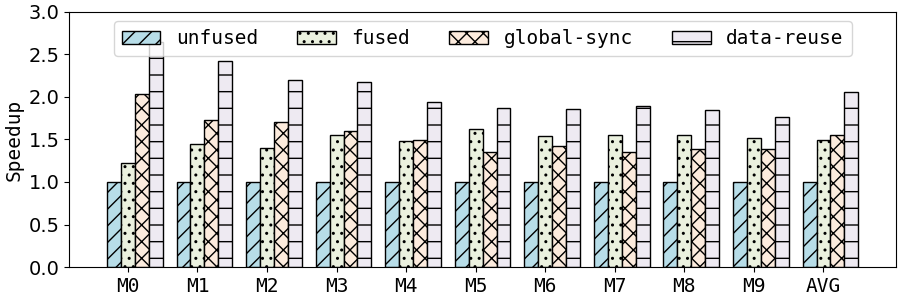

In [119]:
from IPython.display import Image
Image("results/efficientnet-se-module-latency-ours.png")

The image will be saved in `results/efficientnet-se-module-latency-ours.pdf`.
Please compare it with `Figure6`(on page 11) in the submitted paper.

## Standalone cell for unexpected result

**Latency, number of kernels and memory read bytes for ResNeXt and EfficientNet on XLA:**
Please find the "XLA RESNEXT:" and "XLA EFFICIENTNET:" at the end of the output.

In [128]:
!docker exec -it -e SOUFFLE_RUN=TRUE $(docker ps -qf "ancestor=souffle-tvm-0.8:latest") /bin/bash -c "cd /workspace/baseline/xla/xla_models && bash run_ncu_resnext_efficientnet.sh TRUE"

+ cd /workspace/baseline/xla/xla_models
+ SOUFFLE_RUN=TRUE
+ export TF_DUMP_GRAPH_PREFIX=/tmp/tf_dump_graph/
+ TF_DUMP_GRAPH_PREFIX=/tmp/tf_dump_graph/
+ export 'TF_XLA_FLAGS=--tf_xla_enable_xla_devices --tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'
+ TF_XLA_FLAGS='--tf_xla_enable_xla_devices --tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'
+ NCU_ARGS='--metrics dram__bytes_read,gpu__time_duration --clock-control none'
+ NAME=xla_resnext
+ '[' -n TRUE ']'
+ '[' TRUE = TRUE ']'
+ ncu --metrics dram__bytes_read,gpu__time_duration --clock-control none -o ncu-xla_resnext -f python tf2load_pb.py --model_file resnext_imagenet_101.pb --inputs input:1,3,224,224 --outputs Flatten/flatten/Reshape --dtype float32
+ ncu -i ./ncu-xla_resnext.ncu-rep --csv --page raw
+ grep -v redzone_checker
+ grep -v 'void convolve_common_engine_float_NHWC'
+ grep -v 'void cudnn::ops::nchwToNhwcKernel'
+ grep -v __xla_fp32_comparison
+ grep -v 'void cudnn::ops::nhwcToNchwKernel'
++ python3 ../../extract_ncu_cuda_mem_rea

## Contact
If there are any questions or suggestion, please feel free to drop me an email (scscx@leeds.ac.uk). Many thanks for your feedback!


-----
# The end of this Artifact Evaluation
-----

#### Many thanks for your review, time and efforts on this artifact evaluation.  <br> Many thanks for your understanding and bearing with some inconveniences on this notebook. 